In [32]:
!wandb login 55d09ffedb7a5b9c08dfddc17d834220dbf0bfa4

Exception in thread Exception in threading.excepthook:
Exception ignored in thread started by: <bound method Thread._bootstrap of <Thread(Thread-95 (_run_job), stopped 13011791872)>>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/threading.py", line 1032, in _bootstrap
    self._bootstrap_inner()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/threading.py", line 1077, in _bootstrap_inner
    self._invoke_excepthook(self)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/threading.py", line 1391, in invoke_excepthook
    local_print("Exception in threading.excepthook:",
  File "/Users/katrindar/Library/Python/3.12/lib/python/site-packages/ipykernel/iostream.py", line 604, in flush
    self.pub_thread.schedule(self._flush)
  File "/Users/katrindar/Library/Python/3.12/lib/python/site-packages/ipykernel/iostream.py", line 267, in schedule
    self._event_pipe.send(b"")
  File "/

wandb: Appending key for api.wandb.ai to your netrc file: /Users/katrindar/.netrc


In [33]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import BinaryAccuracy

import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

In [34]:
def display_random_sample(dataset_dir):
    classes = [
        class_name for class_name in os.listdir(dataset_dir)
        if os.path.isdir(os.path.join(dataset_dir, class_name))
    ]
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(dataset_dir, class_name)
        image_files = [
            file_name for file_name in os.listdir(class_dir)
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        
        if not image_files:
            continue

        random_image = random.choice(image_files)
        img_path = os.path.join(class_dir, random_image)
        img = load_img(img_path)
        
        plt.subplot(1, len(classes), i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{class_name} ({img.size[0]}x{img.size[1]})")
    plt.show()


Training set samples:


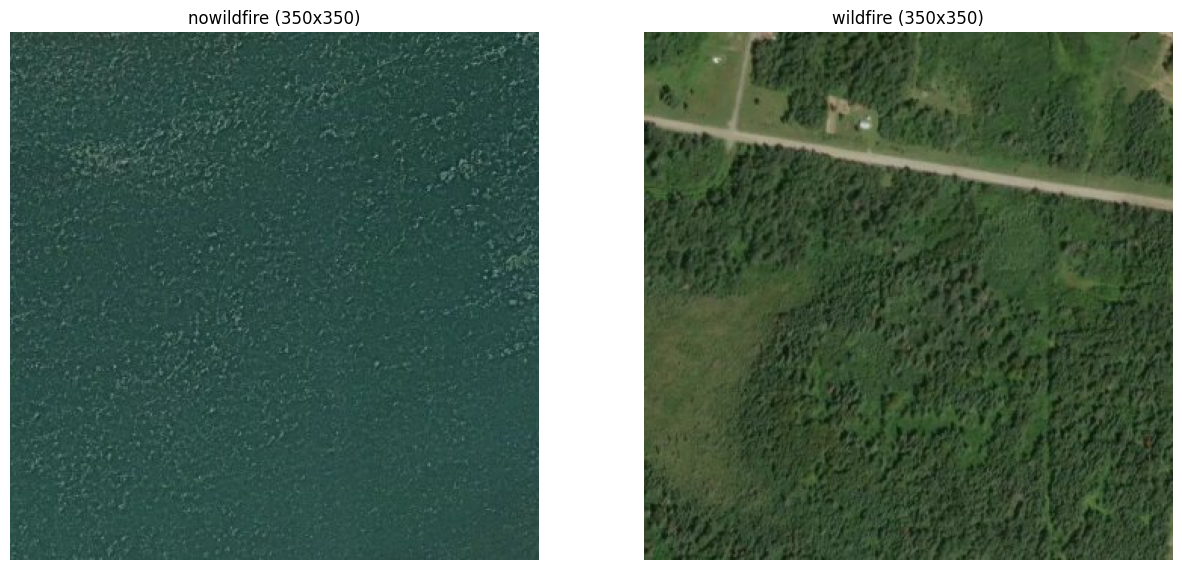

Validation set samples:


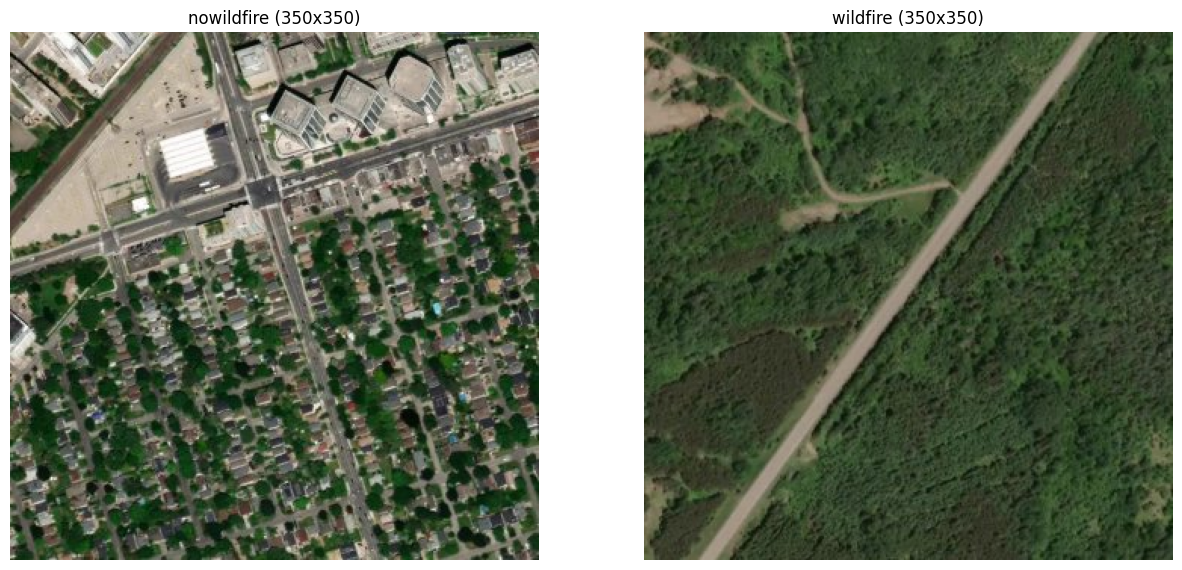

Test set samples:


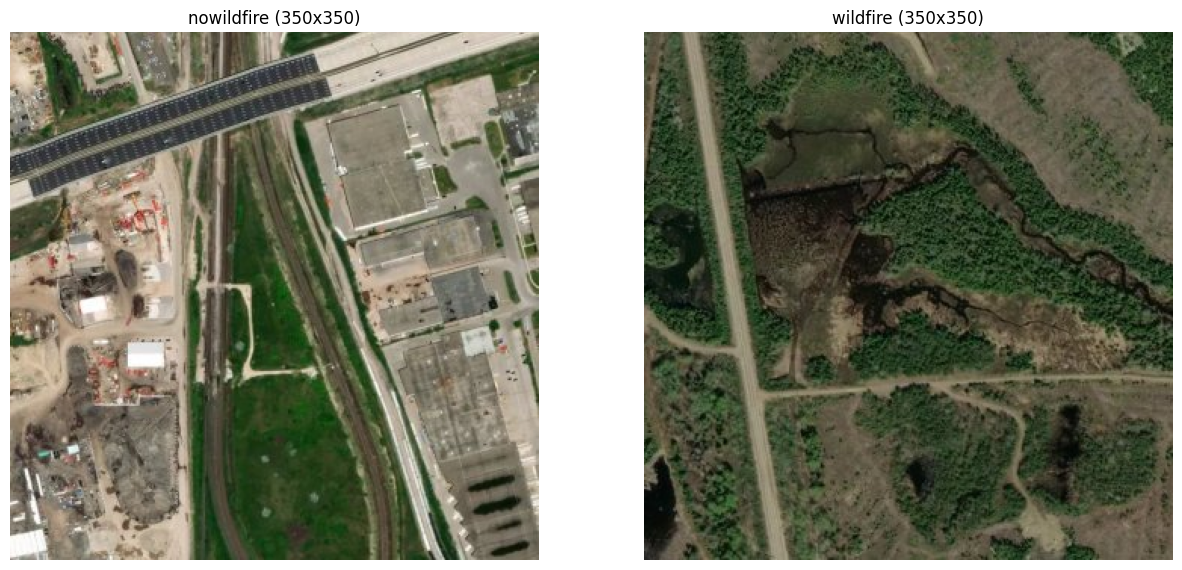

In [35]:
train_dir = 'fire_data/train'
valid_dir = 'fire_data/valid'
test_dir = 'fire_data/test'

print("Training set samples:")
display_random_sample(train_dir)

print("Validation set samples:")
display_random_sample(valid_dir)

print("Test set samples:")
display_random_sample(test_dir)

In [36]:
def load_data(directory, img_size=(32, 32)):
    X, Y = [], []
    for direct in os.listdir(directory):
        direct_path = os.path.join(directory, direct)
        if not os.path.isdir(direct_path):
            continue
        for filename in os.listdir(direct_path):
            img_path = os.path.join(direct_path, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            img = img.astype(np.float32) / 255.0
            X.append(img)
            Y.append(direct)
    return np.array(X), np.array(Y)

x_train, y_train = load_data(train_dir)
x_val, y_val = load_data(valid_dir)
x_test, y_test = load_data(test_dir)

# Convert labels to binary
y_train = np.array([1 if label == 'wildfire' else 0 for label in y_train])
y_val = np.array([1 if label == 'wildfire' else 0 for label in y_val])
y_test = np.array([1 if label == 'wildfire' else 0 for label in y_test])

print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

Premature end of JPEG file
Premature end of JPEG file


x_train shape: (30250, 32, 32, 3)
x_val shape: (6300, 32, 32, 3)
x_test shape: (6300, 32, 32, 3)
y_train shape: (30250,)
y_val shape: (6300,)
y_test shape: (6300,)


In [37]:
def build_model(input_shape, conv_layers, conv_filters, dense_units, dropout_rate, activation, optimizer, learning_rate):
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    for i in range(conv_layers):
        model.add(Conv2D(conv_filters[i], (3, 3), padding='same', activation=activation))
        model.add(MaxPooling2D((2, 2)))
        model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation=activation))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        raise ValueError("Optimizer not recognized")

    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=[BinaryAccuracy(threshold=0.45)]
    )
    
    return model

In [38]:
sweep_config = {
    'method': 'bayes',
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'conv_layers': {
            'values': [1, 2]
        },
        'dense_units': {
            'values': [64, 128, 256]
        },
        'dropout_rate': {
            'values': [0.1, 0.2, 0.3]
        },
        'learning_rate': {
            "distribution": "uniform", "max": 0.001, "min": 0.0001
        },
        'optimizer': {
            'values': ['adam', 'sgd', 'rmsprop']
        },
        'epochs': {
            'values': [10, 20, 30, 40]
        }
    }
}

In [39]:
sweep_id = wandb.sweep(sweep_config, project="wildfire-prediction-sweeps")

Create sweep with ID: szi1njd0
Sweep URL: https://wandb.ai/katrinpochtar/wildfire-prediction-sweeps/sweeps/szi1njd0


In [40]:
def train():
  
    wandb.init(project="wildfire-prediction-sweeps")
    config = wandb.config
    
    conv_layers = config.conv_layers
    conv_filters = [32]*conv_layers  # Keep simple
    dense_units = config.dense_units
    dropout_rate = config.dropout_rate
    activation = 'relu'
    optimizer = config.optimizer
    learning_rate = config.learning_rate
    epochs = config.epochs
    batch_size = 32

    model = build_model(
        input_shape=(32,32,3),
        conv_layers=conv_layers,
        conv_filters=conv_filters,
        dense_units=dense_units,
        dropout_rate=dropout_rate,
        activation=activation,
        optimizer=optimizer,
        learning_rate=learning_rate
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[WandbMetricsLogger(), WandbModelCheckpoint("model.keras"), early_stopping],
        verbose=1
    )

    # Evaluate on test data
    test_predictions = model.predict(x_test)
    y_pred = (test_predictions > 0.45).astype("int32").ravel()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')

    wandb.log({
        "test_accuracy": accuracy,
        "test_precision": precision,
        "test_recall": recall,
        "test_f1_score": f1
    })
    wandb.finish()

In [41]:
wandb.agent(sweep_id, function=train, count=300)

wandb: Agent Starting Run: xxdbfztd with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0009359678122722256
wandb: 	optimizer: adam


wandb: 🚀 View run comic-sweep-7 at: https://wandb.ai/katrinpochtar/wildfire-experiments-sweeps/runs/94xiyp19
wandb: Find logs at: wandb/run-20241216_215338-94xiyp19/logs


wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9002 - loss: 0.2998 - val_binary_accuracy: 0.9411 - val_loss: 0.1519
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9321 - loss: 0.1731 - val_binary_accuracy: 0.8827 - val_loss: 0.3503
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9450 - loss: 0.1461 - val_binary_accuracy: 0.9268 - val_loss: 0.2270
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9503 - loss: 0.1309 - val_binary_accuracy: 0.9479 - val_loss: 0.1402
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9598 - loss: 0.1122 - val_binary_accuracy: 0.9321 - val_loss: 0.1611
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9620 - loss: 0.0988 - val_binary_accuracy: 0.9233 - val_loss: 0.2365
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9649 - loss: 0.0921 - val_binary_accuracy: 0.9478 - val_loss:

wandb: Agent Starting Run: gvg7qaw7 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.00025037241039739316
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.8503 - loss: 0.3734 - val_binary_accuracy: 0.9087 - val_loss: 0.2499
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.8921 - loss: 0.2794 - val_binary_accuracy: 0.9127 - val_loss: 0.2249
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.8986 - loss: 0.2588 - val_binary_accuracy: 0.9170 - val_loss: 0.2094
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9002 - loss: 0.2459 - val_binary_accuracy: 0.9222 - val_loss: 0.2007
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9043 - loss: 0.2405 - val_binary_accuracy: 0.9248 - val_loss: 0.1961
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9061 - loss: 0.2401 - val_binary_accuracy: 0.9260 - val_loss: 0.1921
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9113 - loss: 0.2294 - val_binary_accuracy: 0.9265 - val_loss: 0.1883


wandb: Agent Starting Run: qg7qox6j with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.000535444603644942
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8983 - loss: 0.2746 - val_binary_accuracy: 0.9278 - val_loss: 0.1856
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9316 - loss: 0.1757 - val_binary_accuracy: 0.9529 - val_loss: 0.1226
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9448 - loss: 0.1448 - val_binary_accuracy: 0.8968 - val_loss: 0.2184
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9504 - loss: 0.1312 - val_binary_accuracy: 0.9500 - val_loss: 0.1401
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9529 - loss: 0.1191 - val_binary_accuracy: 0.9444 - val_loss: 0.1488
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9623 - loss: 0.1010 - val_binary_accuracy: 0.9506 - val_loss: 0.1310
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: apnvn92r with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00025402392435207213
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9021 - loss: 0.2682 - val_binary_accuracy: 0.9200 - val_loss: 0.1857
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9348 - loss: 0.1751 - val_binary_accuracy: 0.9306 - val_loss: 0.2012
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9462 - loss: 0.1415 - val_binary_accuracy: 0.9427 - val_loss: 0.1495
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9550 - loss: 0.1197 - val_binary_accuracy: 0.9435 - val_loss: 0.1509
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9638 - loss: 0.0959 - val_binary_accuracy: 0.9462 - val_loss: 0.1685
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9682 - loss: 0.0831 - val_binary_accuracy: 0.9230 - val_loss: 0.2483
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9734 - loss: 0.0691 - val_binary_accuracy: 0.9490 - val_loss:

wandb: Agent Starting Run: df6zzqon with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001255745618780233
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9032 - loss: 0.2562 - val_binary_accuracy: 0.9416 - val_loss: 0.1433
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9319 - loss: 0.1680 - val_binary_accuracy: 0.9357 - val_loss: 0.1539
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9464 - loss: 0.1371 - val_binary_accuracy: 0.9478 - val_loss: 0.1341
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9530 - loss: 0.1182 - val_binary_accuracy: 0.9537 - val_loss: 0.1211
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9616 - loss: 0.1028 - val_binary_accuracy: 0.9513 - val_loss: 0.1398
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9653 - loss: 0.0898 - val_binary_accuracy: 0.9365 - val_loss: 0.1780
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9707 - loss: 0.0780 - val_binary_accuracy: 0.9503 - val_loss:

wandb: Agent Starting Run: 9wdwwizb with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0004223892107180742
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - binary_accuracy: 0.9020 - loss: 0.2709 - val_binary_accuracy: 0.8471 - val_loss: 0.3307
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9410 - loss: 0.1526 - val_binary_accuracy: 0.9033 - val_loss: 0.2123
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9504 - loss: 0.1292 - val_binary_accuracy: 0.9483 - val_loss: 0.1306
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9584 - loss: 0.1099 - val_binary_accuracy: 0.9470 - val_loss: 0.1357
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9663 - loss: 0.0900 - val_binary_accuracy: 0.9513 - val_loss: 0.1402
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9736 - loss: 0.0712 - val_binary_accuracy: 0.9424 - val_loss: 0.2218
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9761 - loss: 0.0651 - val_binary_accuracy: 0.9432 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: itlssqaz with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0009983049471133138
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8635 - loss: 0.3278 - val_binary_accuracy: 0.9222 - val_loss: 0.1928
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9108 - loss: 0.2249 - val_binary_accuracy: 0.9311 - val_loss: 0.1742
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9158 - loss: 0.2135 - val_binary_accuracy: 0.9389 - val_loss: 0.1632
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9260 - loss: 0.1900 - val_binary_accuracy: 0.9417 - val_loss: 0.1593
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9241 - loss: 0.1894 - val_binary_accuracy: 0.9437 - val_loss: 0.1518
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9304 - loss: 0.1803 - val_binary_accuracy: 0.9419 - val_loss: 0.1604
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9298 - loss: 0.1775 - val_binary_accuracy: 0.9446 - val_loss:

wandb: Agent Starting Run: 2nwni8z8 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0006446457525028131
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9055 - loss: 0.2707 - val_binary_accuracy: 0.9119 - val_loss: 0.2054
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9399 - loss: 0.1545 - val_binary_accuracy: 0.9341 - val_loss: 0.1777
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9526 - loss: 0.1289 - val_binary_accuracy: 0.8879 - val_loss: 0.2577
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9610 - loss: 0.1046 - val_binary_accuracy: 0.9427 - val_loss: 0.1759
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9658 - loss: 0.0904 - val_binary_accuracy: 0.9460 - val_loss: 0.1645
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9742 - loss: 0.0717 - val_binary_accuracy: 0.9402 - val_loss: 0.2059
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9774 - loss: 0.0628 - val_binary_accuracy: 0.9248 - val_loss: 0.2

wandb: Agent Starting Run: c231clyd with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0006091282073115635
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8470 - loss: 0.3740 - val_binary_accuracy: 0.9127 - val_loss: 0.2228
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8916 - loss: 0.2745 - val_binary_accuracy: 0.9254 - val_loss: 0.1932
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9040 - loss: 0.2470 - val_binary_accuracy: 0.9295 - val_loss: 0.1790
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9089 - loss: 0.2356 - val_binary_accuracy: 0.9362 - val_loss: 0.1722
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9107 - loss: 0.2258 - val_binary_accuracy: 0.9370 - val_loss: 0.1646
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9169 - loss: 0.2177 - val_binary_accuracy: 0.9397 - val_loss: 0.1630
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9203 - loss: 0.2083 - val_binary_accuracy: 0.9417 - val_loss:

wandb: Agent Starting Run: 12s96x6q with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0002965914179307678
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9004 - loss: 0.2754 - val_binary_accuracy: 0.9440 - val_loss: 0.1495
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9317 - loss: 0.1823 - val_binary_accuracy: 0.9444 - val_loss: 0.1484
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9450 - loss: 0.1466 - val_binary_accuracy: 0.9483 - val_loss: 0.1358
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9491 - loss: 0.1339 - val_binary_accuracy: 0.9481 - val_loss: 0.1524
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9610 - loss: 0.1081 - val_binary_accuracy: 0.9451 - val_loss: 0.1773
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9644 - loss: 0.0987 - val_binary_accuracy: 0.9451 - val_loss: 0.1579
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9668 - loss: 0.0900 - val_binary_accuracy: 0.9333 - val_loss: 0.2029
197/19

wandb: Agent Starting Run: 70lueu8i with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0008445001500814667
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9002 - loss: 0.3271 - val_binary_accuracy: 0.8478 - val_loss: 0.3402
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9379 - loss: 0.1721 - val_binary_accuracy: 0.9454 - val_loss: 0.1526
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9456 - loss: 0.1465 - val_binary_accuracy: 0.9495 - val_loss: 0.1464
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9522 - loss: 0.1301 - val_binary_accuracy: 0.9349 - val_loss: 0.1745
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9574 - loss: 0.1191 - val_binary_accuracy: 0.8500 - val_loss: 0.4799
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9610 - loss: 0.1118 - val_binary_accuracy: 0.9502 - val_loss: 0.1621
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9659 - loss: 0.0916 - val_binary_accuracy: 0.9425 - val_loss: 0.1797
197/1

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vi2nr6lh with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0007900556135246056
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8749 - loss: 0.3211 - val_binary_accuracy: 0.9210 - val_loss: 0.2171
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9064 - loss: 0.2472 - val_binary_accuracy: 0.9249 - val_loss: 0.2009
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9126 - loss: 0.2304 - val_binary_accuracy: 0.9159 - val_loss: 0.2001
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9116 - loss: 0.2254 - val_binary_accuracy: 0.9281 - val_loss: 0.1850
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9189 - loss: 0.2105 - val_binary_accuracy: 0.9302 - val_loss: 0.1842
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9159 - loss: 0.2091 - val_binary_accuracy: 0.9340 - val_loss: 0.1684
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9213 - loss: 0.1974 - val_binary_accuracy: 0.9349 - val_loss: 0.1672
Epoch 

wandb: Agent Starting Run: x6ojpihc with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.00010504736857434594
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8322 - loss: 0.4189 - val_binary_accuracy: 0.9090 - val_loss: 0.2930
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.8877 - loss: 0.3224 - val_binary_accuracy: 0.9127 - val_loss: 0.2674
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8938 - loss: 0.2962 - val_binary_accuracy: 0.9135 - val_loss: 0.2513
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.8928 - loss: 0.2887 - val_binary_accuracy: 0.9152 - val_loss: 0.2414
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8964 - loss: 0.2755 - val_binary_accuracy: 0.9171 - val_loss: 0.2329
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8961 - loss: 0.2697 - val_binary_accuracy: 0.9190 - val_loss: 0.2262
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9024 - loss: 0.2593 - val_binary_accuracy: 0.9214 - val_loss: 0.2208
Epoch 

wandb: Agent Starting Run: ih33dtea with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.000755124288924666
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8420 - loss: 0.3698 - val_binary_accuracy: 0.9267 - val_loss: 0.1970
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9064 - loss: 0.2410 - val_binary_accuracy: 0.9354 - val_loss: 0.1788
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9130 - loss: 0.2202 - val_binary_accuracy: 0.9337 - val_loss: 0.1713
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9175 - loss: 0.2124 - val_binary_accuracy: 0.9375 - val_loss: 0.1642
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9216 - loss: 0.1995 - val_binary_accuracy: 0.9429 - val_loss: 0.1571
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9253 - loss: 0.1896 - val_binary_accuracy: 0.9403 - val_loss: 0.1549
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9253 - loss: 0.1894 - val_binary_accuracy: 0.9452 - val_loss:

wandb: Agent Starting Run: 54wa8rqy with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00016003185265433693
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.7906 - loss: 0.4772 - val_binary_accuracy: 0.9081 - val_loss: 0.2587
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8853 - loss: 0.2999 - val_binary_accuracy: 0.9138 - val_loss: 0.2352
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8954 - loss: 0.2687 - val_binary_accuracy: 0.9202 - val_loss: 0.2164
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8967 - loss: 0.2620 - val_binary_accuracy: 0.9243 - val_loss: 0.2071
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9011 - loss: 0.2493 - val_binary_accuracy: 0.9263 - val_loss: 0.2008
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9048 - loss: 0.2393 - val_binary_accuracy: 0.9283 - val_loss: 0.1972
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9072 - loss: 0.2398 - val_binary_accuracy: 0.9295 - val_loss:

wandb: Agent Starting Run: q9ls5ix3 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.00048799299268409874
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9066 - loss: 0.2646 - val_binary_accuracy: 0.9190 - val_loss: 0.1887
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9386 - loss: 0.1660 - val_binary_accuracy: 0.9349 - val_loss: 0.1576
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9451 - loss: 0.1495 - val_binary_accuracy: 0.9438 - val_loss: 0.1502
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9540 - loss: 0.1233 - val_binary_accuracy: 0.9083 - val_loss: 0.2451
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9570 - loss: 0.1153 - val_binary_accuracy: 0.9505 - val_loss: 0.1521
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9635 - loss: 0.0980 - val_binary_accuracy: 0.9144 - val_loss: 0.2123
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9705 - loss: 0.0841 - val_binary_accuracy: 0.9503 - val_loss: 0.1444
Epoch 

wandb: Agent Starting Run: hwcjwiwo with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0006396252805601163
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9011 - loss: 0.2692 - val_binary_accuracy: 0.9457 - val_loss: 0.1431
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9381 - loss: 0.1629 - val_binary_accuracy: 0.8889 - val_loss: 0.2982
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9527 - loss: 0.1257 - val_binary_accuracy: 0.9427 - val_loss: 0.1718
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9605 - loss: 0.1062 - val_binary_accuracy: 0.9444 - val_loss: 0.1554
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9662 - loss: 0.0927 - val_binary_accuracy: 0.9368 - val_loss: 0.1770
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: oy1cg7tl with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0009018592762617928
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8706 - loss: 0.3299 - val_binary_accuracy: 0.9268 - val_loss: 0.1974
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9071 - loss: 0.2351 - val_binary_accuracy: 0.9360 - val_loss: 0.1754
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9172 - loss: 0.2104 - val_binary_accuracy: 0.9362 - val_loss: 0.1747
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9190 - loss: 0.2059 - val_binary_accuracy: 0.9405 - val_loss: 0.1582
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9221 - loss: 0.1941 - val_binary_accuracy: 0.9397 - val_loss: 0.1619
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - binary_accuracy: 0.9261 - loss: 0.1878 - val_binary_accuracy: 0.9417 - val_loss: 0.1524
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9288 - loss: 0.1828 - val_binary_accuracy: 0.9425 - val_loss:

wandb: Agent Starting Run: emnghk5q with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.000935437163688132
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9025 - loss: 0.3333 - val_binary_accuracy: 0.9430 - val_loss: 0.1552
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9361 - loss: 0.1636 - val_binary_accuracy: 0.9356 - val_loss: 0.1644
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9460 - loss: 0.1428 - val_binary_accuracy: 0.9452 - val_loss: 0.1440
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9507 - loss: 0.1306 - val_binary_accuracy: 0.9487 - val_loss: 0.1394
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9616 - loss: 0.1056 - val_binary_accuracy: 0.9452 - val_loss: 0.1617
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9647 - loss: 0.0965 - val_binary_accuracy: 0.9471 - val_loss: 0.1544
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9697 - loss: 0.0838 - val_binary_accuracy: 0.9316 - val_loss: 0.2

wandb: Agent Starting Run: 1lye1dfs with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0008225485773130012
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9078 - loss: 0.2720 - val_binary_accuracy: 0.9463 - val_loss: 0.1587
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9379 - loss: 0.1600 - val_binary_accuracy: 0.9487 - val_loss: 0.1503
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9483 - loss: 0.1350 - val_binary_accuracy: 0.9379 - val_loss: 0.1800
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9563 - loss: 0.1172 - val_binary_accuracy: 0.9444 - val_loss: 0.1326
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9610 - loss: 0.1041 - val_binary_accuracy: 0.9414 - val_loss: 0.1720
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9701 - loss: 0.0821 - val_binary_accuracy: 0.9543 - val_loss: 0.1421
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9758 - loss: 0.0688 - val_binary_accuracy: 0.9332 - val_loss:

wandb: Agent Starting Run: 7jt2yylx with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00019815519379666745
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9016 - loss: 0.2765 - val_binary_accuracy: 0.9424 - val_loss: 0.1544
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9345 - loss: 0.1701 - val_binary_accuracy: 0.9494 - val_loss: 0.1388
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9453 - loss: 0.1431 - val_binary_accuracy: 0.9467 - val_loss: 0.1471
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9531 - loss: 0.1229 - val_binary_accuracy: 0.9505 - val_loss: 0.1402
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9579 - loss: 0.1103 - val_binary_accuracy: 0.9517 - val_loss: 0.1410
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9639 - loss: 0.0995 - val_binary_accuracy: 0.9522 - val_loss: 0.1375
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9672 - loss: 0.0869 - val_binary_accuracy: 0.9538 - val_loss:

wandb: Agent Starting Run: d8p3k0cy with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0003436297709115816
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8258 - loss: 0.3982 - val_binary_accuracy: 0.9070 - val_loss: 0.2376
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8933 - loss: 0.2634 - val_binary_accuracy: 0.9233 - val_loss: 0.2086
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9067 - loss: 0.2429 - val_binary_accuracy: 0.9257 - val_loss: 0.2053
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9079 - loss: 0.2332 - val_binary_accuracy: 0.9305 - val_loss: 0.1908
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9065 - loss: 0.2355 - val_binary_accuracy: 0.9329 - val_loss: 0.1870
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9142 - loss: 0.2200 - val_binary_accuracy: 0.9354 - val_loss: 0.1790
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9167 - loss: 0.2142 - val_binary_accuracy: 0.9368 - val_loss:

wandb: Agent Starting Run: c61qk9rz with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.00041077644095447553
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9029 - loss: 0.2525 - val_binary_accuracy: 0.9054 - val_loss: 0.2430
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9356 - loss: 0.1687 - val_binary_accuracy: 0.9444 - val_loss: 0.1373
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9449 - loss: 0.1402 - val_binary_accuracy: 0.9213 - val_loss: 0.1965
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9554 - loss: 0.1184 - val_binary_accuracy: 0.9511 - val_loss: 0.1461
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9606 - loss: 0.1030 - val_binary_accuracy: 0.9565 - val_loss: 0.1189
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9657 - loss: 0.0918 - val_binary_accuracy: 0.9529 - val_loss: 0.1360
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9709 - loss: 0.0764 - val_binary_accuracy: 0.9465 - val_loss:

wandb: Agent Starting Run: 8cxac9k1 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0008288032024155348
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9038 - loss: 0.2999 - val_binary_accuracy: 0.8733 - val_loss: 0.3309
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9336 - loss: 0.1745 - val_binary_accuracy: 0.9141 - val_loss: 0.2733
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9457 - loss: 0.1452 - val_binary_accuracy: 0.8946 - val_loss: 0.3088
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9520 - loss: 0.1273 - val_binary_accuracy: 0.9406 - val_loss: 0.2043
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9582 - loss: 0.1135 - val_binary_accuracy: 0.9475 - val_loss: 0.1560
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9639 - loss: 0.0980 - val_binary_accuracy: 0.9379 - val_loss: 0.2549
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9661 - loss: 0.0950 - val_binary_accuracy: 0.9433 - val_loss: 0.2009
Ep

wandb: Agent Starting Run: x9qsbr5q with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0008757953311983157
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8760 - loss: 0.3172 - val_binary_accuracy: 0.9211 - val_loss: 0.2045
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9072 - loss: 0.2366 - val_binary_accuracy: 0.9286 - val_loss: 0.1884
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9157 - loss: 0.2144 - val_binary_accuracy: 0.9306 - val_loss: 0.1804
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9179 - loss: 0.2098 - val_binary_accuracy: 0.9319 - val_loss: 0.1745
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9192 - loss: 0.2063 - val_binary_accuracy: 0.9343 - val_loss: 0.1758
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9244 - loss: 0.1936 - val_binary_accuracy: 0.9360 - val_loss: 0.1678
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9249 - loss: 0.1950 - val_binary_accuracy: 0.9356 - val_loss: 

wandb: Agent Starting Run: xh9e3hq8 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0004925696311695638
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8492 - loss: 0.3666 - val_binary_accuracy: 0.9156 - val_loss: 0.2187
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9043 - loss: 0.2450 - val_binary_accuracy: 0.9246 - val_loss: 0.2028
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9086 - loss: 0.2343 - val_binary_accuracy: 0.9292 - val_loss: 0.1874
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9142 - loss: 0.2234 - val_binary_accuracy: 0.9327 - val_loss: 0.1803
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9142 - loss: 0.2192 - val_binary_accuracy: 0.9344 - val_loss: 0.1821
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9175 - loss: 0.2035 - val_binary_accuracy: 0.9368 - val_loss: 0.1738
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9190 - loss: 0.2052 - val_binary_accuracy: 0.9384 - val_loss:

wandb: Agent Starting Run: govuglg7 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0004725179318372624
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9019 - loss: 0.2750 - val_binary_accuracy: 0.9478 - val_loss: 0.1427
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9392 - loss: 0.1664 - val_binary_accuracy: 0.9348 - val_loss: 0.2029
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9521 - loss: 0.1309 - val_binary_accuracy: 0.9090 - val_loss: 0.2738
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9626 - loss: 0.1025 - val_binary_accuracy: 0.9492 - val_loss: 0.1500
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9710 - loss: 0.0821 - val_binary_accuracy: 0.9454 - val_loss: 0.1832
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e96wgisw with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.000393511186060096
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9046 - loss: 0.2553 - val_binary_accuracy: 0.9465 - val_loss: 0.1476
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9370 - loss: 0.1655 - val_binary_accuracy: 0.9489 - val_loss: 0.1484
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9473 - loss: 0.1349 - val_binary_accuracy: 0.9530 - val_loss: 0.1343
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9579 - loss: 0.1150 - val_binary_accuracy: 0.9008 - val_loss: 0.2667
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9640 - loss: 0.1001 - val_binary_accuracy: 0.9522 - val_loss: 0.1545
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9703 - loss: 0.0812 - val_binary_accuracy: 0.9511 - val_loss: 0.1539
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9717 - loss: 0.0734 - val_binary_accuracy: 0.9525 - val_loss:

wandb: Agent Starting Run: w2fpfnn2 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0007996060461022461
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.8711 - loss: 0.3412 - val_binary_accuracy: 0.9162 - val_loss: 0.2197
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8966 - loss: 0.2649 - val_binary_accuracy: 0.9270 - val_loss: 0.2096
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9080 - loss: 0.2359 - val_binary_accuracy: 0.9329 - val_loss: 0.1907
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9108 - loss: 0.2278 - val_binary_accuracy: 0.9305 - val_loss: 0.1783
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9130 - loss: 0.2255 - val_binary_accuracy: 0.9346 - val_loss: 0.1727
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9139 - loss: 0.2156 - val_binary_accuracy: 0.9371 - val_loss: 0.1721
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9153 - loss: 0.2148 - val_binary_accuracy: 0.9375 - val_loss: 0.1654
Epoch 

wandb: Agent Starting Run: 8npj12a1 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.00027640737902545804
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9020 - loss: 0.2781 - val_binary_accuracy: 0.9362 - val_loss: 0.1620
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9382 - loss: 0.1673 - val_binary_accuracy: 0.9408 - val_loss: 0.1731
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9557 - loss: 0.1243 - val_binary_accuracy: 0.9513 - val_loss: 0.1364
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9623 - loss: 0.1013 - val_binary_accuracy: 0.9460 - val_loss: 0.1628
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9679 - loss: 0.0940 - val_binary_accuracy: 0.9422 - val_loss: 0.2089
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9750 - loss: 0.0726 - val_binary_accuracy: 0.9492 - val_loss: 0.1610
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9768 - loss: 0.0650 - val_binary_accuracy: 0.9495 - val_loss:

wandb: Agent Starting Run: 90efrmd5 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00014349501075699796
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8365 - loss: 0.3973 - val_binary_accuracy: 0.9098 - val_loss: 0.2645
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.8934 - loss: 0.2784 - val_binary_accuracy: 0.9167 - val_loss: 0.2373
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.8973 - loss: 0.2601 - val_binary_accuracy: 0.9221 - val_loss: 0.2254
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9039 - loss: 0.2521 - val_binary_accuracy: 0.9244 - val_loss: 0.2181
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9070 - loss: 0.2440 - val_binary_accuracy: 0.9259 - val_loss: 0.2129
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9084 - loss: 0.2391 - val_binary_accuracy: 0.9271 - val_loss: 0.2090
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9084 - loss: 0.2367 - val_binary_accuracy: 0.9281 - val_loss:

wandb: Agent Starting Run: c5mob3fe with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00012963307679018032
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.7996 - loss: 0.4658 - val_binary_accuracy: 0.8959 - val_loss: 0.2794
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8788 - loss: 0.3055 - val_binary_accuracy: 0.9032 - val_loss: 0.2485
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8858 - loss: 0.2835 - val_binary_accuracy: 0.9097 - val_loss: 0.2310
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.8890 - loss: 0.2712 - val_binary_accuracy: 0.9148 - val_loss: 0.2171
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.8977 - loss: 0.2584 - val_binary_accuracy: 0.9195 - val_loss: 0.2078
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9000 - loss: 0.2501 - val_binary_accuracy: 0.9219 - val_loss: 0.2023
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9040 - loss: 0.2442 - val_binary_accuracy: 0.9237 - val_loss:

wandb: Agent Starting Run: lcembrch with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0009344949403885716
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9012 - loss: 0.3045 - val_binary_accuracy: 0.9241 - val_loss: 0.2008
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9308 - loss: 0.1810 - val_binary_accuracy: 0.9367 - val_loss: 0.1802
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9407 - loss: 0.1557 - val_binary_accuracy: 0.8895 - val_loss: 0.3308
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9478 - loss: 0.1380 - val_binary_accuracy: 0.9173 - val_loss: 0.2243
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9546 - loss: 0.1200 - val_binary_accuracy: 0.9444 - val_loss: 0.1586
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9563 - loss: 0.1108 - val_binary_accuracy: 0.9451 - val_loss: 0.1540
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9627 - loss: 0.0980 - val_binary_accuracy: 0.9381 - val_loss: 0.1734
Epo

wandb: Agent Starting Run: aec3rjqv with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.000887523913544751
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9000 - loss: 0.3072 - val_binary_accuracy: 0.8721 - val_loss: 0.2678
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9332 - loss: 0.1787 - val_binary_accuracy: 0.9417 - val_loss: 0.1701
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9417 - loss: 0.1578 - val_binary_accuracy: 0.9429 - val_loss: 0.2175
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9511 - loss: 0.1357 - val_binary_accuracy: 0.9486 - val_loss: 0.1621
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9522 - loss: 0.1263 - val_binary_accuracy: 0.9476 - val_loss: 0.1579
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9578 - loss: 0.1169 - val_binary_accuracy: 0.9567 - val_loss: 0.1272
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9608 - loss: 0.1079 - val_binary_accuracy: 0.9140 - val_loss:

wandb: Agent Starting Run: 4zxpjc8w with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0006561482055115458
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9028 - loss: 0.2855 - val_binary_accuracy: 0.9265 - val_loss: 0.2150
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9356 - loss: 0.1615 - val_binary_accuracy: 0.9222 - val_loss: 0.2097
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9511 - loss: 0.1282 - val_binary_accuracy: 0.9321 - val_loss: 0.1633
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9568 - loss: 0.1124 - val_binary_accuracy: 0.9475 - val_loss: 0.1476
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9635 - loss: 0.0967 - val_binary_accuracy: 0.9467 - val_loss: 0.1557
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9691 - loss: 0.0842 - val_binary_accuracy: 0.9529 - val_loss: 0.1504
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9745 - loss: 0.0717 - val_binary_accuracy: 0.9419 - val_loss:

wandb: Agent Starting Run: 6tubvblb with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.000323653756569636
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9058 - loss: 0.2670 - val_binary_accuracy: 0.9349 - val_loss: 0.1621
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9398 - loss: 0.1550 - val_binary_accuracy: 0.9492 - val_loss: 0.1354
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9559 - loss: 0.1167 - val_binary_accuracy: 0.9479 - val_loss: 0.1339
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9674 - loss: 0.0917 - val_binary_accuracy: 0.9446 - val_loss: 0.1424
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9727 - loss: 0.0748 - val_binary_accuracy: 0.9402 - val_loss: 0.1765
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9787 - loss: 0.0599 - val_binary_accuracy: 0.9417 - val_loss: 0.1961
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9846 - loss: 0.0472 - val_binary_accuracy: 0.9478 - val_loss: 0.1834

wandb: Agent Starting Run: 59d893ji with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0005052504580217535
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.8622 - loss: 0.3511 - val_binary_accuracy: 0.9154 - val_loss: 0.2293
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.8997 - loss: 0.2598 - val_binary_accuracy: 0.9249 - val_loss: 0.2043
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9079 - loss: 0.2368 - val_binary_accuracy: 0.9278 - val_loss: 0.1911
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9105 - loss: 0.2299 - val_binary_accuracy: 0.9294 - val_loss: 0.1839
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9125 - loss: 0.2228 - val_binary_accuracy: 0.9327 - val_loss: 0.1799
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9166 - loss: 0.2148 - val_binary_accuracy: 0.9346 - val_loss: 0.1771
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9199 - loss: 0.2092 - val_binary_accuracy: 0.9352 - val_loss: 0.1706
E

wandb: Agent Starting Run: aa2fsz32 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0004960524110404719
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8445 - loss: 0.3779 - val_binary_accuracy: 0.9119 - val_loss: 0.2182
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9008 - loss: 0.2580 - val_binary_accuracy: 0.9222 - val_loss: 0.1940
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9046 - loss: 0.2400 - val_binary_accuracy: 0.9297 - val_loss: 0.1815
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9124 - loss: 0.2241 - val_binary_accuracy: 0.9335 - val_loss: 0.1752
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9157 - loss: 0.2167 - val_binary_accuracy: 0.9348 - val_loss: 0.1687
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9197 - loss: 0.2055 - val_binary_accuracy: 0.9356 - val_loss: 0.1703
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9203 - loss: 0.2062 - val_binary_accuracy: 0.9376 - val_loss:

wandb: Agent Starting Run: fefncqeu with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0006396410615379949
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9022 - loss: 0.2791 - val_binary_accuracy: 0.9379 - val_loss: 0.1728
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9375 - loss: 0.1666 - val_binary_accuracy: 0.9424 - val_loss: 0.1474
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 493s 522ms/step - binary_accuracy: 0.9499 - loss: 0.1361 - val_binary_accuracy: 0.9390 - val_loss: 0.1649
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9574 - loss: 0.1182 - val_binary_accuracy: 0.9289 - val_loss: 0.2283
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9657 - loss: 0.0992 - val_binary_accuracy: 0.9386 - val_loss: 0.1897
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9685 - loss: 0.0900 - val_binary_accuracy: 0.9197 - val_loss: 0.3536
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: 6egub9ka with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0006785595702671709
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 62s 64ms/step - binary_accuracy: 0.9080 - loss: 0.2493 - val_binary_accuracy: 0.9052 - val_loss: 0.2411
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9388 - loss: 0.1559 - val_binary_accuracy: 0.9041 - val_loss: 0.2436
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9488 - loss: 0.1334 - val_binary_accuracy: 0.9237 - val_loss: 0.1800
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9564 - loss: 0.1137 - val_binary_accuracy: 0.9489 - val_loss: 0.1562
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9635 - loss: 0.0980 - val_binary_accuracy: 0.9456 - val_loss: 0.1602
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 909s 962ms/step - binary_accuracy: 0.9705 - loss: 0.0831 - val_binary_accuracy: 0.9203 - val_loss: 0.2501
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9730 - loss: 0.0707 - val_binary_accuracy: 0.9548 - val_los

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4sewhfr5 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0009353030574909328
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9051 - loss: 0.3040 - val_binary_accuracy: 0.9402 - val_loss: 0.1536
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9352 - loss: 0.1688 - val_binary_accuracy: 0.9413 - val_loss: 0.1652
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9438 - loss: 0.1449 - val_binary_accuracy: 0.9111 - val_loss: 0.3112
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9576 - loss: 0.1171 - val_binary_accuracy: 0.9467 - val_loss: 0.1572
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 914s 967ms/step - binary_accuracy: 0.9588 - loss: 0.1055 - val_binary_accuracy: 0.9325 - val_loss: 0.1833
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: y5m1hs4q with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0004294578846397376
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9022 - loss: 0.2691 - val_binary_accuracy: 0.9113 - val_loss: 0.1910
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9343 - loss: 0.1723 - val_binary_accuracy: 0.9449 - val_loss: 0.1358
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9435 - loss: 0.1495 - val_binary_accuracy: 0.9383 - val_loss: 0.1503
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9521 - loss: 0.1309 - val_binary_accuracy: 0.9413 - val_loss: 0.1642
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9573 - loss: 0.1121 - val_binary_accuracy: 0.9287 - val_loss: 0.2187
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9590 - loss: 0.1073 - val_binary_accuracy: 0.9437 - val_loss: 0.1962
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: scs0dhcl with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.00045115295290845616
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9069 - loss: 0.2641 - val_binary_accuracy: 0.9108 - val_loss: 0.2143
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9339 - loss: 0.1759 - val_binary_accuracy: 0.9444 - val_loss: 0.1597
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9469 - loss: 0.1401 - val_binary_accuracy: 0.9360 - val_loss: 0.1986
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9570 - loss: 0.1167 - val_binary_accuracy: 0.8389 - val_loss: 0.5450
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9622 - loss: 0.0990 - val_binary_accuracy: 0.9449 - val_loss: 0.1689
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9664 - loss: 0.0873 - val_binary_accuracy: 0.9448 - val_loss: 0.1854
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: l2m6m01f with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0002137609741156568
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - binary_accuracy: 0.9044 - loss: 0.2668 - val_binary_accuracy: 0.9421 - val_loss: 0.1479
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9431 - loss: 0.1500 - val_binary_accuracy: 0.9478 - val_loss: 0.1386
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9527 - loss: 0.1237 - val_binary_accuracy: 0.9437 - val_loss: 0.1615
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9648 - loss: 0.0952 - val_binary_accuracy: 0.9378 - val_loss: 0.1730
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9724 - loss: 0.0783 - val_binary_accuracy: 0.9437 - val_loss: 0.1553
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9751 - loss: 0.0686 - val_binary_accuracy: 0.9481 - val_loss: 0.1687
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: xs0sw2ja with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0005290562366223352
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.8500 - loss: 0.3615 - val_binary_accuracy: 0.9271 - val_loss: 0.2005
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 913s 966ms/step - binary_accuracy: 0.8989 - loss: 0.2568 - val_binary_accuracy: 0.9321 - val_loss: 0.1814
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9055 - loss: 0.2430 - val_binary_accuracy: 0.9348 - val_loss: 0.1748
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9095 - loss: 0.2305 - val_binary_accuracy: 0.9360 - val_loss: 0.1738
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9140 - loss: 0.2228 - val_binary_accuracy: 0.9386 - val_loss: 0.1643
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9190 - loss: 0.2110 - val_binary_accuracy: 0.9408 - val_loss: 0.1629
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9179 - loss: 0.2115 - val_binary_accuracy: 0.9392 - val_loss: 0.1

wandb: Agent Starting Run: lspgr9yb with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0005954086555070804
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9037 - loss: 0.2683 - val_binary_accuracy: 0.9151 - val_loss: 0.2010
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9347 - loss: 0.1728 - val_binary_accuracy: 0.9476 - val_loss: 0.1365
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9463 - loss: 0.1441 - val_binary_accuracy: 0.9471 - val_loss: 0.1700
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9509 - loss: 0.1324 - val_binary_accuracy: 0.9427 - val_loss: 0.1867
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9579 - loss: 0.1138 - val_binary_accuracy: 0.9390 - val_loss: 0.2857
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9624 - loss: 0.1019 - val_binary_accuracy: 0.9422 - val_loss: 0.1782
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: 5gz76i1h with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0005554934023736403
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9063 - loss: 0.2723 - val_binary_accuracy: 0.9381 - val_loss: 0.1568
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 996s 1s/step - binary_accuracy: 0.9429 - loss: 0.1527 - val_binary_accuracy: 0.9456 - val_loss: 0.1438
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9547 - loss: 0.1226 - val_binary_accuracy: 0.9470 - val_loss: 0.1403
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9659 - loss: 0.0920 - val_binary_accuracy: 0.9190 - val_loss: 0.2352
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9726 - loss: 0.0771 - val_binary_accuracy: 0.9259 - val_loss: 0.2185
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9771 - loss: 0.0680 - val_binary_accuracy: 0.9375 - val_loss: 0.2235
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9811 - loss: 0.0565 - val_binary_accuracy: 0.9402 - val_loss: 0.1826

wandb: Agent Starting Run: f9fgboou with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0006037624696468694
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8725 - loss: 0.3357 - val_binary_accuracy: 0.9190 - val_loss: 0.2177
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8967 - loss: 0.2627 - val_binary_accuracy: 0.9248 - val_loss: 0.1991
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9100 - loss: 0.2352 - val_binary_accuracy: 0.9300 - val_loss: 0.1867
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9145 - loss: 0.2262 - val_binary_accuracy: 0.9324 - val_loss: 0.1799
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9128 - loss: 0.2165 - val_binary_accuracy: 0.9356 - val_loss: 0.1761
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9180 - loss: 0.2131 - val_binary_accuracy: 0.9367 - val_loss: 0.1698
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9217 - loss: 0.2065 - val_binary_accuracy: 0.9378 - val_loss: 0.1665
Epoc

wandb: Agent Starting Run: fb6gigu8 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0006655628077254865
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8651 - loss: 0.3426 - val_binary_accuracy: 0.9162 - val_loss: 0.2181
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9033 - loss: 0.2474 - val_binary_accuracy: 0.9275 - val_loss: 0.2024
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9115 - loss: 0.2364 - val_binary_accuracy: 0.9289 - val_loss: 0.1962
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9149 - loss: 0.2149 - val_binary_accuracy: 0.9287 - val_loss: 0.1841
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9159 - loss: 0.2154 - val_binary_accuracy: 0.9295 - val_loss: 0.1794
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9167 - loss: 0.2113 - val_binary_accuracy: 0.9314 - val_loss: 0.1756
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9194 - loss: 0.2038 - val_binary_accuracy: 0.9341 - val_loss: 0.1736
Epoch 

wandb: Agent Starting Run: 2syiar7h with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0005660980185381725
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9040 - loss: 0.2726 - val_binary_accuracy: 0.9168 - val_loss: 0.1991
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9416 - loss: 0.1590 - val_binary_accuracy: 0.9529 - val_loss: 0.1349
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9530 - loss: 0.1304 - val_binary_accuracy: 0.9484 - val_loss: 0.1305
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9598 - loss: 0.1062 - val_binary_accuracy: 0.9529 - val_loss: 0.1395
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9671 - loss: 0.0906 - val_binary_accuracy: 0.9460 - val_loss: 0.1578
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9732 - loss: 0.0729 - val_binary_accuracy: 0.9449 - val_loss: 0.1981
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9796 - loss: 0.0587 - val_binary_accuracy: 0.9503 - val_loss:

wandb: Agent Starting Run: 0ku0xa83 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.00033011666487617715
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8170 - loss: 0.4244 - val_binary_accuracy: 0.9090 - val_loss: 0.2396
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.8901 - loss: 0.2770 - val_binary_accuracy: 0.9202 - val_loss: 0.2171
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9029 - loss: 0.2508 - val_binary_accuracy: 0.9238 - val_loss: 0.2013
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9062 - loss: 0.2429 - val_binary_accuracy: 0.9254 - val_loss: 0.1970
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9086 - loss: 0.2349 - val_binary_accuracy: 0.9278 - val_loss: 0.1898
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9132 - loss: 0.2273 - val_binary_accuracy: 0.9302 - val_loss: 0.1838
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9112 - loss: 0.2311 - val_binary_accuracy: 0.9324 - val_loss:

wandb: Agent Starting Run: fbfvuu8b with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0005586312586610706
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9047 - loss: 0.2608 - val_binary_accuracy: 0.9443 - val_loss: 0.1555
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9356 - loss: 0.1653 - val_binary_accuracy: 0.9298 - val_loss: 0.2063
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9466 - loss: 0.1432 - val_binary_accuracy: 0.9511 - val_loss: 0.1296
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9508 - loss: 0.1292 - val_binary_accuracy: 0.9446 - val_loss: 0.1330
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9561 - loss: 0.1157 - val_binary_accuracy: 0.9475 - val_loss: 0.1528
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9656 - loss: 0.0955 - val_binary_accuracy: 0.9376 - val_loss: 0.1552
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9658 - loss: 0.0875 - val_binary_accuracy: 0.9386 - val_loss:

wandb: Agent Starting Run: hh4tphj1 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.00018942322351981497
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8982 - loss: 0.2638 - val_binary_accuracy: 0.9424 - val_loss: 0.1508
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9412 - loss: 0.1557 - val_binary_accuracy: 0.9446 - val_loss: 0.1549
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9441 - loss: 0.1398 - val_binary_accuracy: 0.9456 - val_loss: 0.1370
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9542 - loss: 0.1211 - val_binary_accuracy: 0.9500 - val_loss: 0.1277
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9613 - loss: 0.1002 - val_binary_accuracy: 0.9471 - val_loss: 0.1319
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9679 - loss: 0.0885 - val_binary_accuracy: 0.9441 - val_loss: 0.1428
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9707 - loss: 0.0773 - val_binary_accuracy: 0.9438 - val_loss:

wandb: Agent Starting Run: z2qzmy53 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0005382992797760715
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9075 - loss: 0.2587 - val_binary_accuracy: 0.9432 - val_loss: 0.1555
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9382 - loss: 0.1689 - val_binary_accuracy: 0.8598 - val_loss: 0.3262
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9470 - loss: 0.1400 - val_binary_accuracy: 0.9356 - val_loss: 0.2191
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 343s 363ms/step - binary_accuracy: 0.9589 - loss: 0.1141 - val_binary_accuracy: 0.9375 - val_loss: 0.1971
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9648 - loss: 0.0961 - val_binary_accuracy: 0.9563 - val_loss: 0.1361
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9690 - loss: 0.0816 - val_binary_accuracy: 0.9548 - val_loss: 0.1486
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9746 - loss: 0.0702 - val_binary_accuracy: 0.9100 - val_los

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ttcjm7ds with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0006573928500936567
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 494s 522ms/step - binary_accuracy: 0.8606 - loss: 0.3650 - val_binary_accuracy: 0.9208 - val_loss: 0.2169
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9008 - loss: 0.2523 - val_binary_accuracy: 0.9251 - val_loss: 0.1968
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9055 - loss: 0.2419 - val_binary_accuracy: 0.9313 - val_loss: 0.1869
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9107 - loss: 0.2283 - val_binary_accuracy: 0.9303 - val_loss: 0.1871
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9146 - loss: 0.2162 - val_binary_accuracy: 0.9324 - val_loss: 0.1756
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9179 - loss: 0.2149 - val_binary_accuracy: 0.9332 - val_loss: 0.1761
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9202 - loss: 0.2040 - val_binary_accuracy: 0.9378 - val_loss: 0.1691
Ep

wandb: Agent Starting Run: 4e39ro1r with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0005129470886380172
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9013 - loss: 0.3077 - val_binary_accuracy: 0.9308 - val_loss: 0.1936
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9393 - loss: 0.1573 - val_binary_accuracy: 0.9171 - val_loss: 0.2376
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9549 - loss: 0.1192 - val_binary_accuracy: 0.9492 - val_loss: 0.1448
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9679 - loss: 0.0918 - val_binary_accuracy: 0.9484 - val_loss: 0.1390
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9710 - loss: 0.0786 - val_binary_accuracy: 0.9452 - val_loss: 0.1678
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9757 - loss: 0.0641 - val_binary_accuracy: 0.9478 - val_loss: 0.1599
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9766 - loss: 0.0624 - val_binary_accuracy: 0.9411 - val_loss: 0.1993
Ep

wandb: Agent Starting Run: 9q6vgyh3 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0009013389157532368
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8655 - loss: 0.3303 - val_binary_accuracy: 0.9259 - val_loss: 0.1958
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 1025s 1s/step - binary_accuracy: 0.9090 - loss: 0.2316 - val_binary_accuracy: 0.9316 - val_loss: 0.1806
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9124 - loss: 0.2216 - val_binary_accuracy: 0.9352 - val_loss: 0.1711
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9212 - loss: 0.2007 - val_binary_accuracy: 0.9357 - val_loss: 0.1686
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9213 - loss: 0.1995 - val_binary_accuracy: 0.9416 - val_loss: 0.1620
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9262 - loss: 0.1903 - val_binary_accuracy: 0.9432 - val_loss: 0.1566
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9255 - loss: 0.1891 - val_binary_accuracy: 0.9411 - val_loss:

wandb: Agent Starting Run: ak6v0etk with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0003497591553115805
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 1031s 1s/step - binary_accuracy: 0.8114 - loss: 0.4690 - val_binary_accuracy: 0.9113 - val_loss: 0.2325
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8873 - loss: 0.2805 - val_binary_accuracy: 0.9230 - val_loss: 0.2082
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9010 - loss: 0.2530 - val_binary_accuracy: 0.9278 - val_loss: 0.1945
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9072 - loss: 0.2389 - val_binary_accuracy: 0.9302 - val_loss: 0.1874
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9098 - loss: 0.2310 - val_binary_accuracy: 0.9319 - val_loss: 0.1874
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9108 - loss: 0.2272 - val_binary_accuracy: 0.9337 - val_loss: 0.1769
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9099 - loss: 0.2282 - val_binary_accuracy: 0.9351 - val_loss: 0.16

wandb: Agent Starting Run: 9zrgeaew with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.00028874571776982207
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8480 - loss: 0.3770 - val_binary_accuracy: 0.9075 - val_loss: 0.2559
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.8898 - loss: 0.2809 - val_binary_accuracy: 0.9116 - val_loss: 0.2303
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 790s 836ms/step - binary_accuracy: 0.9001 - loss: 0.2538 - val_binary_accuracy: 0.9189 - val_loss: 0.2162
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9042 - loss: 0.2395 - val_binary_accuracy: 0.9203 - val_loss: 0.2069
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9078 - loss: 0.2343 - val_binary_accuracy: 0.9246 - val_loss: 0.2009
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - binary_accuracy: 0.9095 - loss: 0.2306 - val_binary_accuracy: 0.9256 - val_loss: 0.1971
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - binary_accuracy: 0.9111 - loss: 0.2250 - val_binary_accuracy: 0.9268 - val_loss: 0.1923
Ep

wandb: Agent Starting Run: wx98jkoy with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.00031456868512060385
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9047 - loss: 0.2819 - val_binary_accuracy: 0.9351 - val_loss: 0.1602
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9395 - loss: 0.1656 - val_binary_accuracy: 0.9392 - val_loss: 0.1541
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 202s 213ms/step - binary_accuracy: 0.9489 - loss: 0.1340 - val_binary_accuracy: 0.9386 - val_loss: 0.1697
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9570 - loss: 0.1186 - val_binary_accuracy: 0.9490 - val_loss: 0.1483
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9655 - loss: 0.0979 - val_binary_accuracy: 0.9438 - val_loss: 0.1629
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9729 - loss: 0.0795 - val_binary_accuracy: 0.9279 - val_loss: 0.2560
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - binary_accuracy: 0.9745 - loss: 0.0717 - val_binary_accuracy: 0.9063 - val_loss: 0.3383


wandb: Agent Starting Run: vbk5w07u with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00016649403674509725
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8993 - loss: 0.2809 - val_binary_accuracy: 0.9152 - val_loss: 0.2034
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9336 - loss: 0.1707 - val_binary_accuracy: 0.9441 - val_loss: 0.1490
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9484 - loss: 0.1330 - val_binary_accuracy: 0.9459 - val_loss: 0.1555
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9599 - loss: 0.1097 - val_binary_accuracy: 0.9471 - val_loss: 0.1471
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9685 - loss: 0.0860 - val_binary_accuracy: 0.9478 - val_loss: 0.1393
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9738 - loss: 0.0755 - val_binary_accuracy: 0.9481 - val_loss: 0.1370
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9775 - loss: 0.0641 - val_binary_accuracy: 0.9471 - val_loss:

wandb: Agent Starting Run: ad9atpsd with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0008672124145844368
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9004 - loss: 0.3582 - val_binary_accuracy: 0.8548 - val_loss: 0.3510
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9363 - loss: 0.1629 - val_binary_accuracy: 0.9456 - val_loss: 0.1666
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9481 - loss: 0.1368 - val_binary_accuracy: 0.9478 - val_loss: 0.1531
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9596 - loss: 0.1125 - val_binary_accuracy: 0.9459 - val_loss: 0.1390
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9654 - loss: 0.0933 - val_binary_accuracy: 0.8271 - val_loss: 0.4487
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9692 - loss: 0.0883 - val_binary_accuracy: 0.9383 - val_loss: 0.1679
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9750 - loss: 0.0693 - val_binary_accuracy: 0.9349 - val_loss:

wandb: Agent Starting Run: 27hrialm with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0005624156222986428
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.8527 - loss: 0.3642 - val_binary_accuracy: 0.9184 - val_loss: 0.2264
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 968s 1s/step - binary_accuracy: 0.9012 - loss: 0.2549 - val_binary_accuracy: 0.9257 - val_loss: 0.2040
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9033 - loss: 0.2499 - val_binary_accuracy: 0.9298 - val_loss: 0.1899
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9083 - loss: 0.2419 - val_binary_accuracy: 0.9308 - val_loss: 0.1855
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9095 - loss: 0.2366 - val_binary_accuracy: 0.9321 - val_loss: 0.1789
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9159 - loss: 0.2164 - val_binary_accuracy: 0.9373 - val_loss: 0.1729
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9177 - loss: 0.2149 - val_binary_accuracy: 0.9379 - val_loss: 0.1701
Ep

wandb: Agent Starting Run: 3hnx6nma with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0002718698730682762
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9014 - loss: 0.2745 - val_binary_accuracy: 0.9429 - val_loss: 0.1444
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9368 - loss: 0.1588 - val_binary_accuracy: 0.9403 - val_loss: 0.1685
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9513 - loss: 0.1308 - val_binary_accuracy: 0.9424 - val_loss: 0.1666
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9607 - loss: 0.1047 - val_binary_accuracy: 0.9406 - val_loss: 0.1680
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9639 - loss: 0.0989 - val_binary_accuracy: 0.9503 - val_loss: 0.1453
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: 6z2n30zk with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0009583410002227864
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9073 - loss: 0.2777 - val_binary_accuracy: 0.9029 - val_loss: 0.2749
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9384 - loss: 0.1627 - val_binary_accuracy: 0.8830 - val_loss: 0.3051
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9467 - loss: 0.1403 - val_binary_accuracy: 0.9424 - val_loss: 0.1784
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 912s 965ms/step - binary_accuracy: 0.9580 - loss: 0.1096 - val_binary_accuracy: 0.9430 - val_loss: 0.1860
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9647 - loss: 0.0965 - val_binary_accuracy: 0.9425 - val_loss: 0.1623
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9688 - loss: 0.0839 - val_binary_accuracy: 0.9086 - val_loss: 0.3171
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9752 - loss: 0.0668 - val_binary_accuracy: 0.9441 - val_loss: 0.1645


wandb: Agent Starting Run: siy7j14c with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0008474022728657638
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 936s 990ms/step - binary_accuracy: 0.9026 - loss: 0.3008 - val_binary_accuracy: 0.7262 - val_loss: 0.6010
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9331 - loss: 0.1748 - val_binary_accuracy: 0.9449 - val_loss: 0.1487
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9441 - loss: 0.1513 - val_binary_accuracy: 0.9170 - val_loss: 0.2279
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9516 - loss: 0.1302 - val_binary_accuracy: 0.9325 - val_loss: 0.1993
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9576 - loss: 0.1156 - val_binary_accuracy: 0.9414 - val_loss: 0.2399
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9607 - loss: 0.1090 - val_binary_accuracy: 0.9430 - val_loss: 0.1675
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: yxcl3ntt with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0009813783848130894
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9076 - loss: 0.3293 - val_binary_accuracy: 0.9438 - val_loss: 0.1517
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9359 - loss: 0.1627 - val_binary_accuracy: 0.9486 - val_loss: 0.1366
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9498 - loss: 0.1308 - val_binary_accuracy: 0.9332 - val_loss: 0.1687
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9549 - loss: 0.1215 - val_binary_accuracy: 0.9440 - val_loss: 0.1670
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9641 - loss: 0.1002 - val_binary_accuracy: 0.9408 - val_loss: 0.1625
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9701 - loss: 0.0842 - val_binary_accuracy: 0.9389 - val_loss: 0.1976
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: brkhphfv with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0008382579469779071
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 35s 36ms/step - binary_accuracy: 0.9108 - loss: 0.2484 - val_binary_accuracy: 0.9346 - val_loss: 0.1632
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9373 - loss: 0.1636 - val_binary_accuracy: 0.9419 - val_loss: 0.1519
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9506 - loss: 0.1291 - val_binary_accuracy: 0.9557 - val_loss: 0.1221
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9557 - loss: 0.1189 - val_binary_accuracy: 0.9422 - val_loss: 0.1759
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 1002s 1s/step - binary_accuracy: 0.9630 - loss: 0.1050 - val_binary_accuracy: 0.9306 - val_loss: 0.1814
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9688 - loss: 0.0840 - val_binary_accuracy: 0.9565 - val_loss: 0.1341
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9722 - loss: 0.0749 - val_binary_accuracy: 0.9457 - val_loss:

wandb: Agent Starting Run: g6co96r5 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0005288149007129856
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.8692 - loss: 0.3298 - val_binary_accuracy: 0.9202 - val_loss: 0.2179
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 958s 1s/step - binary_accuracy: 0.9047 - loss: 0.2412 - val_binary_accuracy: 0.9257 - val_loss: 0.1981
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9106 - loss: 0.2275 - val_binary_accuracy: 0.9270 - val_loss: 0.1897
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9119 - loss: 0.2210 - val_binary_accuracy: 0.9321 - val_loss: 0.1839
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9148 - loss: 0.2126 - val_binary_accuracy: 0.9340 - val_loss: 0.1784
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9178 - loss: 0.2084 - val_binary_accuracy: 0.9371 - val_loss: 0.1779
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9197 - loss: 0.2045 - val_binary_accuracy: 0.9379 - val_loss: 0.1721
Epo

wandb: Agent Starting Run: jjhwpgk2 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0005124177479872848
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - binary_accuracy: 0.9074 - loss: 0.2736 - val_binary_accuracy: 0.9383 - val_loss: 0.1548
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9434 - loss: 0.1511 - val_binary_accuracy: 0.9422 - val_loss: 0.1608
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9492 - loss: 0.1336 - val_binary_accuracy: 0.9111 - val_loss: 0.2258
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9598 - loss: 0.1072 - val_binary_accuracy: 0.9483 - val_loss: 0.1436
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9669 - loss: 0.0898 - val_binary_accuracy: 0.9471 - val_loss: 0.1537
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9728 - loss: 0.0765 - val_binary_accuracy: 0.9486 - val_loss: 0.1864
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 412s 436ms/step - binary_accuracy: 0.9793 - loss: 0.0611 - val_binary_accuracy: 0.9478 - val_loss: 0.2089
Ep

wandb: Agent Starting Run: ytso19rt with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0006830759788582437
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9011 - loss: 0.3165 - val_binary_accuracy: 0.9373 - val_loss: 0.1716
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9378 - loss: 0.1599 - val_binary_accuracy: 0.8871 - val_loss: 0.2622
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 932s 986ms/step - binary_accuracy: 0.9493 - loss: 0.1269 - val_binary_accuracy: 0.9162 - val_loss: 0.2321
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9601 - loss: 0.1052 - val_binary_accuracy: 0.9379 - val_loss: 0.1630
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9684 - loss: 0.0858 - val_binary_accuracy: 0.9194 - val_loss: 0.2471
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9721 - loss: 0.0781 - val_binary_accuracy: 0.9254 - val_loss: 0.3044
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 1037s 1s/step - binary_accuracy: 0.9755 - loss: 0.0661 - val_binary_accuracy: 0.9300 - val_los

wandb: Agent Starting Run: hnhah73f with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.00035694951829350156
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9013 - loss: 0.2702 - val_binary_accuracy: 0.9368 - val_loss: 0.1636
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9380 - loss: 0.1655 - val_binary_accuracy: 0.9116 - val_loss: 0.1937
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9486 - loss: 0.1373 - val_binary_accuracy: 0.8951 - val_loss: 0.3130
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 998s 1s/step - binary_accuracy: 0.9567 - loss: 0.1177 - val_binary_accuracy: 0.9387 - val_loss: 0.1520
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9635 - loss: 0.1021 - val_binary_accuracy: 0.9062 - val_loss: 0.3643
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9708 - loss: 0.0817 - val_binary_accuracy: 0.9500 - val_loss: 0.1594
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9737 - loss: 0.0758 - val_binary_accuracy: 0.9405 - val_loss: 0.1884
Epoch

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7s0sgfqy with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.000958673379224433
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 537s 568ms/step - binary_accuracy: 0.9064 - loss: 0.2786 - val_binary_accuracy: 0.8849 - val_loss: 0.2690
Epoch 2/40
941/946 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.9365 - loss: 0.1710

wandb: Network error (ConnectionError), entering retry loop.


946/946 ━━━━━━━━━━━━━━━━━━━━ 83s 88ms/step - binary_accuracy: 0.9365 - loss: 0.1711 - val_binary_accuracy: 0.9429 - val_loss: 0.1576
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9420 - loss: 0.1550 - val_binary_accuracy: 0.9425 - val_loss: 0.1596
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9479 - loss: 0.1381 - val_binary_accuracy: 0.9265 - val_loss: 0.2300
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9533 - loss: 0.1238 - val_binary_accuracy: 0.9340 - val_loss: 0.1785
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9540 - loss: 0.1202 - val_binary_accuracy: 0.9173 - val_loss: 0.2932
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: nr278y8o with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0009601445458299842
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9047 - loss: 0.2812 - val_binary_accuracy: 0.9170 - val_loss: 0.2686
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9349 - loss: 0.1741 - val_binary_accuracy: 0.9533 - val_loss: 0.1227
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9433 - loss: 0.1574 - val_binary_accuracy: 0.9462 - val_loss: 0.1497
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9454 - loss: 0.1447 - val_binary_accuracy: 0.9456 - val_loss: 0.1520
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9537 - loss: 0.1283 - val_binary_accuracy: 0.9562 - val_loss: 0.1228
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9580 - loss: 0.1156 - val_binary_accuracy: 0.9370 - val_loss: 0.2118
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tuqdwk8s with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0007592510527908377
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9027 - loss: 0.3268 - val_binary_accuracy: 0.9024 - val_loss: 0.2287
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9354 - loss: 0.1661 - val_binary_accuracy: 0.9070 - val_loss: 0.2468
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9447 - loss: 0.1415 - val_binary_accuracy: 0.9465 - val_loss: 0.1380
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9552 - loss: 0.1212 - val_binary_accuracy: 0.9471 - val_loss: 0.1476
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9621 - loss: 0.1038 - val_binary_accuracy: 0.9316 - val_loss: 0.1788
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9657 - loss: 0.0911 - val_binary_accuracy: 0.8887 - val_loss: 0.3734
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9687 - loss: 0.0875 - val_binary_accuracy: 0.9403 - val_loss:

wandb: Agent Starting Run: tl3j7na1 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0006184506801912866
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - binary_accuracy: 0.9025 - loss: 0.2677 - val_binary_accuracy: 0.9402 - val_loss: 0.1647
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9370 - loss: 0.1683 - val_binary_accuracy: 0.9400 - val_loss: 0.1867
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9458 - loss: 0.1421 - val_binary_accuracy: 0.9383 - val_loss: 0.1918
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9539 - loss: 0.1252 - val_binary_accuracy: 0.8987 - val_loss: 0.2804
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9605 - loss: 0.1055 - val_binary_accuracy: 0.9303 - val_loss: 0.2126
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: b5ic1o1c with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.000870361855966849
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9045 - loss: 0.2953 - val_binary_accuracy: 0.8983 - val_loss: 0.2251
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9321 - loss: 0.1804 - val_binary_accuracy: 0.9260 - val_loss: 0.1800
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9459 - loss: 0.1458 - val_binary_accuracy: 0.8313 - val_loss: 0.4300
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9505 - loss: 0.1312 - val_binary_accuracy: 0.9465 - val_loss: 0.1535
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9588 - loss: 0.1158 - val_binary_accuracy: 0.9306 - val_loss: 0.2408
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9604 - loss: 0.1106 - val_binary_accuracy: 0.9498 - val_loss: 0.1624
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9659 - loss: 0.0993 - val_binary_accuracy: 0.8808 - val_loss:

wandb: Agent Starting Run: 8ijqlwgf with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0008581153705627778
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8658 - loss: 0.3438 - val_binary_accuracy: 0.9184 - val_loss: 0.2235
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9023 - loss: 0.2420 - val_binary_accuracy: 0.9257 - val_loss: 0.1958
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9109 - loss: 0.2289 - val_binary_accuracy: 0.9287 - val_loss: 0.1841
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9172 - loss: 0.2159 - val_binary_accuracy: 0.9308 - val_loss: 0.1827
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9204 - loss: 0.2071 - val_binary_accuracy: 0.9338 - val_loss: 0.1764
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9244 - loss: 0.1970 - val_binary_accuracy: 0.9337 - val_loss: 0.1766
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9198 - loss: 0.1971 - val_binary_accuracy: 0.9367 - val_loss: 0.1659
Epoch

wandb: Agent Starting Run: l03qiagj with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00039820261411501454
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8691 - loss: 0.3489 - val_binary_accuracy: 0.9125 - val_loss: 0.2328
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 925s 979ms/step - binary_accuracy: 0.9000 - loss: 0.2546 - val_binary_accuracy: 0.9233 - val_loss: 0.2095
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9067 - loss: 0.2370 - val_binary_accuracy: 0.9267 - val_loss: 0.1948
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9108 - loss: 0.2261 - val_binary_accuracy: 0.9283 - val_loss: 0.1894
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9146 - loss: 0.2182 - val_binary_accuracy: 0.9287 - val_loss: 0.1878
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9143 - loss: 0.2143 - val_binary_accuracy: 0.9303 - val_loss: 0.1824
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9145 - loss: 0.2150 - val_binary_accuracy: 0.9311 - val_loss: 0.1803
Ep

wandb: Agent Starting Run: uxre64fw with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0009096988859646908
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.8712 - loss: 0.3237 - val_binary_accuracy: 0.9243 - val_loss: 0.1918
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9056 - loss: 0.2423 - val_binary_accuracy: 0.9317 - val_loss: 0.1767
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9086 - loss: 0.2357 - val_binary_accuracy: 0.9356 - val_loss: 0.1685
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9123 - loss: 0.2203 - val_binary_accuracy: 0.9403 - val_loss: 0.1643
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9193 - loss: 0.2082 - val_binary_accuracy: 0.9394 - val_loss: 0.1661
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9163 - loss: 0.2101 - val_binary_accuracy: 0.9400 - val_loss: 0.1541
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9232 - loss: 0.1978 - val_binary_accuracy: 0.9386 - val_loss: 0.1605
Epoch 

wandb: Agent Starting Run: vj35ghhj with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0004975281217866983
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9016 - loss: 0.2800 - val_binary_accuracy: 0.9379 - val_loss: 0.1527
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9356 - loss: 0.1686 - val_binary_accuracy: 0.9483 - val_loss: 0.1450
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9472 - loss: 0.1413 - val_binary_accuracy: 0.9494 - val_loss: 0.1292
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9528 - loss: 0.1264 - val_binary_accuracy: 0.9316 - val_loss: 0.1688
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9583 - loss: 0.1118 - val_binary_accuracy: 0.9517 - val_loss: 0.1389
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9623 - loss: 0.1029 - val_binary_accuracy: 0.9576 - val_loss: 0.1163
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9673 - loss: 0.0908 - val_binary_accuracy: 0.9519 - val_loss:

wandb: Agent Starting Run: lxo682qc with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0002781313147126915
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.8507 - loss: 0.3653 - val_binary_accuracy: 0.9065 - val_loss: 0.2340
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 625s 661ms/step - binary_accuracy: 0.8888 - loss: 0.2722 - val_binary_accuracy: 0.9205 - val_loss: 0.2070
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9036 - loss: 0.2443 - val_binary_accuracy: 0.9259 - val_loss: 0.1956
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9069 - loss: 0.2364 - val_binary_accuracy: 0.9284 - val_loss: 0.1893
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9109 - loss: 0.2281 - val_binary_accuracy: 0.9294 - val_loss: 0.1829
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9089 - loss: 0.2291 - val_binary_accuracy: 0.9295 - val_loss: 0.1825
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 941s 996ms/step - binary_accuracy: 0.9117 - loss: 0.2170 - val_binary_accuracy: 0.9313 - val_loss: 0.177

wandb: Agent Starting Run: cii7txwg with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00023309517024534655
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9006 - loss: 0.2820 - val_binary_accuracy: 0.9378 - val_loss: 0.1605
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9373 - loss: 0.1683 - val_binary_accuracy: 0.9457 - val_loss: 0.1386
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9454 - loss: 0.1411 - val_binary_accuracy: 0.9460 - val_loss: 0.1495
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9592 - loss: 0.1152 - val_binary_accuracy: 0.9468 - val_loss: 0.1468
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9673 - loss: 0.0918 - val_binary_accuracy: 0.9267 - val_loss: 0.1844
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9706 - loss: 0.0820 - val_binary_accuracy: 0.9489 - val_loss: 0.1473
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


wandb: Agent Starting Run: 288w0p3e with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0005430531996564486
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.8986 - loss: 0.2837 - val_binary_accuracy: 0.9286 - val_loss: 0.1822
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9388 - loss: 0.1594 - val_binary_accuracy: 0.9289 - val_loss: 0.1719
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9559 - loss: 0.1175 - val_binary_accuracy: 0.9263 - val_loss: 0.1985
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9631 - loss: 0.1014 - val_binary_accuracy: 0.9452 - val_loss: 0.1470
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9675 - loss: 0.0860 - val_binary_accuracy: 0.9370 - val_loss: 0.1806
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9705 - loss: 0.0782 - val_binary_accuracy: 0.9468 - val_loss: 0.1534
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9768 - loss: 0.0651 - val_binary_accuracy: 0.9452 - val_loss: 0.1638
Epoch 

wandb: Agent Starting Run: a33lypzc with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0008061008338907084
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - binary_accuracy: 0.9046 - loss: 0.2672 - val_binary_accuracy: 0.9019 - val_loss: 0.2098
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9357 - loss: 0.1669 - val_binary_accuracy: 0.8676 - val_loss: 0.3330
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9493 - loss: 0.1328 - val_binary_accuracy: 0.9263 - val_loss: 0.1818
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9526 - loss: 0.1230 - val_binary_accuracy: 0.9330 - val_loss: 0.1784
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9595 - loss: 0.1064 - val_binary_accuracy: 0.9352 - val_loss: 0.1739
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9658 - loss: 0.0876 - val_binary_accuracy: 0.9497 - val_loss: 0.1421
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9691 - loss: 0.0849 - val_binary_accuracy: 0.9103 - val_loss:

wandb: Agent Starting Run: ab7v2g5p with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.00024230216760416136
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8985 - loss: 0.2793 - val_binary_accuracy: 0.9376 - val_loss: 0.1634
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9320 - loss: 0.1808 - val_binary_accuracy: 0.9351 - val_loss: 0.2101
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9424 - loss: 0.1507 - val_binary_accuracy: 0.9473 - val_loss: 0.1604
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9519 - loss: 0.1325 - val_binary_accuracy: 0.9444 - val_loss: 0.1615
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9580 - loss: 0.1125 - val_binary_accuracy: 0.9481 - val_loss: 0.1438
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9656 - loss: 0.1001 - val_binary_accuracy: 0.9402 - val_loss: 0.1658
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9692 - loss: 0.0858 - val_binary_accuracy: 0.9484 - val_loss: 0.1537
Epoch 

wandb: Agent Starting Run: 2qtgtr7p with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.00017697251558434408
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8985 - loss: 0.2639 - val_binary_accuracy: 0.9459 - val_loss: 0.1484
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9337 - loss: 0.1718 - val_binary_accuracy: 0.9484 - val_loss: 0.1361
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9450 - loss: 0.1417 - val_binary_accuracy: 0.9513 - val_loss: 0.1341
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9523 - loss: 0.1248 - val_binary_accuracy: 0.9465 - val_loss: 0.1312
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9573 - loss: 0.1128 - val_binary_accuracy: 0.9444 - val_loss: 0.1406
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9636 - loss: 0.0972 - val_binary_accuracy: 0.9513 - val_loss: 0.1375
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9693 - loss: 0.0831 - val_binary_accuracy: 0.9503 - val_loss:

wandb: Agent Starting Run: n8aej9hz with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0007295785948305768
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9003 - loss: 0.3027 - val_binary_accuracy: 0.9321 - val_loss: 0.1918
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9350 - loss: 0.1730 - val_binary_accuracy: 0.9473 - val_loss: 0.1504
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9477 - loss: 0.1392 - val_binary_accuracy: 0.9457 - val_loss: 0.1484
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9595 - loss: 0.1144 - val_binary_accuracy: 0.8416 - val_loss: 0.3682
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9609 - loss: 0.1088 - val_binary_accuracy: 0.9443 - val_loss: 0.2011
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9653 - loss: 0.0972 - val_binary_accuracy: 0.9444 - val_loss: 0.1924
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9725 - loss: 0.0801 - val_binary_accuracy: 0.9451 - val_loss: 0.1778
197/19

wandb: Agent Starting Run: 9gdlpmph with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0002651452156293942
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9065 - loss: 0.2728 - val_binary_accuracy: 0.9441 - val_loss: 0.1472
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9429 - loss: 0.1518 - val_binary_accuracy: 0.9479 - val_loss: 0.1321
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9539 - loss: 0.1235 - val_binary_accuracy: 0.9310 - val_loss: 0.1981
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9614 - loss: 0.1013 - val_binary_accuracy: 0.9444 - val_loss: 0.1721
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9715 - loss: 0.0818 - val_binary_accuracy: 0.9468 - val_loss: 0.1780
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9750 - loss: 0.0715 - val_binary_accuracy: 0.9306 - val_loss: 0.2207
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: w571176s with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0005029892163011697
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 925s 978ms/step - binary_accuracy: 0.9035 - loss: 0.2720 - val_binary_accuracy: 0.9379 - val_loss: 0.1633
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9396 - loss: 0.1578 - val_binary_accuracy: 0.9352 - val_loss: 0.1879
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9506 - loss: 0.1275 - val_binary_accuracy: 0.8800 - val_loss: 0.3233
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9621 - loss: 0.1020 - val_binary_accuracy: 0.9308 - val_loss: 0.2098
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9681 - loss: 0.0883 - val_binary_accuracy: 0.9476 - val_loss: 0.1419
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9752 - loss: 0.0680 - val_binary_accuracy: 0.9335 - val_loss: 0.2432
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9794 - loss: 0.0565 - val_binary_accuracy: 0.9332 - val_los

wandb: Agent Starting Run: ackgi7xf with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0003756240859799613
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.8323 - loss: 0.3936 - val_binary_accuracy: 0.9189 - val_loss: 0.2084
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.8999 - loss: 0.2600 - val_binary_accuracy: 0.9271 - val_loss: 0.1906
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9050 - loss: 0.2458 - val_binary_accuracy: 0.9287 - val_loss: 0.1853
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9091 - loss: 0.2343 - val_binary_accuracy: 0.9306 - val_loss: 0.1821
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9097 - loss: 0.2323 - val_binary_accuracy: 0.9357 - val_loss: 0.1689
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9114 - loss: 0.2257 - val_binary_accuracy: 0.9348 - val_loss: 0.1675
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9159 - loss: 0.2128 - val_binary_accuracy: 0.9389 - val_loss: 0.1647


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bnb5ymkr with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0005273449737223356
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - binary_accuracy: 0.9063 - loss: 0.2527 - val_binary_accuracy: 0.8560 - val_loss: 0.2802
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9385 - loss: 0.1565 - val_binary_accuracy: 0.9470 - val_loss: 0.1336
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9506 - loss: 0.1347 - val_binary_accuracy: 0.9497 - val_loss: 0.1373
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9538 - loss: 0.1198 - val_binary_accuracy: 0.9233 - val_loss: 0.2378
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9598 - loss: 0.1041 - val_binary_accuracy: 0.9511 - val_loss: 0.1397
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9680 - loss: 0.0845 - val_binary_accuracy: 0.8922 - val_loss: 0.3705
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: 5n3ocyb1 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0006824731978111001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.8513 - loss: 0.3540 - val_binary_accuracy: 0.9235 - val_loss: 0.2005
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9064 - loss: 0.2385 - val_binary_accuracy: 0.9302 - val_loss: 0.1799
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9127 - loss: 0.2190 - val_binary_accuracy: 0.9335 - val_loss: 0.1701
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9161 - loss: 0.2141 - val_binary_accuracy: 0.9368 - val_loss: 0.1641
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9195 - loss: 0.2029 - val_binary_accuracy: 0.9378 - val_loss: 0.1569
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9217 - loss: 0.2014 - val_binary_accuracy: 0.9381 - val_loss: 0.1541
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9259 - loss: 0.1897 - val_binary_accuracy: 0.9397 - val_loss: 0.

wandb: Agent Starting Run: sswfq7qo with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0004443418849370993
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.8170 - loss: 0.4320 - val_binary_accuracy: 0.9184 - val_loss: 0.2157
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8926 - loss: 0.2672 - val_binary_accuracy: 0.9248 - val_loss: 0.1951
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9035 - loss: 0.2452 - val_binary_accuracy: 0.9271 - val_loss: 0.1881
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - binary_accuracy: 0.9072 - loss: 0.2358 - val_binary_accuracy: 0.9324 - val_loss: 0.1794
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9158 - loss: 0.2169 - val_binary_accuracy: 0.9333 - val_loss: 0.1745
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9132 - loss: 0.2215 - val_binary_accuracy: 0.9348 - val_loss: 0.1736
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9206 - loss: 0.2061 - val_binary_accuracy: 0.9357 - val_loss: 

wandb: Agent Starting Run: zycr564p with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0006560425926641553
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9011 - loss: 0.2870 - val_binary_accuracy: 0.9427 - val_loss: 0.1508
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9348 - loss: 0.1704 - val_binary_accuracy: 0.9330 - val_loss: 0.1641
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 500s 529ms/step - binary_accuracy: 0.9487 - loss: 0.1333 - val_binary_accuracy: 0.9421 - val_loss: 0.1543
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9572 - loss: 0.1132 - val_binary_accuracy: 0.9248 - val_loss: 0.2204
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9644 - loss: 0.0929 - val_binary_accuracy: 0.9103 - val_loss: 0.2984
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cp06emkf with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0005334316211728589
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9047 - loss: 0.3250 - val_binary_accuracy: 0.9483 - val_loss: 0.1356
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9381 - loss: 0.1563 - val_binary_accuracy: 0.9468 - val_loss: 0.1501
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9534 - loss: 0.1248 - val_binary_accuracy: 0.9489 - val_loss: 0.1311
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 1035s 1s/step - binary_accuracy: 0.9588 - loss: 0.1090 - val_binary_accuracy: 0.9465 - val_loss: 0.1921
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9680 - loss: 0.0866 - val_binary_accuracy: 0.9425 - val_loss: 0.1570
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9719 - loss: 0.0785 - val_binary_accuracy: 0.9506 - val_loss: 0.1624
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9759 - loss: 0.0660 - val_binary_accuracy: 0.9406 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qg5dypzn with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0006270402668999254
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9020 - loss: 0.2692 - val_binary_accuracy: 0.9419 - val_loss: 0.1527
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9360 - loss: 0.1656 - val_binary_accuracy: 0.8649 - val_loss: 0.3560
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9439 - loss: 0.1440 - val_binary_accuracy: 0.9281 - val_loss: 0.1916
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9560 - loss: 0.1199 - val_binary_accuracy: 0.9411 - val_loss: 0.1442
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9612 - loss: 0.0986 - val_binary_accuracy: 0.9281 - val_loss: 0.1896
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9675 - loss: 0.0838 - val_binary_accuracy: 0.9525 - val_loss: 0.1361
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9725 - loss: 0.0741 - val_binary_accuracy: 0.9490 - val_loss:

wandb: Agent Starting Run: 2stunghk with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0005962732399636362
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - binary_accuracy: 0.9074 - loss: 0.2672 - val_binary_accuracy: 0.9473 - val_loss: 0.1405
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9369 - loss: 0.1614 - val_binary_accuracy: 0.9202 - val_loss: 0.2331
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9491 - loss: 0.1325 - val_binary_accuracy: 0.9313 - val_loss: 0.2445
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9547 - loss: 0.1196 - val_binary_accuracy: 0.9490 - val_loss: 0.1235
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9628 - loss: 0.0978 - val_binary_accuracy: 0.9308 - val_loss: 0.1781
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9691 - loss: 0.0827 - val_binary_accuracy: 0.9248 - val_loss: 0.2164
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9747 - loss: 0.0713 - val_binary_accuracy: 0.9471 - val_loss:

wandb: Agent Starting Run: ym84k5pa with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0008775497596614613
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - binary_accuracy: 0.8695 - loss: 0.3357 - val_binary_accuracy: 0.9149 - val_loss: 0.2244
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.8968 - loss: 0.2593 - val_binary_accuracy: 0.9200 - val_loss: 0.2014
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9061 - loss: 0.2416 - val_binary_accuracy: 0.9259 - val_loss: 0.1869
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9130 - loss: 0.2198 - val_binary_accuracy: 0.9305 - val_loss: 0.1784
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9112 - loss: 0.2260 - val_binary_accuracy: 0.9338 - val_loss: 0.1703
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9183 - loss: 0.2090 - val_binary_accuracy: 0.9357 - val_loss: 0.1666
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9203 - loss: 0.2043 - val_binary_accuracy: 0.9373 - val_loss: 0.1636
Epoc

wandb: Agent Starting Run: trasxqws with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00016019931065795086
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9017 - loss: 0.2554 - val_binary_accuracy: 0.9332 - val_loss: 0.1683
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9305 - loss: 0.1831 - val_binary_accuracy: 0.9438 - val_loss: 0.1495
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9397 - loss: 0.1558 - val_binary_accuracy: 0.9432 - val_loss: 0.1344
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9503 - loss: 0.1361 - val_binary_accuracy: 0.9467 - val_loss: 0.1334
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9544 - loss: 0.1220 - val_binary_accuracy: 0.9305 - val_loss: 0.1864
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9578 - loss: 0.1140 - val_binary_accuracy: 0.9527 - val_loss: 0.1296
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9595 - loss: 0.1085 - val_binary_accuracy: 0.9500 - val_loss:

wandb: Agent Starting Run: tnutrdt6 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0006238110862728786
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - binary_accuracy: 0.9046 - loss: 0.2742 - val_binary_accuracy: 0.9254 - val_loss: 0.1859
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9342 - loss: 0.1670 - val_binary_accuracy: 0.9498 - val_loss: 0.1444
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9447 - loss: 0.1418 - val_binary_accuracy: 0.9468 - val_loss: 0.1479
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9540 - loss: 0.1237 - val_binary_accuracy: 0.9368 - val_loss: 0.1616
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9577 - loss: 0.1141 - val_binary_accuracy: 0.8825 - val_loss: 0.3618
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9635 - loss: 0.1021 - val_binary_accuracy: 0.9503 - val_loss: 0.1560
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m04zfykg with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0002776923828517798
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8057 - loss: 0.4689 - val_binary_accuracy: 0.9086 - val_loss: 0.2309
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8838 - loss: 0.2851 - val_binary_accuracy: 0.9227 - val_loss: 0.2027
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8980 - loss: 0.2619 - val_binary_accuracy: 0.9275 - val_loss: 0.1988
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9000 - loss: 0.2526 - val_binary_accuracy: 0.9314 - val_loss: 0.1933
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9039 - loss: 0.2504 - val_binary_accuracy: 0.9322 - val_loss: 0.1832
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9036 - loss: 0.2442 - val_binary_accuracy: 0.9344 - val_loss: 0.1807
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9083 - loss: 0.2360 - val_binary_accuracy: 0.9354 - val_loss:

wandb: Agent Starting Run: 1oxy9k9w with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0007864141310708797
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8567 - loss: 0.3541 - val_binary_accuracy: 0.9221 - val_loss: 0.1942
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9003 - loss: 0.2539 - val_binary_accuracy: 0.9332 - val_loss: 0.1746
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9099 - loss: 0.2322 - val_binary_accuracy: 0.9375 - val_loss: 0.1662
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9128 - loss: 0.2241 - val_binary_accuracy: 0.9422 - val_loss: 0.1621
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9143 - loss: 0.2175 - val_binary_accuracy: 0.9402 - val_loss: 0.1608
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9215 - loss: 0.2014 - val_binary_accuracy: 0.9424 - val_loss: 0.1530
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9203 - loss: 0.2017 - val_binary_accuracy: 0.9446 - val_loss:

wandb: Agent Starting Run: jm5h25fn with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.00017623502794811594
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8529 - loss: 0.3719 - val_binary_accuracy: 0.9062 - val_loss: 0.2576
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8897 - loss: 0.2840 - val_binary_accuracy: 0.9079 - val_loss: 0.2340
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8973 - loss: 0.2630 - val_binary_accuracy: 0.9162 - val_loss: 0.2168
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9010 - loss: 0.2522 - val_binary_accuracy: 0.9219 - val_loss: 0.2056
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9061 - loss: 0.2404 - val_binary_accuracy: 0.9251 - val_loss: 0.1986
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9071 - loss: 0.2367 - val_binary_accuracy: 0.9278 - val_loss: 0.1933
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9071 - loss: 0.2384 - val_binary_accuracy: 0.9290 - val_loss:

wandb: Agent Starting Run: vuj3efdh with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00025535408607823103
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.8986 - loss: 0.2947 - val_binary_accuracy: 0.9256 - val_loss: 0.1796
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9407 - loss: 0.1576 - val_binary_accuracy: 0.9459 - val_loss: 0.1415
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9574 - loss: 0.1208 - val_binary_accuracy: 0.9452 - val_loss: 0.1686
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9657 - loss: 0.0951 - val_binary_accuracy: 0.9435 - val_loss: 0.2102
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9736 - loss: 0.0764 - val_binary_accuracy: 0.9510 - val_loss: 0.1551
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - binary_accuracy: 0.9780 - loss: 0.0626 - val_binary_accuracy: 0.9510 - val_loss: 0.1618
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


wandb: Agent Starting Run: 5ugaaoxv with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00028671250917422785
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9036 - loss: 0.2734 - val_binary_accuracy: 0.9410 - val_loss: 0.1507
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - binary_accuracy: 0.9420 - loss: 0.1534 - val_binary_accuracy: 0.9306 - val_loss: 0.1704
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - binary_accuracy: 0.9587 - loss: 0.1146 - val_binary_accuracy: 0.9456 - val_loss: 0.1395
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - binary_accuracy: 0.9698 - loss: 0.0847 - val_binary_accuracy: 0.9143 - val_loss: 0.2224
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - binary_accuracy: 0.9713 - loss: 0.0808 - val_binary_accuracy: 0.9459 - val_loss: 0.1610
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - binary_accuracy: 0.9777 - loss: 0.0626 - val_binary_accuracy: 0.9460 - val_loss: 0.1640
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - binary_accuracy: 0.9841 - loss: 0.0484 - val_binary_accuracy: 0.9463 - val_loss:

wandb: Agent Starting Run: pqhvgi07 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00011868897415241516
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - binary_accuracy: 0.8977 - loss: 0.2669 - val_binary_accuracy: 0.9425 - val_loss: 0.1557
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9309 - loss: 0.1810 - val_binary_accuracy: 0.9459 - val_loss: 0.1512
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9440 - loss: 0.1497 - val_binary_accuracy: 0.9432 - val_loss: 0.1398
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9483 - loss: 0.1378 - val_binary_accuracy: 0.9503 - val_loss: 0.1305
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9558 - loss: 0.1203 - val_binary_accuracy: 0.9479 - val_loss: 0.1322
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9598 - loss: 0.1093 - val_binary_accuracy: 0.9521 - val_loss: 0.1288
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9628 - loss: 0.0999 - val_binary_accuracy: 0.9513 - val_loss:

wandb: Agent Starting Run: tvxh8i3s with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0008639490522853655
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9042 - loss: 0.2960 - val_binary_accuracy: 0.5978 - val_loss: 1.2978
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9376 - loss: 0.1684 - val_binary_accuracy: 0.9435 - val_loss: 0.1449
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9510 - loss: 0.1320 - val_binary_accuracy: 0.8444 - val_loss: 0.4117
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9544 - loss: 0.1203 - val_binary_accuracy: 0.9403 - val_loss: 0.2020
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9605 - loss: 0.1077 - val_binary_accuracy: 0.9451 - val_loss: 0.1575
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9656 - loss: 0.0967 - val_binary_accuracy: 0.9425 - val_loss: 0.1858
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: 965pmfwv with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0005987463191278626
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9047 - loss: 0.2627 - val_binary_accuracy: 0.9343 - val_loss: 0.1664
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9362 - loss: 0.1633 - val_binary_accuracy: 0.9243 - val_loss: 0.2244
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9470 - loss: 0.1362 - val_binary_accuracy: 0.9389 - val_loss: 0.1656
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9563 - loss: 0.1160 - val_binary_accuracy: 0.9475 - val_loss: 0.1555
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9628 - loss: 0.1006 - val_binary_accuracy: 0.9441 - val_loss: 0.1494
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9683 - loss: 0.0871 - val_binary_accuracy: 0.9492 - val_loss: 0.1358
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9715 - loss: 0.0813 - val_binary_accuracy: 0.9521 - val_loss: 0

wandb: Agent Starting Run: 7sa4t0ux with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00047305578426434406
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9039 - loss: 0.2626 - val_binary_accuracy: 0.8878 - val_loss: 0.2580
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9355 - loss: 0.1727 - val_binary_accuracy: 0.9500 - val_loss: 0.1322
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9440 - loss: 0.1451 - val_binary_accuracy: 0.9427 - val_loss: 0.1747
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9524 - loss: 0.1276 - val_binary_accuracy: 0.9497 - val_loss: 0.1468
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9569 - loss: 0.1139 - val_binary_accuracy: 0.9283 - val_loss: 0.2217
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9615 - loss: 0.1004 - val_binary_accuracy: 0.9489 - val_loss: 0.1365
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: ke6t6qup with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0005321505845048442
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - binary_accuracy: 0.9034 - loss: 0.2507 - val_binary_accuracy: 0.9481 - val_loss: 0.1515
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9362 - loss: 0.1661 - val_binary_accuracy: 0.9519 - val_loss: 0.1242
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9488 - loss: 0.1403 - val_binary_accuracy: 0.9529 - val_loss: 0.1239
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9481 - loss: 0.1335 - val_binary_accuracy: 0.9543 - val_loss: 0.1243
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9553 - loss: 0.1163 - val_binary_accuracy: 0.9554 - val_loss: 0.1218
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9568 - loss: 0.1135 - val_binary_accuracy: 0.9249 - val_loss: 0.1929
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9664 - loss: 0.0911 - val_binary_accuracy: 0.9589 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 08z3lqyi with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0004907892921743154
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - binary_accuracy: 0.8633 - loss: 0.3510 - val_binary_accuracy: 0.9229 - val_loss: 0.2197
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9028 - loss: 0.2585 - val_binary_accuracy: 0.9252 - val_loss: 0.2023
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9060 - loss: 0.2444 - val_binary_accuracy: 0.9278 - val_loss: 0.1934
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9087 - loss: 0.2361 - val_binary_accuracy: 0.9263 - val_loss: 0.1930
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9153 - loss: 0.2241 - val_binary_accuracy: 0.9300 - val_loss: 0.1835
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9152 - loss: 0.2128 - val_binary_accuracy: 0.9310 - val_loss: 0.1771
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9153 - loss: 0.2200 - val_binary_accuracy: 0.9332 - val_loss: 0.1770
Epoch 

wandb: Agent Starting Run: jh7olm26 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0005378313158113078
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8659 - loss: 0.3469 - val_binary_accuracy: 0.9192 - val_loss: 0.2239
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9015 - loss: 0.2586 - val_binary_accuracy: 0.9259 - val_loss: 0.2031
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9087 - loss: 0.2364 - val_binary_accuracy: 0.9289 - val_loss: 0.1931
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9113 - loss: 0.2340 - val_binary_accuracy: 0.9297 - val_loss: 0.1850
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9114 - loss: 0.2290 - val_binary_accuracy: 0.9316 - val_loss: 0.1838
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9146 - loss: 0.2195 - val_binary_accuracy: 0.9317 - val_loss: 0.1767
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9171 - loss: 0.2135 - val_binary_accuracy: 0.9324 - val_loss: 0.1740
Epoch 

wandb: Agent Starting Run: kk9adzfq with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.00039248964472099696
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9071 - loss: 0.2458 - val_binary_accuracy: 0.9432 - val_loss: 0.1602
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9383 - loss: 0.1594 - val_binary_accuracy: 0.9441 - val_loss: 0.1640
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9494 - loss: 0.1332 - val_binary_accuracy: 0.9465 - val_loss: 0.1515
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9602 - loss: 0.1026 - val_binary_accuracy: 0.9462 - val_loss: 0.1396
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9685 - loss: 0.0870 - val_binary_accuracy: 0.9475 - val_loss: 0.1416
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9711 - loss: 0.0779 - val_binary_accuracy: 0.9452 - val_loss: 0.1671
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9795 - loss: 0.0569 - val_binary_accuracy: 0.9510 - val_loss:

wandb: Agent Starting Run: dz89paa5 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.000514538660336331
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8975 - loss: 0.2842 - val_binary_accuracy: 0.9065 - val_loss: 0.2351
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9412 - loss: 0.1585 - val_binary_accuracy: 0.9459 - val_loss: 0.1507
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9516 - loss: 0.1310 - val_binary_accuracy: 0.9489 - val_loss: 0.1507
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9604 - loss: 0.1104 - val_binary_accuracy: 0.9444 - val_loss: 0.1891
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9654 - loss: 0.0967 - val_binary_accuracy: 0.9337 - val_loss: 0.3039
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9715 - loss: 0.0763 - val_binary_accuracy: 0.9478 - val_loss: 0.1694
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: z0x74flp with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.00011987457161020398
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9035 - loss: 0.2678 - val_binary_accuracy: 0.9371 - val_loss: 0.1667
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - binary_accuracy: 0.9361 - loss: 0.1656 - val_binary_accuracy: 0.9438 - val_loss: 0.1448
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - binary_accuracy: 0.9461 - loss: 0.1379 - val_binary_accuracy: 0.9479 - val_loss: 0.1382
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - binary_accuracy: 0.9598 - loss: 0.1096 - val_binary_accuracy: 0.9473 - val_loss: 0.1408
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - binary_accuracy: 0.9665 - loss: 0.0931 - val_binary_accuracy: 0.9479 - val_loss: 0.1418
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - binary_accuracy: 0.9705 - loss: 0.0814 - val_binary_accuracy: 0.9487 - val_loss: 0.1403
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - binary_accuracy: 0.9760 - loss: 0.0670 - val_binary_accuracy: 0.9446 - val_loss:

wandb: Agent Starting Run: mnzz7nhu with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0008627092350465145
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8734 - loss: 0.3259 - val_binary_accuracy: 0.9190 - val_loss: 0.2131
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8990 - loss: 0.2578 - val_binary_accuracy: 0.9254 - val_loss: 0.1961
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9081 - loss: 0.2400 - val_binary_accuracy: 0.9268 - val_loss: 0.1883
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9124 - loss: 0.2284 - val_binary_accuracy: 0.9297 - val_loss: 0.1794
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9142 - loss: 0.2159 - val_binary_accuracy: 0.9329 - val_loss: 0.1754
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9166 - loss: 0.2136 - val_binary_accuracy: 0.9341 - val_loss: 0.1702
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9181 - loss: 0.2066 - val_binary_accuracy: 0.9351 - val_loss: 0.1670
Epoch 

wandb: Agent Starting Run: 49ph72ox with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0006886685696153495
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.8804 - loss: 0.3251 - val_binary_accuracy: 0.9205 - val_loss: 0.2177
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9048 - loss: 0.2484 - val_binary_accuracy: 0.9256 - val_loss: 0.1943
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9104 - loss: 0.2295 - val_binary_accuracy: 0.9330 - val_loss: 0.1836
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9118 - loss: 0.2220 - val_binary_accuracy: 0.9294 - val_loss: 0.1833
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9168 - loss: 0.2143 - val_binary_accuracy: 0.9362 - val_loss: 0.1724
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9208 - loss: 0.2023 - val_binary_accuracy: 0.9386 - val_loss: 0.1664
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9216 - loss: 0.1997 - val_binary_accuracy: 0.9389 - val_loss: 0

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


946/946 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - binary_accuracy: 0.9408 - loss: 0.1562 - val_binary_accuracy: 0.9462 - val_loss: 0.1399
Epoch 23/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9399 - loss: 0.1511 - val_binary_accuracy: 0.9429 - val_loss: 0.1625
Epoch 24/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9415 - loss: 0.1513 - val_binary_accuracy: 0.9500 - val_loss: 0.1413
Epoch 25/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9437 - loss: 0.1489 - val_binary_accuracy: 0.9473 - val_loss: 0.1362
Epoch 26/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9451 - loss: 0.1421 - val_binary_accuracy: 0.9216 - val_loss: 0.2190
Epoch 27/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9454 - loss: 0.1466 - val_binary_accuracy: 0.9489 - val_loss: 0.1354
Epoch 28/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9483 - loss: 0.1393 - val_binary_accuracy: 0.9484 - val_loss: 0.13

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3yyp5gty with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0006802358448509863
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8493 - loss: 0.3762 - val_binary_accuracy: 0.9108 - val_loss: 0.2153
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9064 - loss: 0.2380 - val_binary_accuracy: 0.9276 - val_loss: 0.1872
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9125 - loss: 0.2221 - val_binary_accuracy: 0.9317 - val_loss: 0.1768
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9139 - loss: 0.2212 - val_binary_accuracy: 0.9363 - val_loss: 0.1703
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9189 - loss: 0.2064 - val_binary_accuracy: 0.9381 - val_loss: 0.1635
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9220 - loss: 0.1975 - val_binary_accuracy: 0.9395 - val_loss: 0.1593
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9247 - loss: 0.1906 - val_binary_accuracy: 0.9390 - val_loss:

wandb: Agent Starting Run: mgvgrjok with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0008769479223216858
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8801 - loss: 0.3153 - val_binary_accuracy: 0.9208 - val_loss: 0.2051
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9129 - loss: 0.2281 - val_binary_accuracy: 0.9267 - val_loss: 0.1880
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9101 - loss: 0.2236 - val_binary_accuracy: 0.9313 - val_loss: 0.1770
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9189 - loss: 0.2070 - val_binary_accuracy: 0.9359 - val_loss: 0.1743
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9201 - loss: 0.2054 - val_binary_accuracy: 0.9375 - val_loss: 0.1654
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9273 - loss: 0.1891 - val_binary_accuracy: 0.9367 - val_loss: 0.1702
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9258 - loss: 0.1861 - val_binary_accuracy: 0.9398 - val_loss:

wandb: Agent Starting Run: tt7ji6ta with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.00030841432885236956
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8181 - loss: 0.4335 - val_binary_accuracy: 0.9089 - val_loss: 0.2454
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.8880 - loss: 0.2942 - val_binary_accuracy: 0.9230 - val_loss: 0.2163
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.8944 - loss: 0.2668 - val_binary_accuracy: 0.9263 - val_loss: 0.2016
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.8993 - loss: 0.2629 - val_binary_accuracy: 0.9302 - val_loss: 0.1922
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9046 - loss: 0.2512 - val_binary_accuracy: 0.9324 - val_loss: 0.1852
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9077 - loss: 0.2408 - val_binary_accuracy: 0.9333 - val_loss: 0.1803
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9098 - loss: 0.2336 - val_binary_accuracy: 0.9354 - val_loss:

wandb: Agent Starting Run: durvjb15 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0008396085278277493
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8997 - loss: 0.2785 - val_binary_accuracy: 0.9344 - val_loss: 0.1867
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9328 - loss: 0.1778 - val_binary_accuracy: 0.9019 - val_loss: 0.2699
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9412 - loss: 0.1551 - val_binary_accuracy: 0.8662 - val_loss: 0.3389
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9492 - loss: 0.1383 - val_binary_accuracy: 0.9357 - val_loss: 0.2018
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9551 - loss: 0.1213 - val_binary_accuracy: 0.9348 - val_loss: 0.1654
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9594 - loss: 0.1149 - val_binary_accuracy: 0.9352 - val_loss: 0.2848
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9637 - loss: 0.1014 - val_binary_accuracy: 0.9202 - val_loss: 0.2339
Epoch 

wandb: Agent Starting Run: z0286chs with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0002063840675594649
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.8999 - loss: 0.2746 - val_binary_accuracy: 0.9430 - val_loss: 0.1470
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9361 - loss: 0.1705 - val_binary_accuracy: 0.9451 - val_loss: 0.1628
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9517 - loss: 0.1305 - val_binary_accuracy: 0.9402 - val_loss: 0.1804
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9604 - loss: 0.1061 - val_binary_accuracy: 0.9479 - val_loss: 0.1411
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9672 - loss: 0.0904 - val_binary_accuracy: 0.9486 - val_loss: 0.1420
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9743 - loss: 0.0709 - val_binary_accuracy: 0.9440 - val_loss: 0.1598
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9788 - loss: 0.0601 - val_binary_accuracy: 0.9451 - val_loss: 0.

wandb: Agent Starting Run: l40qgr6a with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0007428414312265337
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9052 - loss: 0.2579 - val_binary_accuracy: 0.9325 - val_loss: 0.1811
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9351 - loss: 0.1696 - val_binary_accuracy: 0.9422 - val_loss: 0.1617
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9469 - loss: 0.1418 - val_binary_accuracy: 0.6189 - val_loss: 1.7021
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9535 - loss: 0.1245 - val_binary_accuracy: 0.8825 - val_loss: 0.2833
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9596 - loss: 0.1057 - val_binary_accuracy: 0.9522 - val_loss: 0.1543
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9665 - loss: 0.0921 - val_binary_accuracy: 0.9513 - val_loss: 0.1581
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9732 - loss: 0.0730 - val_binary_accuracy: 0.9506 - val_loss: 0.175

wandb: Agent Starting Run: 9fpaof34 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.00036412366511554646
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8969 - loss: 0.2766 - val_binary_accuracy: 0.9189 - val_loss: 0.2163
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9367 - loss: 0.1666 - val_binary_accuracy: 0.9432 - val_loss: 0.1634
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9502 - loss: 0.1351 - val_binary_accuracy: 0.9484 - val_loss: 0.1347
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - binary_accuracy: 0.9580 - loss: 0.1135 - val_binary_accuracy: 0.9510 - val_loss: 0.1331
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9638 - loss: 0.0950 - val_binary_accuracy: 0.9435 - val_loss: 0.1698
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9703 - loss: 0.0772 - val_binary_accuracy: 0.9516 - val_loss: 0.1579
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9754 - loss: 0.0670 - val_binary_accuracy: 0.9421 - val_loss:

wandb: Agent Starting Run: 6r6qc4fi with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0008217291104603414
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.8410 - loss: 0.3822 - val_binary_accuracy: 0.9279 - val_loss: 0.2014
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9044 - loss: 0.2434 - val_binary_accuracy: 0.9333 - val_loss: 0.1864
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9094 - loss: 0.2344 - val_binary_accuracy: 0.9357 - val_loss: 0.1740
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9142 - loss: 0.2174 - val_binary_accuracy: 0.9363 - val_loss: 0.1653
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 916s 969ms/step - binary_accuracy: 0.9193 - loss: 0.2067 - val_binary_accuracy: 0.9392 - val_loss: 0.1659
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9177 - loss: 0.2096 - val_binary_accuracy: 0.9387 - val_loss: 0.1587
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9195 - loss: 0.2079 - val_binary_accuracy: 0.9403 - val_loss: 0.1597


wandb: Agent Starting Run: z8m2hhjd with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0008308289176176413
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9082 - loss: 0.3172 - val_binary_accuracy: 0.9384 - val_loss: 0.1577
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 1008s 1s/step - binary_accuracy: 0.9380 - loss: 0.1686 - val_binary_accuracy: 0.9441 - val_loss: 0.1509
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9463 - loss: 0.1434 - val_binary_accuracy: 0.9116 - val_loss: 0.2368
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9564 - loss: 0.1172 - val_binary_accuracy: 0.9314 - val_loss: 0.2364
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9627 - loss: 0.1001 - val_binary_accuracy: 0.9113 - val_loss: 0.3094
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9678 - loss: 0.0870 - val_binary_accuracy: 0.9359 - val_loss: 0.2614
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: 8euzj7bi with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.000777196496694339
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 968s 1s/step - binary_accuracy: 0.8672 - loss: 0.3259 - val_binary_accuracy: 0.9244 - val_loss: 0.2020
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9123 - loss: 0.2268 - val_binary_accuracy: 0.9346 - val_loss: 0.1807
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9136 - loss: 0.2191 - val_binary_accuracy: 0.9360 - val_loss: 0.1697
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9194 - loss: 0.2045 - val_binary_accuracy: 0.9370 - val_loss: 0.1760
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9239 - loss: 0.1942 - val_binary_accuracy: 0.9411 - val_loss: 0.1579
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9276 - loss: 0.1880 - val_binary_accuracy: 0.9430 - val_loss: 0.1538
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9272 - loss: 0.1829 - val_binary_accuracy: 0.9416 - val_loss: 0.1617
Epoch

wandb: Agent Starting Run: 0irsfl5v with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0007285656888084389
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - binary_accuracy: 0.9042 - loss: 0.2829 - val_binary_accuracy: 0.9162 - val_loss: 0.1958
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9357 - loss: 0.1687 - val_binary_accuracy: 0.9375 - val_loss: 0.1574
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9445 - loss: 0.1413 - val_binary_accuracy: 0.9044 - val_loss: 0.2595
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9516 - loss: 0.1210 - val_binary_accuracy: 0.9260 - val_loss: 0.1782
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9608 - loss: 0.1025 - val_binary_accuracy: 0.9556 - val_loss: 0.1174
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9659 - loss: 0.0922 - val_binary_accuracy: 0.9127 - val_loss: 0.2237
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9696 - loss: 0.0844 - val_binary_accuracy: 0.8846 - val_loss:

wandb: Agent Starting Run: pa73bgdn with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0002082328787174592
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8986 - loss: 0.2627 - val_binary_accuracy: 0.9440 - val_loss: 0.1570
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9348 - loss: 0.1695 - val_binary_accuracy: 0.9449 - val_loss: 0.1472
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9455 - loss: 0.1436 - val_binary_accuracy: 0.9479 - val_loss: 0.1348
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9517 - loss: 0.1245 - val_binary_accuracy: 0.9533 - val_loss: 0.1323
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9593 - loss: 0.1096 - val_binary_accuracy: 0.9400 - val_loss: 0.1446
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9640 - loss: 0.0926 - val_binary_accuracy: 0.9311 - val_loss: 0.1741
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9697 - loss: 0.0832 - val_binary_accuracy: 0.9476 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m6g06ats with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0007939383503238981
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9026 - loss: 0.2656 - val_binary_accuracy: 0.9067 - val_loss: 0.2721
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 927s 980ms/step - binary_accuracy: 0.9356 - loss: 0.1729 - val_binary_accuracy: 0.9110 - val_loss: 0.2096
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9430 - loss: 0.1530 - val_binary_accuracy: 0.9484 - val_loss: 0.1513
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9458 - loss: 0.1415 - val_binary_accuracy: 0.9584 - val_loss: 0.1215
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9533 - loss: 0.1266 - val_binary_accuracy: 0.9503 - val_loss: 0.1919
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9555 - loss: 0.1189 - val_binary_accuracy: 0.9503 - val_loss: 0.1339
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9608 - loss: 0.1088 - val_binary_accuracy: 0.9557 - val_loss: 0

wandb: Agent Starting Run: l5265fv0 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0008786945108962957
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9031 - loss: 0.2766 - val_binary_accuracy: 0.9302 - val_loss: 0.1955
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9330 - loss: 0.1777 - val_binary_accuracy: 0.9297 - val_loss: 0.1909
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9456 - loss: 0.1469 - val_binary_accuracy: 0.9473 - val_loss: 0.1413
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9536 - loss: 0.1246 - val_binary_accuracy: 0.9473 - val_loss: 0.1394
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9567 - loss: 0.1173 - val_binary_accuracy: 0.9375 - val_loss: 0.2017
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9606 - loss: 0.1065 - val_binary_accuracy: 0.9419 - val_loss: 0.1716
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9651 - loss: 0.0992 - val_binary_accuracy: 0.9421 - val_loss: 0.1974
Epoc

wandb: Agent Starting Run: tmpqztua with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0002759839028170808
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - binary_accuracy: 0.9011 - loss: 0.2705 - val_binary_accuracy: 0.9449 - val_loss: 0.1497
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 931s 986ms/step - binary_accuracy: 0.9367 - loss: 0.1659 - val_binary_accuracy: 0.9437 - val_loss: 0.1491
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9486 - loss: 0.1327 - val_binary_accuracy: 0.9398 - val_loss: 0.1627
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9591 - loss: 0.1107 - val_binary_accuracy: 0.9490 - val_loss: 0.1350
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9659 - loss: 0.0983 - val_binary_accuracy: 0.9462 - val_loss: 0.1499
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9722 - loss: 0.0793 - val_binary_accuracy: 0.9484 - val_loss: 0.1504
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9767 - loss: 0.0641 - val_binary_accuracy: 0.9311 - val_loss: 0.1906
Ep

wandb: Agent Starting Run: td7ekkhh with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0007820017275065532
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9000 - loss: 0.3189 - val_binary_accuracy: 0.9379 - val_loss: 0.1748
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9321 - loss: 0.1764 - val_binary_accuracy: 0.9457 - val_loss: 0.1505
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9433 - loss: 0.1541 - val_binary_accuracy: 0.9179 - val_loss: 0.2863
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9520 - loss: 0.1319 - val_binary_accuracy: 0.8984 - val_loss: 0.2413
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9528 - loss: 0.1232 - val_binary_accuracy: 0.9489 - val_loss: 0.1631
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9588 - loss: 0.1128 - val_binary_accuracy: 0.9213 - val_loss: 0.3264
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: b58ai2ow with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0003234292627308055
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8272 - loss: 0.4135 - val_binary_accuracy: 0.9060 - val_loss: 0.2483
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8849 - loss: 0.2926 - val_binary_accuracy: 0.9156 - val_loss: 0.2164
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.8970 - loss: 0.2639 - val_binary_accuracy: 0.9243 - val_loss: 0.2008
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9022 - loss: 0.2454 - val_binary_accuracy: 0.9257 - val_loss: 0.1952
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9047 - loss: 0.2427 - val_binary_accuracy: 0.9283 - val_loss: 0.1870
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9080 - loss: 0.2391 - val_binary_accuracy: 0.9321 - val_loss: 0.1806
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9115 - loss: 0.2236 - val_binary_accuracy: 0.9316 - val_loss: 0.1

wandb: Agent Starting Run: o80h8ajx with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0009657331734114052
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8707 - loss: 0.3358 - val_binary_accuracy: 0.9192 - val_loss: 0.2207
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9012 - loss: 0.2522 - val_binary_accuracy: 0.9276 - val_loss: 0.1897
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9087 - loss: 0.2308 - val_binary_accuracy: 0.9306 - val_loss: 0.1928
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9182 - loss: 0.2162 - val_binary_accuracy: 0.9340 - val_loss: 0.1752
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9175 - loss: 0.2101 - val_binary_accuracy: 0.9368 - val_loss: 0.1671
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9198 - loss: 0.2034 - val_binary_accuracy: 0.9390 - val_loss: 0.1636
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9199 - loss: 0.1995 - val_binary_accuracy: 0.9381 - val_loss: 0.1603
Epoch 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nsg09ms1 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0008274895271670723
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - binary_accuracy: 0.9064 - loss: 0.2552 - val_binary_accuracy: 0.9340 - val_loss: 0.1665
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9350 - loss: 0.1657 - val_binary_accuracy: 0.9292 - val_loss: 0.2052
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9423 - loss: 0.1459 - val_binary_accuracy: 0.9316 - val_loss: 0.1625
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9478 - loss: 0.1356 - val_binary_accuracy: 0.9505 - val_loss: 0.1224
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9565 - loss: 0.1137 - val_binary_accuracy: 0.9368 - val_loss: 0.1708
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9585 - loss: 0.1053 - val_binary_accuracy: 0.9570 - val_loss: 0.1125
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9649 - loss: 0.0951 - val_binary_accuracy: 0.9479 - val_loss:

wandb: Agent Starting Run: 486ef0s1 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0004134721321825966
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9004 - loss: 0.2751 - val_binary_accuracy: 0.9459 - val_loss: 0.1717
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9352 - loss: 0.1687 - val_binary_accuracy: 0.9032 - val_loss: 0.2940
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9432 - loss: 0.1460 - val_binary_accuracy: 0.9468 - val_loss: 0.1579
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9505 - loss: 0.1283 - val_binary_accuracy: 0.9532 - val_loss: 0.1238
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9578 - loss: 0.1140 - val_binary_accuracy: 0.9424 - val_loss: 0.1404
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9644 - loss: 0.0933 - val_binary_accuracy: 0.9478 - val_loss: 0.1691
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9704 - loss: 0.0823 - val_binary_accuracy: 0.9473 - val_loss:

wandb: Agent Starting Run: 08ki2bjx with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0007393296089961234
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9015 - loss: 0.3211 - val_binary_accuracy: 0.9449 - val_loss: 0.1418
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9336 - loss: 0.1755 - val_binary_accuracy: 0.9338 - val_loss: 0.2123
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9465 - loss: 0.1408 - val_binary_accuracy: 0.9441 - val_loss: 0.1616
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9555 - loss: 0.1245 - val_binary_accuracy: 0.8992 - val_loss: 0.3149
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9583 - loss: 0.1146 - val_binary_accuracy: 0.9263 - val_loss: 0.2256
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v58ka01v with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0009002391860436471
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - binary_accuracy: 0.8974 - loss: 0.3065 - val_binary_accuracy: 0.9238 - val_loss: 0.1974
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9318 - loss: 0.1803 - val_binary_accuracy: 0.9360 - val_loss: 0.1962
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9416 - loss: 0.1553 - val_binary_accuracy: 0.9363 - val_loss: 0.1623
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9474 - loss: 0.1363 - val_binary_accuracy: 0.9440 - val_loss: 0.1465
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9530 - loss: 0.1284 - val_binary_accuracy: 0.9440 - val_loss: 0.1540
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9546 - loss: 0.1207 - val_binary_accuracy: 0.9163 - val_loss: 0.2201
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9612 - loss: 0.1090 - val_binary_accuracy: 0.9462 - val_loss: 0.1637
Epoch 

wandb: Agent Starting Run: zymcqbz1 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.00019666957190385867
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.8437 - loss: 0.3962 - val_binary_accuracy: 0.9075 - val_loss: 0.2551
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.8885 - loss: 0.2891 - val_binary_accuracy: 0.9187 - val_loss: 0.2219
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.8964 - loss: 0.2639 - val_binary_accuracy: 0.9227 - val_loss: 0.2073
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.8985 - loss: 0.2562 - val_binary_accuracy: 0.9252 - val_loss: 0.1982
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9086 - loss: 0.2412 - val_binary_accuracy: 0.9278 - val_loss: 0.1945
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9076 - loss: 0.2380 - val_binary_accuracy: 0.9305 - val_loss: 0.1907
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9114 - loss: 0.2345 - val_binary_accuracy: 0.9313 - val_loss: 0.1877

wandb: Agent Starting Run: ilr4nq6v with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.000997938086823134
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8774 - loss: 0.3092 - val_binary_accuracy: 0.9281 - val_loss: 0.1911
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9059 - loss: 0.2421 - val_binary_accuracy: 0.9346 - val_loss: 0.1753
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9117 - loss: 0.2232 - val_binary_accuracy: 0.9371 - val_loss: 0.1653
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9198 - loss: 0.2081 - val_binary_accuracy: 0.9390 - val_loss: 0.1584
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9246 - loss: 0.2002 - val_binary_accuracy: 0.9398 - val_loss: 0.1645
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9250 - loss: 0.1886 - val_binary_accuracy: 0.9416 - val_loss: 0.1574
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9305 - loss: 0.1823 - val_binary_accuracy: 0.9457 - val_loss:

wandb: Agent Starting Run: 6imknciz with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0006300990589625344
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8981 - loss: 0.2989 - val_binary_accuracy: 0.9306 - val_loss: 0.1809
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9366 - loss: 0.1717 - val_binary_accuracy: 0.9403 - val_loss: 0.1644
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9446 - loss: 0.1440 - val_binary_accuracy: 0.9240 - val_loss: 0.1792
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9528 - loss: 0.1238 - val_binary_accuracy: 0.9479 - val_loss: 0.1517
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9606 - loss: 0.1100 - val_binary_accuracy: 0.9381 - val_loss: 0.1616
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9651 - loss: 0.0994 - val_binary_accuracy: 0.9376 - val_loss: 0.1650
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9707 - loss: 0.0812 - val_binary_accuracy: 0.8546 - val_loss: 0.5366
Epoch 

wandb: Agent Starting Run: dh7fhl3t with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0007851300836918605
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9030 - loss: 0.3058 - val_binary_accuracy: 0.9244 - val_loss: 0.1988
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9381 - loss: 0.1647 - val_binary_accuracy: 0.9475 - val_loss: 0.1398
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9490 - loss: 0.1367 - val_binary_accuracy: 0.9344 - val_loss: 0.1935
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9577 - loss: 0.1120 - val_binary_accuracy: 0.9443 - val_loss: 0.1615
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9632 - loss: 0.0984 - val_binary_accuracy: 0.9346 - val_loss: 0.2369
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9671 - loss: 0.0897 - val_binary_accuracy: 0.9398 - val_loss: 0.1718
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


wandb: Agent Starting Run: 7zire78i with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.00039086165108242826
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9026 - loss: 0.2625 - val_binary_accuracy: 0.9460 - val_loss: 0.1403
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9350 - loss: 0.1700 - val_binary_accuracy: 0.9467 - val_loss: 0.1325
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9519 - loss: 0.1306 - val_binary_accuracy: 0.9484 - val_loss: 0.1337
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9581 - loss: 0.1161 - val_binary_accuracy: 0.8716 - val_loss: 0.3006
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9625 - loss: 0.0973 - val_binary_accuracy: 0.9332 - val_loss: 0.1993
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9718 - loss: 0.0770 - val_binary_accuracy: 0.9540 - val_loss: 0.1245
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9782 - loss: 0.0618 - val_binary_accuracy: 0.9463 - val_loss:

wandb: Agent Starting Run: 89pqh7wn with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.000678939782418819
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9088 - loss: 0.2547 - val_binary_accuracy: 0.9454 - val_loss: 0.1543
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9380 - loss: 0.1617 - val_binary_accuracy: 0.9397 - val_loss: 0.1825
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9487 - loss: 0.1355 - val_binary_accuracy: 0.9148 - val_loss: 0.2317
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9525 - loss: 0.1217 - val_binary_accuracy: 0.9462 - val_loss: 0.1364
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9587 - loss: 0.1084 - val_binary_accuracy: 0.9498 - val_loss: 0.1352
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9650 - loss: 0.0956 - val_binary_accuracy: 0.9521 - val_loss: 0.1465
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9696 - loss: 0.0820 - val_binary_accuracy: 0.9533 - val_loss:

wandb: Agent Starting Run: 7n8grtmo with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0006124325531461349
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8366 - loss: 0.3874 - val_binary_accuracy: 0.9237 - val_loss: 0.2089
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9033 - loss: 0.2460 - val_binary_accuracy: 0.9317 - val_loss: 0.1892
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9114 - loss: 0.2267 - val_binary_accuracy: 0.9327 - val_loss: 0.1803
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9132 - loss: 0.2202 - val_binary_accuracy: 0.9351 - val_loss: 0.1710
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9165 - loss: 0.2136 - val_binary_accuracy: 0.9368 - val_loss: 0.1663
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9245 - loss: 0.1960 - val_binary_accuracy: 0.9381 - val_loss: 0.1614
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9262 - loss: 0.1917 - val_binary_accuracy: 0.9413 - val_loss:

wandb: Agent Starting Run: 7fj135q4 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0004110289816979027
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8351 - loss: 0.3866 - val_binary_accuracy: 0.9184 - val_loss: 0.2157
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8982 - loss: 0.2566 - val_binary_accuracy: 0.9262 - val_loss: 0.2021
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9092 - loss: 0.2354 - val_binary_accuracy: 0.9297 - val_loss: 0.1925
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9073 - loss: 0.2335 - val_binary_accuracy: 0.9327 - val_loss: 0.1794
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9185 - loss: 0.2141 - val_binary_accuracy: 0.9359 - val_loss: 0.1761
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9151 - loss: 0.2156 - val_binary_accuracy: 0.9343 - val_loss: 0.1769
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9205 - loss: 0.2033 - val_binary_accuracy: 0.9375 - val_loss:

wandb: Agent Starting Run: peb20rpq with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00094253920305698
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9011 - loss: 0.2817 - val_binary_accuracy: 0.9425 - val_loss: 0.1622
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9321 - loss: 0.1811 - val_binary_accuracy: 0.7359 - val_loss: 1.5856
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9434 - loss: 0.1501 - val_binary_accuracy: 0.8265 - val_loss: 0.7026
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9484 - loss: 0.1374 - val_binary_accuracy: 0.9298 - val_loss: 0.2056
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9506 - loss: 0.1252 - val_binary_accuracy: 0.9510 - val_loss: 0.1579
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9576 - loss: 0.1104 - val_binary_accuracy: 0.9333 - val_loss: 0.2095
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9625 - loss: 0.1006 - val_binary_accuracy: 0.9492 - val_loss:

wandb: Agent Starting Run: ovnrutzw with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00015614529900050348
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9051 - loss: 0.2547 - val_binary_accuracy: 0.9430 - val_loss: 0.1477
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9397 - loss: 0.1557 - val_binary_accuracy: 0.9479 - val_loss: 0.1558
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9579 - loss: 0.1139 - val_binary_accuracy: 0.9486 - val_loss: 0.1470
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9678 - loss: 0.0895 - val_binary_accuracy: 0.9489 - val_loss: 0.1485
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9747 - loss: 0.0707 - val_binary_accuracy: 0.9494 - val_loss: 0.1504
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9785 - loss: 0.0613 - val_binary_accuracy: 0.9479 - val_loss: 0.1666
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9820 - loss: 0.0517 - val_binary_accuracy: 0.9476 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jxfqnmqk with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.000922020436913482
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9005 - loss: 0.2856 - val_binary_accuracy: 0.9429 - val_loss: 0.1500
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9368 - loss: 0.1642 - val_binary_accuracy: 0.9160 - val_loss: 0.1870
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9449 - loss: 0.1456 - val_binary_accuracy: 0.8876 - val_loss: 0.3307
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9522 - loss: 0.1217 - val_binary_accuracy: 0.9270 - val_loss: 0.1899
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9572 - loss: 0.1118 - val_binary_accuracy: 0.9100 - val_loss: 0.2399
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: ylfxlzvf with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0006619564675842631
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8691 - loss: 0.3333 - val_binary_accuracy: 0.9186 - val_loss: 0.2042
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9050 - loss: 0.2464 - val_binary_accuracy: 0.9294 - val_loss: 0.1907
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9071 - loss: 0.2389 - val_binary_accuracy: 0.9311 - val_loss: 0.1796
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9098 - loss: 0.2296 - val_binary_accuracy: 0.9341 - val_loss: 0.1745
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9161 - loss: 0.2144 - val_binary_accuracy: 0.9357 - val_loss: 0.1758
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9167 - loss: 0.2127 - val_binary_accuracy: 0.9383 - val_loss: 0.1655
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9213 - loss: 0.2024 - val_binary_accuracy: 0.9389 - val_loss:

wandb: Agent Starting Run: z3slq3pc with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.00021808152644907825
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8333 - loss: 0.3795 - val_binary_accuracy: 0.9127 - val_loss: 0.2318
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8938 - loss: 0.2659 - val_binary_accuracy: 0.9197 - val_loss: 0.2144
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9028 - loss: 0.2485 - val_binary_accuracy: 0.9219 - val_loss: 0.2064
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9066 - loss: 0.2416 - val_binary_accuracy: 0.9256 - val_loss: 0.2003
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9065 - loss: 0.2407 - val_binary_accuracy: 0.9259 - val_loss: 0.1982
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9067 - loss: 0.2331 - val_binary_accuracy: 0.9284 - val_loss: 0.1924
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9098 - loss: 0.2255 - val_binary_accuracy: 0.9303 - val_loss:

wandb: Agent Starting Run: sh8ko52w with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0005079164298153722
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8388 - loss: 0.3772 - val_binary_accuracy: 0.9151 - val_loss: 0.2161
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8990 - loss: 0.2568 - val_binary_accuracy: 0.9270 - val_loss: 0.1983
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9021 - loss: 0.2466 - val_binary_accuracy: 0.9337 - val_loss: 0.1865
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9115 - loss: 0.2288 - val_binary_accuracy: 0.9344 - val_loss: 0.1812
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9143 - loss: 0.2182 - val_binary_accuracy: 0.9346 - val_loss: 0.1780
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9160 - loss: 0.2117 - val_binary_accuracy: 0.9349 - val_loss: 0.1773
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9178 - loss: 0.2071 - val_binary_accuracy: 0.9379 - val_loss:

wandb: Agent Starting Run: kvdzwcsc with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0008154737653492713
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9037 - loss: 0.2941 - val_binary_accuracy: 0.8917 - val_loss: 0.2527
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9366 - loss: 0.1707 - val_binary_accuracy: 0.9457 - val_loss: 0.1547
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9416 - loss: 0.1510 - val_binary_accuracy: 0.9563 - val_loss: 0.1242
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9486 - loss: 0.1365 - val_binary_accuracy: 0.9327 - val_loss: 0.2965
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9537 - loss: 0.1234 - val_binary_accuracy: 0.9410 - val_loss: 0.1525
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9603 - loss: 0.1115 - val_binary_accuracy: 0.9524 - val_loss: 0.1541
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9628 - loss: 0.1028 - val_binary_accuracy: 0.9460 - val_loss:

wandb: Agent Starting Run: zk2sl35o with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.000583621756326721
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - binary_accuracy: 0.9085 - loss: 0.2570 - val_binary_accuracy: 0.9443 - val_loss: 0.1394
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9370 - loss: 0.1600 - val_binary_accuracy: 0.9371 - val_loss: 0.1669
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9503 - loss: 0.1318 - val_binary_accuracy: 0.9471 - val_loss: 0.1471
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9594 - loss: 0.1081 - val_binary_accuracy: 0.9476 - val_loss: 0.1617
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9641 - loss: 0.0952 - val_binary_accuracy: 0.9475 - val_loss: 0.1774
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: w7tyfwek with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0002467217473522445
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8332 - loss: 0.3897 - val_binary_accuracy: 0.9092 - val_loss: 0.2301
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8905 - loss: 0.2734 - val_binary_accuracy: 0.9214 - val_loss: 0.2020
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9002 - loss: 0.2491 - val_binary_accuracy: 0.9259 - val_loss: 0.1913
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9043 - loss: 0.2417 - val_binary_accuracy: 0.9273 - val_loss: 0.1843
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9107 - loss: 0.2324 - val_binary_accuracy: 0.9294 - val_loss: 0.1813
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9100 - loss: 0.2337 - val_binary_accuracy: 0.9313 - val_loss: 0.1741
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9108 - loss: 0.2250 - val_binary_accuracy: 0.9335 - val_loss:

wandb: Agent Starting Run: gfuy995q with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0008610346848954943
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9067 - loss: 0.2800 - val_binary_accuracy: 0.8421 - val_loss: 0.4157
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9311 - loss: 0.1824 - val_binary_accuracy: 0.9540 - val_loss: 0.1295
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9419 - loss: 0.1562 - val_binary_accuracy: 0.9414 - val_loss: 0.1697
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9466 - loss: 0.1384 - val_binary_accuracy: 0.9529 - val_loss: 0.1327
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9506 - loss: 0.1326 - val_binary_accuracy: 0.9317 - val_loss: 0.1976
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9546 - loss: 0.1187 - val_binary_accuracy: 0.9579 - val_loss: 0.1324
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: vmca4ihz with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00010558576894416306
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.7857 - loss: 0.4871 - val_binary_accuracy: 0.9010 - val_loss: 0.2774
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8777 - loss: 0.3155 - val_binary_accuracy: 0.9062 - val_loss: 0.2480
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8859 - loss: 0.2852 - val_binary_accuracy: 0.9135 - val_loss: 0.2321
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8886 - loss: 0.2803 - val_binary_accuracy: 0.9189 - val_loss: 0.2211
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8951 - loss: 0.2630 - val_binary_accuracy: 0.9210 - val_loss: 0.2106
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8940 - loss: 0.2672 - val_binary_accuracy: 0.9235 - val_loss: 0.2051
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8982 - loss: 0.2605 - val_binary_accuracy: 0.9249 - val_loss:

wandb: Agent Starting Run: jplxd4eg with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0006612962187948362
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - binary_accuracy: 0.9066 - loss: 0.2533 - val_binary_accuracy: 0.9448 - val_loss: 0.1397
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9345 - loss: 0.1680 - val_binary_accuracy: 0.9424 - val_loss: 0.1613
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9494 - loss: 0.1332 - val_binary_accuracy: 0.9540 - val_loss: 0.1213
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9573 - loss: 0.1148 - val_binary_accuracy: 0.9548 - val_loss: 0.1269
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9620 - loss: 0.1025 - val_binary_accuracy: 0.9371 - val_loss: 0.1922
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9711 - loss: 0.0809 - val_binary_accuracy: 0.8617 - val_loss: 0.4141
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9750 - loss: 0.0688 - val_binary_accuracy: 0.9462 - val_loss:

wandb: Agent Starting Run: 0yy1ctkr with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0006048330274895557
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8989 - loss: 0.3594 - val_binary_accuracy: 0.7994 - val_loss: 0.4781
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9386 - loss: 0.1641 - val_binary_accuracy: 0.9263 - val_loss: 0.1856
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9481 - loss: 0.1328 - val_binary_accuracy: 0.8965 - val_loss: 0.3455
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9606 - loss: 0.1080 - val_binary_accuracy: 0.9416 - val_loss: 0.1732
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9676 - loss: 0.0905 - val_binary_accuracy: 0.9290 - val_loss: 0.2320
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9710 - loss: 0.0793 - val_binary_accuracy: 0.9375 - val_loss: 0.2629
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9761 - loss: 0.0663 - val_binary_accuracy: 0.9424 - val_loss: 0.1956
Epoch 

wandb: Agent Starting Run: 62n2iqcr with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0004278796764064254
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - binary_accuracy: 0.9041 - loss: 0.2510 - val_binary_accuracy: 0.9219 - val_loss: 0.2349
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9399 - loss: 0.1617 - val_binary_accuracy: 0.9524 - val_loss: 0.1288
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9477 - loss: 0.1350 - val_binary_accuracy: 0.9506 - val_loss: 0.1380
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9569 - loss: 0.1150 - val_binary_accuracy: 0.9467 - val_loss: 0.1356
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9644 - loss: 0.0953 - val_binary_accuracy: 0.9463 - val_loss: 0.1425
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9690 - loss: 0.0828 - val_binary_accuracy: 0.9000 - val_loss: 0.2841
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: rhmbpfx3 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0005321981479530792
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9076 - loss: 0.2392 - val_binary_accuracy: 0.9049 - val_loss: 0.2005
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9388 - loss: 0.1614 - val_binary_accuracy: 0.9475 - val_loss: 0.1422
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9471 - loss: 0.1366 - val_binary_accuracy: 0.9475 - val_loss: 0.1487
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9542 - loss: 0.1188 - val_binary_accuracy: 0.9205 - val_loss: 0.2241
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9611 - loss: 0.1038 - val_binary_accuracy: 0.9302 - val_loss: 0.1994
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9673 - loss: 0.0868 - val_binary_accuracy: 0.9538 - val_loss: 0.1265
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9716 - loss: 0.0763 - val_binary_accuracy: 0.9476 - val_loss:

wandb: Agent Starting Run: elcyupr5 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0006339685373343444
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8657 - loss: 0.3375 - val_binary_accuracy: 0.9213 - val_loss: 0.2125
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8946 - loss: 0.2684 - val_binary_accuracy: 0.9270 - val_loss: 0.1985
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9036 - loss: 0.2442 - val_binary_accuracy: 0.9263 - val_loss: 0.1880
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9087 - loss: 0.2326 - val_binary_accuracy: 0.9298 - val_loss: 0.1812
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9131 - loss: 0.2257 - val_binary_accuracy: 0.9343 - val_loss: 0.1712
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9129 - loss: 0.2194 - val_binary_accuracy: 0.9371 - val_loss: 0.1659
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9149 - loss: 0.2137 - val_binary_accuracy: 0.9397 - val_loss:

wandb: Agent Starting Run: l271d9sb with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.000595530324831087
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - binary_accuracy: 0.8997 - loss: 0.2684 - val_binary_accuracy: 0.9459 - val_loss: 0.1449
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9341 - loss: 0.1649 - val_binary_accuracy: 0.8983 - val_loss: 0.2838
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9447 - loss: 0.1442 - val_binary_accuracy: 0.9459 - val_loss: 0.1363
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9506 - loss: 0.1302 - val_binary_accuracy: 0.9532 - val_loss: 0.1174
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9549 - loss: 0.1174 - val_binary_accuracy: 0.9494 - val_loss: 0.1215
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9620 - loss: 0.1012 - val_binary_accuracy: 0.9505 - val_loss: 0.1432
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9615 - loss: 0.1003 - val_binary_accuracy: 0.9565 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vpx5ucm8 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0006659042274738101
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9028 - loss: 0.2784 - val_binary_accuracy: 0.9381 - val_loss: 0.1461
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9362 - loss: 0.1683 - val_binary_accuracy: 0.9463 - val_loss: 0.1591
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9495 - loss: 0.1354 - val_binary_accuracy: 0.9097 - val_loss: 0.2265
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9566 - loss: 0.1208 - val_binary_accuracy: 0.9557 - val_loss: 0.1228
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9631 - loss: 0.1032 - val_binary_accuracy: 0.9490 - val_loss: 0.1625
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9683 - loss: 0.0851 - val_binary_accuracy: 0.9532 - val_loss: 0.1595
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9751 - loss: 0.0705 - val_binary_accuracy: 0.9470 - val_loss:

wandb: Agent Starting Run: oxii3jik with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.000999912332965574
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9036 - loss: 0.3146 - val_binary_accuracy: 0.8925 - val_loss: 0.2908
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9352 - loss: 0.1725 - val_binary_accuracy: 0.9338 - val_loss: 0.2040
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9464 - loss: 0.1472 - val_binary_accuracy: 0.9424 - val_loss: 0.1851
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9473 - loss: 0.1384 - val_binary_accuracy: 0.9240 - val_loss: 0.2504
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9531 - loss: 0.1198 - val_binary_accuracy: 0.9324 - val_loss: 0.1759
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9606 - loss: 0.1100 - val_binary_accuracy: 0.9460 - val_loss: 0.1593
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9635 - loss: 0.0983 - val_binary_accuracy: 0.9049 - val_loss:

wandb: Agent Starting Run: eov731c2 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00012618077966678498
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8993 - loss: 0.2666 - val_binary_accuracy: 0.9344 - val_loss: 0.1903
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9254 - loss: 0.1950 - val_binary_accuracy: 0.9259 - val_loss: 0.2040
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9382 - loss: 0.1648 - val_binary_accuracy: 0.9462 - val_loss: 0.1474
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9431 - loss: 0.1499 - val_binary_accuracy: 0.9502 - val_loss: 0.1351
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9499 - loss: 0.1392 - val_binary_accuracy: 0.9503 - val_loss: 0.1371
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9508 - loss: 0.1298 - val_binary_accuracy: 0.9443 - val_loss: 0.1401
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9550 - loss: 0.1204 - val_binary_accuracy: 0.9332 - val_loss:

wandb: Agent Starting Run: thq2dw3x with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.00016826971768345685
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8978 - loss: 0.2636 - val_binary_accuracy: 0.9278 - val_loss: 0.1946
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9425 - loss: 0.1550 - val_binary_accuracy: 0.9483 - val_loss: 0.1358
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9521 - loss: 0.1295 - val_binary_accuracy: 0.9475 - val_loss: 0.1480
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9600 - loss: 0.1093 - val_binary_accuracy: 0.9506 - val_loss: 0.1387
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9716 - loss: 0.0788 - val_binary_accuracy: 0.9392 - val_loss: 0.1543
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9752 - loss: 0.0708 - val_binary_accuracy: 0.9510 - val_loss: 0.1559
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


wandb: Agent Starting Run: b900fwu3 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0005375884084021791
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8503 - loss: 0.3551 - val_binary_accuracy: 0.9140 - val_loss: 0.2202
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8985 - loss: 0.2567 - val_binary_accuracy: 0.9229 - val_loss: 0.2025
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9058 - loss: 0.2412 - val_binary_accuracy: 0.9298 - val_loss: 0.1890
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9077 - loss: 0.2373 - val_binary_accuracy: 0.9313 - val_loss: 0.1825
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9091 - loss: 0.2292 - val_binary_accuracy: 0.9332 - val_loss: 0.1821
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9121 - loss: 0.2244 - val_binary_accuracy: 0.9314 - val_loss: 0.1912
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9153 - loss: 0.2160 - val_binary_accuracy: 0.9367 - val_loss:

wandb: Agent Starting Run: gbypthod with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0005930842162527158
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8568 - loss: 0.3494 - val_binary_accuracy: 0.9176 - val_loss: 0.2255
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9008 - loss: 0.2488 - val_binary_accuracy: 0.9244 - val_loss: 0.2009
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9062 - loss: 0.2393 - val_binary_accuracy: 0.9275 - val_loss: 0.1913
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9095 - loss: 0.2328 - val_binary_accuracy: 0.9281 - val_loss: 0.1830
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9138 - loss: 0.2179 - val_binary_accuracy: 0.9308 - val_loss: 0.1805
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9173 - loss: 0.2089 - val_binary_accuracy: 0.9335 - val_loss: 0.1747
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9189 - loss: 0.2029 - val_binary_accuracy: 0.9338 - val_loss: 0.1726
Epoch 

wandb: Agent Starting Run: 5pls4ewg with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0005533034533646959
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9001 - loss: 0.2849 - val_binary_accuracy: 0.8890 - val_loss: 0.2386
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9392 - loss: 0.1561 - val_binary_accuracy: 0.9151 - val_loss: 0.2075
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9495 - loss: 0.1364 - val_binary_accuracy: 0.9500 - val_loss: 0.1376
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9577 - loss: 0.1129 - val_binary_accuracy: 0.9511 - val_loss: 0.1637
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9672 - loss: 0.0896 - val_binary_accuracy: 0.9246 - val_loss: 0.2244
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9716 - loss: 0.0762 - val_binary_accuracy: 0.8938 - val_loss: 0.4355
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9757 - loss: 0.0677 - val_binary_accuracy: 0.9392 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mf5sbbi9 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.00030392567071510176
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8991 - loss: 0.2680 - val_binary_accuracy: 0.9470 - val_loss: 0.1391
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9403 - loss: 0.1584 - val_binary_accuracy: 0.9425 - val_loss: 0.1469
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9521 - loss: 0.1317 - val_binary_accuracy: 0.9476 - val_loss: 0.1426
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9635 - loss: 0.0983 - val_binary_accuracy: 0.9202 - val_loss: 0.2626
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9719 - loss: 0.0804 - val_binary_accuracy: 0.9379 - val_loss: 0.1841
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: aepmchaq with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0002965028924610433
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8593 - loss: 0.3715 - val_binary_accuracy: 0.9030 - val_loss: 0.2616
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8875 - loss: 0.2868 - val_binary_accuracy: 0.9065 - val_loss: 0.2314
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8925 - loss: 0.2628 - val_binary_accuracy: 0.9133 - val_loss: 0.2105
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8951 - loss: 0.2542 - val_binary_accuracy: 0.9222 - val_loss: 0.1983
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9072 - loss: 0.2327 - val_binary_accuracy: 0.9270 - val_loss: 0.1941
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9069 - loss: 0.2367 - val_binary_accuracy: 0.9286 - val_loss: 0.1857
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9136 - loss: 0.2205 - val_binary_accuracy: 0.9314 - val_loss:

wandb: Agent Starting Run: yvf8nbb3 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.000694055796779099
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9079 - loss: 0.2689 - val_binary_accuracy: 0.8617 - val_loss: 0.2996
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9355 - loss: 0.1638 - val_binary_accuracy: 0.9427 - val_loss: 0.1546
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9452 - loss: 0.1438 - val_binary_accuracy: 0.9519 - val_loss: 0.1286
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9529 - loss: 0.1203 - val_binary_accuracy: 0.9468 - val_loss: 0.1641
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9600 - loss: 0.1027 - val_binary_accuracy: 0.9329 - val_loss: 0.1532
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9682 - loss: 0.0876 - val_binary_accuracy: 0.9484 - val_loss: 0.1304
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9719 - loss: 0.0730 - val_binary_accuracy: 0.9378 - val_loss:

wandb: Agent Starting Run: 13sqa1wa with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0006245967522899492
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9019 - loss: 0.2911 - val_binary_accuracy: 0.8994 - val_loss: 0.2219
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9358 - loss: 0.1692 - val_binary_accuracy: 0.9454 - val_loss: 0.1530
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9468 - loss: 0.1427 - val_binary_accuracy: 0.8998 - val_loss: 0.2738
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9556 - loss: 0.1189 - val_binary_accuracy: 0.9395 - val_loss: 0.1908
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9580 - loss: 0.1123 - val_binary_accuracy: 0.9379 - val_loss: 0.2183
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9677 - loss: 0.0903 - val_binary_accuracy: 0.9314 - val_loss: 0.1882
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: eaw87oa5 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.00016312859019844113
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8950 - loss: 0.2723 - val_binary_accuracy: 0.9376 - val_loss: 0.1617
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9267 - loss: 0.1886 - val_binary_accuracy: 0.9475 - val_loss: 0.1384
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9367 - loss: 0.1670 - val_binary_accuracy: 0.9481 - val_loss: 0.1376
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9451 - loss: 0.1451 - val_binary_accuracy: 0.9486 - val_loss: 0.1384
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9520 - loss: 0.1303 - val_binary_accuracy: 0.9548 - val_loss: 0.1199
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9514 - loss: 0.1260 - val_binary_accuracy: 0.9513 - val_loss: 0.1294
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9565 - loss: 0.1140 - val_binary_accuracy: 0.9554 - val_loss:

wandb: Agent Starting Run: dt3e6o9b with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.00018725197039794325
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9067 - loss: 0.2577 - val_binary_accuracy: 0.9392 - val_loss: 0.1526
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9439 - loss: 0.1499 - val_binary_accuracy: 0.9473 - val_loss: 0.1341
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9594 - loss: 0.1152 - val_binary_accuracy: 0.9292 - val_loss: 0.1665
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9695 - loss: 0.0889 - val_binary_accuracy: 0.9417 - val_loss: 0.1527
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9757 - loss: 0.0691 - val_binary_accuracy: 0.9376 - val_loss: 0.1641
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9826 - loss: 0.0525 - val_binary_accuracy: 0.9446 - val_loss: 0.1701
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: bz0mezuh with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0004813772153897539
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9040 - loss: 0.2739 - val_binary_accuracy: 0.9206 - val_loss: 0.1936
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9388 - loss: 0.1616 - val_binary_accuracy: 0.9475 - val_loss: 0.1328
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9502 - loss: 0.1349 - val_binary_accuracy: 0.9486 - val_loss: 0.1462
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9568 - loss: 0.1139 - val_binary_accuracy: 0.9498 - val_loss: 0.1369
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9645 - loss: 0.0931 - val_binary_accuracy: 0.9413 - val_loss: 0.1525
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9685 - loss: 0.0877 - val_binary_accuracy: 0.9408 - val_loss: 0.2107
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: iutwac8y with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0008960892670056634
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8566 - loss: 0.3425 - val_binary_accuracy: 0.9275 - val_loss: 0.1913
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9087 - loss: 0.2346 - val_binary_accuracy: 0.9335 - val_loss: 0.1791
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9148 - loss: 0.2147 - val_binary_accuracy: 0.9395 - val_loss: 0.1670
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9202 - loss: 0.2052 - val_binary_accuracy: 0.9410 - val_loss: 0.1621
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9237 - loss: 0.1965 - val_binary_accuracy: 0.9429 - val_loss: 0.1516
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9266 - loss: 0.1880 - val_binary_accuracy: 0.9421 - val_loss: 0.1606
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9280 - loss: 0.1838 - val_binary_accuracy: 0.9402 - val_loss:

wandb: Agent Starting Run: aeqmjwf2 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0002506384903794198
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8998 - loss: 0.2740 - val_binary_accuracy: 0.9356 - val_loss: 0.1779
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9356 - loss: 0.1653 - val_binary_accuracy: 0.9405 - val_loss: 0.1460
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9462 - loss: 0.1353 - val_binary_accuracy: 0.9427 - val_loss: 0.1589
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9525 - loss: 0.1219 - val_binary_accuracy: 0.9548 - val_loss: 0.1180
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9606 - loss: 0.1061 - val_binary_accuracy: 0.9548 - val_loss: 0.1178
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9633 - loss: 0.0951 - val_binary_accuracy: 0.9565 - val_loss: 0.1185
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9697 - loss: 0.0828 - val_binary_accuracy: 0.9438 - val_loss:

wandb: Agent Starting Run: ul2eoxx7 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0002571494098207133
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8982 - loss: 0.2693 - val_binary_accuracy: 0.9394 - val_loss: 0.1610
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9282 - loss: 0.1843 - val_binary_accuracy: 0.9224 - val_loss: 0.1804
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9399 - loss: 0.1569 - val_binary_accuracy: 0.9500 - val_loss: 0.1293
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9473 - loss: 0.1352 - val_binary_accuracy: 0.9498 - val_loss: 0.1350
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9509 - loss: 0.1284 - val_binary_accuracy: 0.9514 - val_loss: 0.1357
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9579 - loss: 0.1079 - val_binary_accuracy: 0.9451 - val_loss: 0.1751
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9624 - loss: 0.1000 - val_binary_accuracy: 0.9327 - val_loss:

wandb: Agent Starting Run: ils58bny with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0002612929533109091
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8329 - loss: 0.4041 - val_binary_accuracy: 0.8994 - val_loss: 0.2503
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8848 - loss: 0.2886 - val_binary_accuracy: 0.9162 - val_loss: 0.2194
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8974 - loss: 0.2556 - val_binary_accuracy: 0.9221 - val_loss: 0.2072
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8991 - loss: 0.2616 - val_binary_accuracy: 0.9241 - val_loss: 0.1984
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9039 - loss: 0.2480 - val_binary_accuracy: 0.9267 - val_loss: 0.1916
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9107 - loss: 0.2379 - val_binary_accuracy: 0.9308 - val_loss: 0.1872
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9099 - loss: 0.2313 - val_binary_accuracy: 0.9300 - val_loss:

wandb: Agent Starting Run: s3ymxovr with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.00033723869690723717
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9063 - loss: 0.2484 - val_binary_accuracy: 0.9400 - val_loss: 0.1626
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9359 - loss: 0.1682 - val_binary_accuracy: 0.9503 - val_loss: 0.1317
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9472 - loss: 0.1386 - val_binary_accuracy: 0.9441 - val_loss: 0.1561
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9563 - loss: 0.1150 - val_binary_accuracy: 0.9533 - val_loss: 0.1258
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9646 - loss: 0.0975 - val_binary_accuracy: 0.9513 - val_loss: 0.1287
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9674 - loss: 0.0851 - val_binary_accuracy: 0.9548 - val_loss: 0.1294
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9737 - loss: 0.0743 - val_binary_accuracy: 0.9543 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8a6c6k0h with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0009118403002207468
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9035 - loss: 0.3156 - val_binary_accuracy: 0.9271 - val_loss: 0.1925
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9350 - loss: 0.1666 - val_binary_accuracy: 0.9043 - val_loss: 0.2298
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9481 - loss: 0.1383 - val_binary_accuracy: 0.9122 - val_loss: 0.2801
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9556 - loss: 0.1218 - val_binary_accuracy: 0.9360 - val_loss: 0.1883
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9626 - loss: 0.1061 - val_binary_accuracy: 0.9333 - val_loss: 0.2301
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9682 - loss: 0.0926 - val_binary_accuracy: 0.9071 - val_loss: 0.4595
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9723 - loss: 0.0829 - val_binary_accuracy: 0.9454 - val_loss:

wandb: Agent Starting Run: o3id3la2 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.00043821020984505726
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9006 - loss: 0.2616 - val_binary_accuracy: 0.8657 - val_loss: 0.2993
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9390 - loss: 0.1634 - val_binary_accuracy: 0.9506 - val_loss: 0.1357
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9511 - loss: 0.1265 - val_binary_accuracy: 0.9498 - val_loss: 0.1392
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9611 - loss: 0.1087 - val_binary_accuracy: 0.9356 - val_loss: 0.1638
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9693 - loss: 0.0845 - val_binary_accuracy: 0.9502 - val_loss: 0.1708
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9739 - loss: 0.0717 - val_binary_accuracy: 0.9421 - val_loss: 0.1837
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: kpfwwx51 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.00047557491307451144
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9071 - loss: 0.2499 - val_binary_accuracy: 0.9321 - val_loss: 0.1954
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9346 - loss: 0.1716 - val_binary_accuracy: 0.9478 - val_loss: 0.1473
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9461 - loss: 0.1374 - val_binary_accuracy: 0.9351 - val_loss: 0.2447
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9547 - loss: 0.1173 - val_binary_accuracy: 0.9521 - val_loss: 0.1452
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9617 - loss: 0.1017 - val_binary_accuracy: 0.9502 - val_loss: 0.1333
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9658 - loss: 0.0904 - val_binary_accuracy: 0.9119 - val_loss: 0.3378
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9718 - loss: 0.0745 - val_binary_accuracy: 0.9481 - val_loss:

wandb: Agent Starting Run: zwkysjoi with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0008091679302507446
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.8990 - loss: 0.3051 - val_binary_accuracy: 0.8675 - val_loss: 0.2797
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9342 - loss: 0.1739 - val_binary_accuracy: 0.9513 - val_loss: 0.1381
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9398 - loss: 0.1579 - val_binary_accuracy: 0.9033 - val_loss: 0.4458
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9490 - loss: 0.1361 - val_binary_accuracy: 0.9443 - val_loss: 0.1745
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9535 - loss: 0.1217 - val_binary_accuracy: 0.9392 - val_loss: 0.1839
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9578 - loss: 0.1139 - val_binary_accuracy: 0.9297 - val_loss: 0.2605
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


wandb: Agent Starting Run: q5zs9232 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0004739186874718064
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - binary_accuracy: 0.9061 - loss: 0.2574 - val_binary_accuracy: 0.9417 - val_loss: 0.1515
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9420 - loss: 0.1535 - val_binary_accuracy: 0.9478 - val_loss: 0.1406
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9538 - loss: 0.1216 - val_binary_accuracy: 0.9408 - val_loss: 0.1569
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9641 - loss: 0.0954 - val_binary_accuracy: 0.9386 - val_loss: 0.1962
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9717 - loss: 0.0804 - val_binary_accuracy: 0.9333 - val_loss: 0.2286
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9747 - loss: 0.0727 - val_binary_accuracy: 0.9286 - val_loss: 0.2328
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: yfwu0e3x with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.000866022205869707
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9002 - loss: 0.3361 - val_binary_accuracy: 0.9417 - val_loss: 0.1553
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9370 - loss: 0.1661 - val_binary_accuracy: 0.9462 - val_loss: 0.1514
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9451 - loss: 0.1467 - val_binary_accuracy: 0.9254 - val_loss: 0.2643
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9500 - loss: 0.1302 - val_binary_accuracy: 0.9425 - val_loss: 0.1513
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9616 - loss: 0.1095 - val_binary_accuracy: 0.9389 - val_loss: 0.1998
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9644 - loss: 0.1008 - val_binary_accuracy: 0.9481 - val_loss: 0.1384
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9692 - loss: 0.0884 - val_binary_accuracy: 0.8973 - val_loss: 0.3405
Epoch 

wandb: Agent Starting Run: eavq6ll1 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0008486360055392167
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.8502 - loss: 0.3645 - val_binary_accuracy: 0.9140 - val_loss: 0.2228
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.8942 - loss: 0.2620 - val_binary_accuracy: 0.9292 - val_loss: 0.1886
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9083 - loss: 0.2328 - val_binary_accuracy: 0.9319 - val_loss: 0.1767
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9133 - loss: 0.2212 - val_binary_accuracy: 0.9359 - val_loss: 0.1761
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9168 - loss: 0.2128 - val_binary_accuracy: 0.9392 - val_loss: 0.1632
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9169 - loss: 0.2100 - val_binary_accuracy: 0.9410 - val_loss: 0.1600
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9203 - loss: 0.2041 - val_binary_accuracy: 0.9421 - val_loss: 0.15

wandb: Agent Starting Run: pqcdilwe with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0008147774875191821
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9025 - loss: 0.2771 - val_binary_accuracy: 0.9032 - val_loss: 0.2248
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9332 - loss: 0.1699 - val_binary_accuracy: 0.9475 - val_loss: 0.1384
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9470 - loss: 0.1370 - val_binary_accuracy: 0.9367 - val_loss: 0.1843
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9535 - loss: 0.1233 - val_binary_accuracy: 0.9019 - val_loss: 0.2704
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9571 - loss: 0.1143 - val_binary_accuracy: 0.9478 - val_loss: 0.1471
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9666 - loss: 0.0916 - val_binary_accuracy: 0.9222 - val_loss: 0.2588
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: h799266s with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0004471922520832734
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9008 - loss: 0.2850 - val_binary_accuracy: 0.9417 - val_loss: 0.1603
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9301 - loss: 0.1813 - val_binary_accuracy: 0.9094 - val_loss: 0.2171
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9433 - loss: 0.1476 - val_binary_accuracy: 0.9492 - val_loss: 0.1460
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9521 - loss: 0.1300 - val_binary_accuracy: 0.9537 - val_loss: 0.1257
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9571 - loss: 0.1151 - val_binary_accuracy: 0.9187 - val_loss: 0.2681
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9622 - loss: 0.1019 - val_binary_accuracy: 0.9462 - val_loss: 0.1362
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9677 - loss: 0.0846 - val_binary_accuracy: 0.9500 - val_loss:

wandb: Agent Starting Run: 6xlicn5h with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0004089869725096857
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8403 - loss: 0.3734 - val_binary_accuracy: 0.9154 - val_loss: 0.2243
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9000 - loss: 0.2576 - val_binary_accuracy: 0.9244 - val_loss: 0.1993
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9043 - loss: 0.2468 - val_binary_accuracy: 0.9278 - val_loss: 0.1877
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9089 - loss: 0.2338 - val_binary_accuracy: 0.9317 - val_loss: 0.1790
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9109 - loss: 0.2320 - val_binary_accuracy: 0.9348 - val_loss: 0.1736
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9138 - loss: 0.2220 - val_binary_accuracy: 0.9356 - val_loss: 0.1732
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9193 - loss: 0.2098 - val_binary_accuracy: 0.9363 - val_loss:

wandb: Agent Starting Run: 6u3rukdm with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0006363170790403154
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8678 - loss: 0.3330 - val_binary_accuracy: 0.9211 - val_loss: 0.2187
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9031 - loss: 0.2563 - val_binary_accuracy: 0.9249 - val_loss: 0.2028
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9056 - loss: 0.2438 - val_binary_accuracy: 0.9252 - val_loss: 0.1961
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9114 - loss: 0.2310 - val_binary_accuracy: 0.9283 - val_loss: 0.1844
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9133 - loss: 0.2215 - val_binary_accuracy: 0.9292 - val_loss: 0.1819
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9131 - loss: 0.2258 - val_binary_accuracy: 0.9297 - val_loss: 0.1785
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9165 - loss: 0.2172 - val_binary_accuracy: 0.9322 - val_loss: 0.1717
Epoch 

wandb: Agent Starting Run: s4o5uk0b with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0004005499576978837
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8701 - loss: 0.3365 - val_binary_accuracy: 0.9148 - val_loss: 0.2280
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8975 - loss: 0.2612 - val_binary_accuracy: 0.9208 - val_loss: 0.2071
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9038 - loss: 0.2475 - val_binary_accuracy: 0.9241 - val_loss: 0.1974
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9080 - loss: 0.2404 - val_binary_accuracy: 0.9262 - val_loss: 0.1924
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9124 - loss: 0.2262 - val_binary_accuracy: 0.9273 - val_loss: 0.1880
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9118 - loss: 0.2263 - val_binary_accuracy: 0.9279 - val_loss: 0.1832
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9145 - loss: 0.2210 - val_binary_accuracy: 0.9295 - val_loss: 0.1802
Epoch 

wandb: Agent Starting Run: w97g1tip with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0002540737459703329
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - binary_accuracy: 0.9057 - loss: 0.2599 - val_binary_accuracy: 0.9363 - val_loss: 0.1600
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9391 - loss: 0.1594 - val_binary_accuracy: 0.9446 - val_loss: 0.1491
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9558 - loss: 0.1215 - val_binary_accuracy: 0.9441 - val_loss: 0.1563
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9663 - loss: 0.0927 - val_binary_accuracy: 0.9470 - val_loss: 0.1372
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9742 - loss: 0.0737 - val_binary_accuracy: 0.9314 - val_loss: 0.2223
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9776 - loss: 0.0651 - val_binary_accuracy: 0.9227 - val_loss: 0.2022
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9822 - loss: 0.0525 - val_binary_accuracy: 0.9459 - val_loss: 0.1636
Epoch 

wandb: Agent Starting Run: m2gluur7 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0005154662773486363
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8667 - loss: 0.3381 - val_binary_accuracy: 0.9225 - val_loss: 0.2131
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9043 - loss: 0.2466 - val_binary_accuracy: 0.9265 - val_loss: 0.1960
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9087 - loss: 0.2388 - val_binary_accuracy: 0.9286 - val_loss: 0.1924
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9113 - loss: 0.2318 - val_binary_accuracy: 0.9297 - val_loss: 0.1838
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9091 - loss: 0.2323 - val_binary_accuracy: 0.9314 - val_loss: 0.1792
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9146 - loss: 0.2222 - val_binary_accuracy: 0.9344 - val_loss: 0.1745
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9159 - loss: 0.2101 - val_binary_accuracy: 0.9351 - val_loss: 0.1713
Epoch 

wandb: Agent Starting Run: 6yeeymmt with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0004873567889292556
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9021 - loss: 0.2671 - val_binary_accuracy: 0.9394 - val_loss: 0.1586
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9412 - loss: 0.1589 - val_binary_accuracy: 0.9422 - val_loss: 0.1572
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9526 - loss: 0.1258 - val_binary_accuracy: 0.9371 - val_loss: 0.1929
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9609 - loss: 0.1057 - val_binary_accuracy: 0.9478 - val_loss: 0.1446
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9714 - loss: 0.0822 - val_binary_accuracy: 0.9371 - val_loss: 0.1808
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9726 - loss: 0.0705 - val_binary_accuracy: 0.9159 - val_loss: 0.2398
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9780 - loss: 0.0623 - val_binary_accuracy: 0.9457 - val_loss: 0.1687


wandb: Agent Starting Run: r75nt6nl with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0005253201805449099
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9060 - loss: 0.3056 - val_binary_accuracy: 0.9402 - val_loss: 0.1631
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9378 - loss: 0.1673 - val_binary_accuracy: 0.8890 - val_loss: 0.2412
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9484 - loss: 0.1352 - val_binary_accuracy: 0.9305 - val_loss: 0.2086
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9599 - loss: 0.1155 - val_binary_accuracy: 0.9424 - val_loss: 0.1753
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9611 - loss: 0.1033 - val_binary_accuracy: 0.9387 - val_loss: 0.1885
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: l21bfixz with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0004167794447667534
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8725 - loss: 0.3427 - val_binary_accuracy: 0.9133 - val_loss: 0.2305
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8952 - loss: 0.2666 - val_binary_accuracy: 0.9221 - val_loss: 0.2080
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9053 - loss: 0.2508 - val_binary_accuracy: 0.9237 - val_loss: 0.1978
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9071 - loss: 0.2425 - val_binary_accuracy: 0.9254 - val_loss: 0.1927
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9111 - loss: 0.2292 - val_binary_accuracy: 0.9281 - val_loss: 0.1862
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9146 - loss: 0.2234 - val_binary_accuracy: 0.9289 - val_loss: 0.1829
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9092 - loss: 0.2319 - val_binary_accuracy: 0.9303 - val_loss: 0.1794
Epoch 

wandb: Agent Starting Run: ocn0o8m9 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0008406350598267843
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8514 - loss: 0.3638 - val_binary_accuracy: 0.9265 - val_loss: 0.1997
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9017 - loss: 0.2516 - val_binary_accuracy: 0.9348 - val_loss: 0.1848
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9098 - loss: 0.2339 - val_binary_accuracy: 0.9394 - val_loss: 0.1737
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9124 - loss: 0.2240 - val_binary_accuracy: 0.9397 - val_loss: 0.1637
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9176 - loss: 0.2118 - val_binary_accuracy: 0.9373 - val_loss: 0.1634
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9198 - loss: 0.2054 - val_binary_accuracy: 0.9422 - val_loss: 0.1575
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9199 - loss: 0.2062 - val_binary_accuracy: 0.9370 - val_loss: 

wandb: Agent Starting Run: ylkncmal with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0003375156093582712
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9045 - loss: 0.2525 - val_binary_accuracy: 0.9467 - val_loss: 0.1422
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9419 - loss: 0.1565 - val_binary_accuracy: 0.9500 - val_loss: 0.1308
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9515 - loss: 0.1284 - val_binary_accuracy: 0.9413 - val_loss: 0.1527
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9628 - loss: 0.1001 - val_binary_accuracy: 0.9227 - val_loss: 0.1901
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9723 - loss: 0.0775 - val_binary_accuracy: 0.9483 - val_loss: 0.1390
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9803 - loss: 0.0589 - val_binary_accuracy: 0.9484 - val_loss: 0.1488
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: jhoxqn1k with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0003557374107262934
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9045 - loss: 0.2600 - val_binary_accuracy: 0.9454 - val_loss: 0.1452
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9350 - loss: 0.1698 - val_binary_accuracy: 0.9475 - val_loss: 0.1443
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9490 - loss: 0.1351 - val_binary_accuracy: 0.9316 - val_loss: 0.1639
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9556 - loss: 0.1158 - val_binary_accuracy: 0.9484 - val_loss: 0.1572
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9625 - loss: 0.1016 - val_binary_accuracy: 0.9132 - val_loss: 0.2166
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9675 - loss: 0.0891 - val_binary_accuracy: 0.9538 - val_loss: 0.1459
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: l4wo0cey with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0009699133793441964
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9021 - loss: 0.3408 - val_binary_accuracy: 0.9232 - val_loss: 0.2003
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9331 - loss: 0.1753 - val_binary_accuracy: 0.9481 - val_loss: 0.1425
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9444 - loss: 0.1479 - val_binary_accuracy: 0.9132 - val_loss: 0.2469
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9519 - loss: 0.1322 - val_binary_accuracy: 0.9457 - val_loss: 0.1649
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9578 - loss: 0.1169 - val_binary_accuracy: 0.9178 - val_loss: 0.2352
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9585 - loss: 0.1114 - val_binary_accuracy: 0.9432 - val_loss: 0.2047
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: kwo92mga with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0006630306203258275
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8993 - loss: 0.2946 - val_binary_accuracy: 0.9337 - val_loss: 0.1788
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9407 - loss: 0.1600 - val_binary_accuracy: 0.9287 - val_loss: 0.2268
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9504 - loss: 0.1322 - val_binary_accuracy: 0.9063 - val_loss: 0.2454
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9591 - loss: 0.1122 - val_binary_accuracy: 0.9516 - val_loss: 0.1497
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9668 - loss: 0.0945 - val_binary_accuracy: 0.9456 - val_loss: 0.1740
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9685 - loss: 0.0858 - val_binary_accuracy: 0.8870 - val_loss: 0.3684
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9745 - loss: 0.0721 - val_binary_accuracy: 0.9357 - val_loss: 0.2118
Epoch 

wandb: Agent Starting Run: slwrkppz with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0002274100052561128
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9068 - loss: 0.2523 - val_binary_accuracy: 0.9354 - val_loss: 0.1541
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9361 - loss: 0.1704 - val_binary_accuracy: 0.9454 - val_loss: 0.1568
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9471 - loss: 0.1372 - val_binary_accuracy: 0.9486 - val_loss: 0.1412
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9553 - loss: 0.1238 - val_binary_accuracy: 0.9503 - val_loss: 0.1388
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9597 - loss: 0.1058 - val_binary_accuracy: 0.9483 - val_loss: 0.1280
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9663 - loss: 0.0867 - val_binary_accuracy: 0.9519 - val_loss: 0.1361
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9734 - loss: 0.0747 - val_binary_accuracy: 0.9500 - val_loss:

wandb: Agent Starting Run: ox12c6pq with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0007226652216004997
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9031 - loss: 0.2721 - val_binary_accuracy: 0.9298 - val_loss: 0.1874
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9403 - loss: 0.1625 - val_binary_accuracy: 0.9283 - val_loss: 0.2259
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9494 - loss: 0.1342 - val_binary_accuracy: 0.9416 - val_loss: 0.1466
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9563 - loss: 0.1197 - val_binary_accuracy: 0.8211 - val_loss: 0.9217
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9623 - loss: 0.1010 - val_binary_accuracy: 0.9413 - val_loss: 0.1875
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9669 - loss: 0.0862 - val_binary_accuracy: 0.9548 - val_loss: 0.1593
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9724 - loss: 0.0784 - val_binary_accuracy: 0.9414 - val_loss:

wandb: Agent Starting Run: b8ds9esc with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0004636433915423878
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8983 - loss: 0.2900 - val_binary_accuracy: 0.9425 - val_loss: 0.1484
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9407 - loss: 0.1592 - val_binary_accuracy: 0.9508 - val_loss: 0.1407
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9546 - loss: 0.1228 - val_binary_accuracy: 0.9514 - val_loss: 0.1334
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9618 - loss: 0.1053 - val_binary_accuracy: 0.9424 - val_loss: 0.1530
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9674 - loss: 0.0874 - val_binary_accuracy: 0.9519 - val_loss: 0.1571
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9717 - loss: 0.0771 - val_binary_accuracy: 0.9181 - val_loss: 0.3169
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9764 - loss: 0.0675 - val_binary_accuracy: 0.9179 - val_loss: 0.3445
197/19

wandb: Agent Starting Run: gi0nzppv with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0008084638611484385
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9098 - loss: 0.4115 - val_binary_accuracy: 0.7854 - val_loss: 0.5540
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9326 - loss: 0.1702 - val_binary_accuracy: 0.9403 - val_loss: 0.1678
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9484 - loss: 0.1376 - val_binary_accuracy: 0.9484 - val_loss: 0.1406
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9548 - loss: 0.1176 - val_binary_accuracy: 0.9384 - val_loss: 0.1907
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9657 - loss: 0.0957 - val_binary_accuracy: 0.9430 - val_loss: 0.2052
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9698 - loss: 0.0790 - val_binary_accuracy: 0.9454 - val_loss: 0.1610
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9743 - loss: 0.0718 - val_binary_accuracy: 0.9441 - val_loss:

wandb: Agent Starting Run: 1q1wfirw with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0008524049097661069
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.8729 - loss: 0.3242 - val_binary_accuracy: 0.9256 - val_loss: 0.2156
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9052 - loss: 0.2482 - val_binary_accuracy: 0.9275 - val_loss: 0.2005
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9088 - loss: 0.2316 - val_binary_accuracy: 0.9313 - val_loss: 0.1817
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9128 - loss: 0.2235 - val_binary_accuracy: 0.9349 - val_loss: 0.1725
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9184 - loss: 0.2155 - val_binary_accuracy: 0.9341 - val_loss: 0.1700
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9182 - loss: 0.2102 - val_binary_accuracy: 0.9365 - val_loss: 0.1693
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9200 - loss: 0.2042 - val_binary_accuracy: 0.9368 - val_loss: 0.1678
Epoc

wandb: Agent Starting Run: v7vuawxf with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.00030491500337678995
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9032 - loss: 0.2693 - val_binary_accuracy: 0.9481 - val_loss: 0.1425
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9373 - loss: 0.1681 - val_binary_accuracy: 0.9375 - val_loss: 0.1935
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9487 - loss: 0.1356 - val_binary_accuracy: 0.9249 - val_loss: 0.2325
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9585 - loss: 0.1124 - val_binary_accuracy: 0.9384 - val_loss: 0.1687
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9612 - loss: 0.1033 - val_binary_accuracy: 0.9514 - val_loss: 0.1407
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9697 - loss: 0.0859 - val_binary_accuracy: 0.9346 - val_loss: 0.2628
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9737 - loss: 0.0762 - val_binary_accuracy: 0.9387 - val_loss:

wandb: Agent Starting Run: 4akq6dm7 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.00034969602327005036
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9023 - loss: 0.2497 - val_binary_accuracy: 0.9435 - val_loss: 0.1461
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9338 - loss: 0.1661 - val_binary_accuracy: 0.9487 - val_loss: 0.1378
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9446 - loss: 0.1427 - val_binary_accuracy: 0.9516 - val_loss: 0.1280
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9520 - loss: 0.1251 - val_binary_accuracy: 0.9532 - val_loss: 0.1308
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9595 - loss: 0.1064 - val_binary_accuracy: 0.9532 - val_loss: 0.1195
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9628 - loss: 0.0957 - val_binary_accuracy: 0.9519 - val_loss: 0.1367
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9688 - loss: 0.0828 - val_binary_accuracy: 0.9502 - val_loss: 

wandb: Agent Starting Run: n6pwbn4c with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.00022032220450612992
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - binary_accuracy: 0.8983 - loss: 0.2625 - val_binary_accuracy: 0.9460 - val_loss: 0.1406
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9392 - loss: 0.1598 - val_binary_accuracy: 0.9486 - val_loss: 0.1367
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9517 - loss: 0.1268 - val_binary_accuracy: 0.9530 - val_loss: 0.1286
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9598 - loss: 0.1070 - val_binary_accuracy: 0.9456 - val_loss: 0.1362
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9666 - loss: 0.0878 - val_binary_accuracy: 0.9529 - val_loss: 0.1359
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9734 - loss: 0.0742 - val_binary_accuracy: 0.9463 - val_loss: 0.1604
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9786 - loss: 0.0594 - val_binary_accuracy: 0.9506 - val_loss:

wandb: Agent Starting Run: rkunaqv9 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00011952347395912516
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9037 - loss: 0.2674 - val_binary_accuracy: 0.9410 - val_loss: 0.1548
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9392 - loss: 0.1599 - val_binary_accuracy: 0.9462 - val_loss: 0.1404
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9565 - loss: 0.1196 - val_binary_accuracy: 0.9440 - val_loss: 0.1601
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9632 - loss: 0.0978 - val_binary_accuracy: 0.9473 - val_loss: 0.1533
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9726 - loss: 0.0769 - val_binary_accuracy: 0.9367 - val_loss: 0.1774
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9773 - loss: 0.0640 - val_binary_accuracy: 0.9475 - val_loss: 0.1584
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: mx8btpka with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0003958230429015206
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9043 - loss: 0.2469 - val_binary_accuracy: 0.9481 - val_loss: 0.1391
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9371 - loss: 0.1655 - val_binary_accuracy: 0.9456 - val_loss: 0.1428
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9494 - loss: 0.1313 - val_binary_accuracy: 0.9349 - val_loss: 0.1966
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9557 - loss: 0.1171 - val_binary_accuracy: 0.9437 - val_loss: 0.1550
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9665 - loss: 0.0944 - val_binary_accuracy: 0.9319 - val_loss: 0.1971
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: ucgz1ipm with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0003923399887988293
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - binary_accuracy: 0.9023 - loss: 0.2618 - val_binary_accuracy: 0.9452 - val_loss: 0.1414
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9428 - loss: 0.1556 - val_binary_accuracy: 0.9178 - val_loss: 0.1851
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9534 - loss: 0.1243 - val_binary_accuracy: 0.9468 - val_loss: 0.1427
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9644 - loss: 0.0944 - val_binary_accuracy: 0.9524 - val_loss: 0.1345
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9723 - loss: 0.0766 - val_binary_accuracy: 0.9476 - val_loss: 0.1508
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9791 - loss: 0.0614 - val_binary_accuracy: 0.9335 - val_loss: 0.2061
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9764 - loss: 0.0653 - val_binary_accuracy: 0.9475 - val_loss: 0.1559
Epoch 

wandb: Agent Starting Run: 85p40pq1 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.00026945931533829643
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9041 - loss: 0.2600 - val_binary_accuracy: 0.9276 - val_loss: 0.1794
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9384 - loss: 0.1630 - val_binary_accuracy: 0.9460 - val_loss: 0.1558
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9484 - loss: 0.1355 - val_binary_accuracy: 0.9532 - val_loss: 0.1363
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9584 - loss: 0.1119 - val_binary_accuracy: 0.9463 - val_loss: 0.1549
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9644 - loss: 0.0955 - val_binary_accuracy: 0.9208 - val_loss: 0.2751
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9698 - loss: 0.0821 - val_binary_accuracy: 0.9448 - val_loss: 0.1607
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9750 - loss: 0.0663 - val_binary_accuracy: 0.9340 - val_loss:

wandb: Agent Starting Run: 38hje5aw with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0003559801340881516
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8973 - loss: 0.2756 - val_binary_accuracy: 0.9490 - val_loss: 0.1398
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9332 - loss: 0.1693 - val_binary_accuracy: 0.9486 - val_loss: 0.1351
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9491 - loss: 0.1362 - val_binary_accuracy: 0.9352 - val_loss: 0.1763
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9556 - loss: 0.1179 - val_binary_accuracy: 0.9475 - val_loss: 0.1361
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9619 - loss: 0.1021 - val_binary_accuracy: 0.9517 - val_loss: 0.1276
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9675 - loss: 0.0828 - val_binary_accuracy: 0.9487 - val_loss: 0.1574
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9746 - loss: 0.0694 - val_binary_accuracy: 0.9516 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ii78dkdf with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.000993832171048408
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9035 - loss: 0.2550 - val_binary_accuracy: 0.8565 - val_loss: 0.4155
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9378 - loss: 0.1627 - val_binary_accuracy: 0.9375 - val_loss: 0.1727
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9441 - loss: 0.1430 - val_binary_accuracy: 0.9503 - val_loss: 0.1343
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9527 - loss: 0.1251 - val_binary_accuracy: 0.9387 - val_loss: 0.2155
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9548 - loss: 0.1141 - val_binary_accuracy: 0.9448 - val_loss: 0.1386
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9606 - loss: 0.1039 - val_binary_accuracy: 0.9476 - val_loss: 0.1574
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9652 - loss: 0.0913 - val_binary_accuracy: 0.9538 - val_loss: 0.

wandb: Agent Starting Run: se9960q7 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.00029738191009596413
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - binary_accuracy: 0.9032 - loss: 0.2763 - val_binary_accuracy: 0.9427 - val_loss: 0.1534
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9399 - loss: 0.1558 - val_binary_accuracy: 0.9452 - val_loss: 0.1488
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9569 - loss: 0.1169 - val_binary_accuracy: 0.9376 - val_loss: 0.1584
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9626 - loss: 0.0997 - val_binary_accuracy: 0.9484 - val_loss: 0.1443
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9728 - loss: 0.0783 - val_binary_accuracy: 0.9449 - val_loss: 0.1612
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9757 - loss: 0.0693 - val_binary_accuracy: 0.9410 - val_loss: 0.1970
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9788 - loss: 0.0585 - val_binary_accuracy: 0.9468 - val_loss: 0.1647
Epoch 

wandb: Agent Starting Run: huowghkt with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.000635763578434388
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9001 - loss: 0.2897 - val_binary_accuracy: 0.9249 - val_loss: 0.1861
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9389 - loss: 0.1619 - val_binary_accuracy: 0.9511 - val_loss: 0.1326
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9511 - loss: 0.1315 - val_binary_accuracy: 0.9503 - val_loss: 0.1344
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9581 - loss: 0.1145 - val_binary_accuracy: 0.9425 - val_loss: 0.1758
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9649 - loss: 0.0946 - val_binary_accuracy: 0.9443 - val_loss: 0.1576
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9703 - loss: 0.0841 - val_binary_accuracy: 0.9324 - val_loss: 0.2088
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: 6umxnic9 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0008396450762603221
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9031 - loss: 0.2739 - val_binary_accuracy: 0.9057 - val_loss: 0.2744
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9357 - loss: 0.1646 - val_binary_accuracy: 0.9381 - val_loss: 0.1542
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9441 - loss: 0.1444 - val_binary_accuracy: 0.9403 - val_loss: 0.1532
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9517 - loss: 0.1244 - val_binary_accuracy: 0.9551 - val_loss: 0.1237
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9599 - loss: 0.1076 - val_binary_accuracy: 0.9433 - val_loss: 0.1427
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9660 - loss: 0.0905 - val_binary_accuracy: 0.9381 - val_loss: 0.1676
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9715 - loss: 0.0775 - val_binary_accuracy: 0.9465 - val_loss:

wandb: Agent Starting Run: ps992rjp with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.000892556191270318
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - binary_accuracy: 0.9058 - loss: 0.2764 - val_binary_accuracy: 0.9411 - val_loss: 0.1558
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9364 - loss: 0.1673 - val_binary_accuracy: 0.9408 - val_loss: 0.1558
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9434 - loss: 0.1487 - val_binary_accuracy: 0.9398 - val_loss: 0.1416
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9448 - loss: 0.1364 - val_binary_accuracy: 0.9506 - val_loss: 0.1372
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9502 - loss: 0.1286 - val_binary_accuracy: 0.9124 - val_loss: 0.2625
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9526 - loss: 0.1195 - val_binary_accuracy: 0.9511 - val_loss: 0.1491
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9626 - loss: 0.0989 - val_binary_accuracy: 0.9402 - val_loss:

wandb: Agent Starting Run: mjka8e1y with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0004906983163516283
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9064 - loss: 0.2845 - val_binary_accuracy: 0.9417 - val_loss: 0.1633
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9341 - loss: 0.1777 - val_binary_accuracy: 0.9440 - val_loss: 0.1527
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9440 - loss: 0.1452 - val_binary_accuracy: 0.8994 - val_loss: 0.2472
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9527 - loss: 0.1314 - val_binary_accuracy: 0.9297 - val_loss: 0.1929
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9590 - loss: 0.1093 - val_binary_accuracy: 0.9270 - val_loss: 0.1922
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9652 - loss: 0.0945 - val_binary_accuracy: 0.9441 - val_loss: 0.1954
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l4pysmwi with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0004744930946433134
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9036 - loss: 0.2795 - val_binary_accuracy: 0.8397 - val_loss: 0.3542
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9407 - loss: 0.1582 - val_binary_accuracy: 0.8963 - val_loss: 0.2396
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9529 - loss: 0.1287 - val_binary_accuracy: 0.9419 - val_loss: 0.1592
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9620 - loss: 0.1021 - val_binary_accuracy: 0.9316 - val_loss: 0.1900
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9691 - loss: 0.0864 - val_binary_accuracy: 0.9479 - val_loss: 0.1665
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9732 - loss: 0.0734 - val_binary_accuracy: 0.9402 - val_loss: 0.2039
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9760 - loss: 0.0654 - val_binary_accuracy: 0.9448 - val_loss: 0.2013
197/19

wandb: Agent Starting Run: 6r9og4x8 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0004663347826078904
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9073 - loss: 0.2700 - val_binary_accuracy: 0.9322 - val_loss: 0.1752
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9390 - loss: 0.1592 - val_binary_accuracy: 0.9460 - val_loss: 0.1534
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9534 - loss: 0.1230 - val_binary_accuracy: 0.9346 - val_loss: 0.1856
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9615 - loss: 0.1022 - val_binary_accuracy: 0.9487 - val_loss: 0.1593
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9716 - loss: 0.0807 - val_binary_accuracy: 0.9492 - val_loss: 0.1612
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9751 - loss: 0.0692 - val_binary_accuracy: 0.9437 - val_loss: 0.1972
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: ww70xmkt with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0007305236073685741
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8985 - loss: 0.3119 - val_binary_accuracy: 0.8713 - val_loss: 0.3083
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9389 - loss: 0.1613 - val_binary_accuracy: 0.9237 - val_loss: 0.1788
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9476 - loss: 0.1382 - val_binary_accuracy: 0.9403 - val_loss: 0.1492
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9545 - loss: 0.1200 - val_binary_accuracy: 0.9495 - val_loss: 0.1383
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9626 - loss: 0.1020 - val_binary_accuracy: 0.9495 - val_loss: 0.1635
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9665 - loss: 0.0900 - val_binary_accuracy: 0.9403 - val_loss: 0.1776
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9724 - loss: 0.0769 - val_binary_accuracy: 0.9084 - val_loss: 0.2904
Epoch 

wandb: Agent Starting Run: v02k139z with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0005510069179867389
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8695 - loss: 0.3272 - val_binary_accuracy: 0.9229 - val_loss: 0.2050
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9025 - loss: 0.2446 - val_binary_accuracy: 0.9283 - val_loss: 0.1939
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9091 - loss: 0.2308 - val_binary_accuracy: 0.9325 - val_loss: 0.1867
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9135 - loss: 0.2227 - val_binary_accuracy: 0.9333 - val_loss: 0.1804
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9175 - loss: 0.2139 - val_binary_accuracy: 0.9354 - val_loss: 0.1752
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9188 - loss: 0.2047 - val_binary_accuracy: 0.9356 - val_loss: 0.1723
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9236 - loss: 0.1987 - val_binary_accuracy: 0.9379 - val_loss: 0.1685
Epoch 

wandb: Agent Starting Run: a6gogm8c with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0006264809996081469
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9047 - loss: 0.2685 - val_binary_accuracy: 0.9330 - val_loss: 0.1649
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9342 - loss: 0.1705 - val_binary_accuracy: 0.9437 - val_loss: 0.1433
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9473 - loss: 0.1353 - val_binary_accuracy: 0.9502 - val_loss: 0.1400
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9578 - loss: 0.1104 - val_binary_accuracy: 0.9260 - val_loss: 0.2065
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9632 - loss: 0.0961 - val_binary_accuracy: 0.9456 - val_loss: 0.1588
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9696 - loss: 0.0847 - val_binary_accuracy: 0.9322 - val_loss: 0.2246
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9742 - loss: 0.0744 - val_binary_accuracy: 0.9392 - val_loss: 0.2139
197/19

wandb: Agent Starting Run: 0h2b8wul with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0005002834397196652
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - binary_accuracy: 0.9032 - loss: 0.2667 - val_binary_accuracy: 0.9390 - val_loss: 0.1532
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9372 - loss: 0.1655 - val_binary_accuracy: 0.9457 - val_loss: 0.1424
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9462 - loss: 0.1446 - val_binary_accuracy: 0.9444 - val_loss: 0.1428
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9518 - loss: 0.1255 - val_binary_accuracy: 0.9446 - val_loss: 0.1562
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9589 - loss: 0.1068 - val_binary_accuracy: 0.9278 - val_loss: 0.2007
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9627 - loss: 0.0962 - val_binary_accuracy: 0.9394 - val_loss: 0.1706
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: etpdzhlf with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0005512786822515909
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9010 - loss: 0.2745 - val_binary_accuracy: 0.8832 - val_loss: 0.2867
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9413 - loss: 0.1588 - val_binary_accuracy: 0.9473 - val_loss: 0.1737
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9497 - loss: 0.1338 - val_binary_accuracy: 0.9527 - val_loss: 0.1308
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9572 - loss: 0.1100 - val_binary_accuracy: 0.9421 - val_loss: 0.1658
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9641 - loss: 0.0931 - val_binary_accuracy: 0.9489 - val_loss: 0.1516
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9724 - loss: 0.0736 - val_binary_accuracy: 0.9365 - val_loss: 0.2013
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9772 - loss: 0.0627 - val_binary_accuracy: 0.9481 - val_loss:

wandb: Agent Starting Run: cei8tldd with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.00097946094922361
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.8566 - loss: 0.3372 - val_binary_accuracy: 0.9279 - val_loss: 0.2042
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9103 - loss: 0.2278 - val_binary_accuracy: 0.9338 - val_loss: 0.1794
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9165 - loss: 0.2098 - val_binary_accuracy: 0.9360 - val_loss: 0.1704
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9198 - loss: 0.2016 - val_binary_accuracy: 0.9354 - val_loss: 0.1784
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9232 - loss: 0.1957 - val_binary_accuracy: 0.9417 - val_loss: 0.1591
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9291 - loss: 0.1840 - val_binary_accuracy: 0.9440 - val_loss: 0.1544
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9297 - loss: 0.1770 - val_binary_accuracy: 0.9449 - val_loss: 0.14

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yinsbu48 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.000233770051707996
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9068 - loss: 0.2437 - val_binary_accuracy: 0.9432 - val_loss: 0.1443
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9347 - loss: 0.1691 - val_binary_accuracy: 0.9513 - val_loss: 0.1246
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9434 - loss: 0.1497 - val_binary_accuracy: 0.9532 - val_loss: 0.1316
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9466 - loss: 0.1376 - val_binary_accuracy: 0.9492 - val_loss: 0.1446
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9564 - loss: 0.1168 - val_binary_accuracy: 0.9502 - val_loss: 0.1546
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9603 - loss: 0.1019 - val_binary_accuracy: 0.9546 - val_loss: 0.1201
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9671 - loss: 0.0889 - val_binary_accuracy: 0.9386 - val_loss:

wandb: Agent Starting Run: ciboi16c with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0005821810074259841
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.8988 - loss: 0.2869 - val_binary_accuracy: 0.9443 - val_loss: 0.1555
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9411 - loss: 0.1559 - val_binary_accuracy: 0.9479 - val_loss: 0.1348
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9532 - loss: 0.1262 - val_binary_accuracy: 0.9325 - val_loss: 0.2179
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9603 - loss: 0.1090 - val_binary_accuracy: 0.9376 - val_loss: 0.1647
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9696 - loss: 0.0839 - val_binary_accuracy: 0.9354 - val_loss: 0.2086
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9735 - loss: 0.0729 - val_binary_accuracy: 0.9362 - val_loss: 0.1986
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: te2smdrk with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001613114520690348
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9020 - loss: 0.2567 - val_binary_accuracy: 0.9467 - val_loss: 0.1440
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9302 - loss: 0.1813 - val_binary_accuracy: 0.9454 - val_loss: 0.1459
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9399 - loss: 0.1586 - val_binary_accuracy: 0.9502 - val_loss: 0.1364
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9451 - loss: 0.1387 - val_binary_accuracy: 0.9498 - val_loss: 0.1315
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9529 - loss: 0.1258 - val_binary_accuracy: 0.9237 - val_loss: 0.1764
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9568 - loss: 0.1121 - val_binary_accuracy: 0.9379 - val_loss: 0.1611
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9587 - loss: 0.1072 - val_binary_accuracy: 0.9506 - val_loss:

wandb: Agent Starting Run: 5rm0lmbk with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.000900193170607781
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.8826 - loss: 0.3082 - val_binary_accuracy: 0.9271 - val_loss: 0.1989
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9105 - loss: 0.2313 - val_binary_accuracy: 0.9316 - val_loss: 0.1836
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9158 - loss: 0.2160 - val_binary_accuracy: 0.9354 - val_loss: 0.1742
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9174 - loss: 0.2081 - val_binary_accuracy: 0.9362 - val_loss: 0.1670
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9223 - loss: 0.2048 - val_binary_accuracy: 0.9386 - val_loss: 0.1627
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9275 - loss: 0.1906 - val_binary_accuracy: 0.9392 - val_loss: 0.1665
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9236 - loss: 0.1908 - val_binary_accuracy: 0.9405 - val_loss: 0.1

wandb: Agent Starting Run: 2a9p3mp9 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.00017651613072801868
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8571 - loss: 0.3779 - val_binary_accuracy: 0.9086 - val_loss: 0.2670
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8920 - loss: 0.2865 - val_binary_accuracy: 0.9178 - val_loss: 0.2400
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9012 - loss: 0.2582 - val_binary_accuracy: 0.9213 - val_loss: 0.2280
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9037 - loss: 0.2550 - val_binary_accuracy: 0.9222 - val_loss: 0.2197
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9012 - loss: 0.2540 - val_binary_accuracy: 0.9241 - val_loss: 0.2149
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9108 - loss: 0.2333 - val_binary_accuracy: 0.9251 - val_loss: 0.2101
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9074 - loss: 0.2337 - val_binary_accuracy: 0.9240 - val_loss: 0.2042
Epoch 

wandb: Agent Starting Run: qi7pomrf with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0007490279203883672
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8983 - loss: 0.2992 - val_binary_accuracy: 0.7778 - val_loss: 0.5675
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9346 - loss: 0.1714 - val_binary_accuracy: 0.9373 - val_loss: 0.1718
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9471 - loss: 0.1370 - val_binary_accuracy: 0.9249 - val_loss: 0.2080
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9558 - loss: 0.1212 - val_binary_accuracy: 0.9449 - val_loss: 0.1596
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9596 - loss: 0.1080 - val_binary_accuracy: 0.9281 - val_loss: 0.2440
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9656 - loss: 0.0928 - val_binary_accuracy: 0.9217 - val_loss: 0.2192
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9697 - loss: 0.0821 - val_binary_accuracy: 0.9122 - val_loss: 0.2369
Epoch 

wandb: Agent Starting Run: s8lvp88a with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.000354033696938017
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9016 - loss: 0.2918 - val_binary_accuracy: 0.9402 - val_loss: 0.1474
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9363 - loss: 0.1700 - val_binary_accuracy: 0.9379 - val_loss: 0.1830
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9495 - loss: 0.1365 - val_binary_accuracy: 0.9332 - val_loss: 0.2007
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9584 - loss: 0.1152 - val_binary_accuracy: 0.9451 - val_loss: 0.1556
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9639 - loss: 0.0983 - val_binary_accuracy: 0.9379 - val_loss: 0.2145
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: kiikehbh with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001239761126987999
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - binary_accuracy: 0.8949 - loss: 0.2775 - val_binary_accuracy: 0.9406 - val_loss: 0.1514
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9258 - loss: 0.1889 - val_binary_accuracy: 0.9462 - val_loss: 0.1409
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9368 - loss: 0.1646 - val_binary_accuracy: 0.9508 - val_loss: 0.1318
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9433 - loss: 0.1491 - val_binary_accuracy: 0.9492 - val_loss: 0.1319
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9502 - loss: 0.1331 - val_binary_accuracy: 0.9514 - val_loss: 0.1269
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9539 - loss: 0.1241 - val_binary_accuracy: 0.9535 - val_loss: 0.1296
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9607 - loss: 0.1099 - val_binary_accuracy: 0.9505 - val_loss:

wandb: Agent Starting Run: my3t6k6t with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0009698011724999666
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - binary_accuracy: 0.9031 - loss: 0.3334 - val_binary_accuracy: 0.9429 - val_loss: 0.1503
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9336 - loss: 0.1773 - val_binary_accuracy: 0.9319 - val_loss: 0.1674
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9426 - loss: 0.1535 - val_binary_accuracy: 0.9417 - val_loss: 0.1813
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9454 - loss: 0.1374 - val_binary_accuracy: 0.8052 - val_loss: 0.7848
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9553 - loss: 0.1182 - val_binary_accuracy: 0.9076 - val_loss: 0.3881
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: b4yzzd2p with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0008366696449565929
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8660 - loss: 0.3417 - val_binary_accuracy: 0.9216 - val_loss: 0.2145
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9011 - loss: 0.2516 - val_binary_accuracy: 0.9271 - val_loss: 0.1944
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9083 - loss: 0.2341 - val_binary_accuracy: 0.9287 - val_loss: 0.1855
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9140 - loss: 0.2237 - val_binary_accuracy: 0.9294 - val_loss: 0.1770
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9150 - loss: 0.2162 - val_binary_accuracy: 0.9329 - val_loss: 0.1708
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9159 - loss: 0.2151 - val_binary_accuracy: 0.9357 - val_loss: 0.1652
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9172 - loss: 0.2089 - val_binary_accuracy: 0.9375 - val_loss: 0.1669
Epoch 

wandb: Agent Starting Run: 0p40mp6i with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0008196481650332386
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.8979 - loss: 0.3394 - val_binary_accuracy: 0.9435 - val_loss: 0.1591
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9353 - loss: 0.1701 - val_binary_accuracy: 0.9254 - val_loss: 0.1876
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9436 - loss: 0.1383 - val_binary_accuracy: 0.9276 - val_loss: 0.2068
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9494 - loss: 0.1253 - val_binary_accuracy: 0.9263 - val_loss: 0.2434
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9612 - loss: 0.1003 - val_binary_accuracy: 0.9384 - val_loss: 0.1903
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: h6wdv1uz with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0006427315462774195
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9074 - loss: 0.2979 - val_binary_accuracy: 0.9437 - val_loss: 0.1469
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9393 - loss: 0.1609 - val_binary_accuracy: 0.9422 - val_loss: 0.1433
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9496 - loss: 0.1322 - val_binary_accuracy: 0.9387 - val_loss: 0.1807
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9560 - loss: 0.1151 - val_binary_accuracy: 0.9227 - val_loss: 0.2713
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9665 - loss: 0.0916 - val_binary_accuracy: 0.9435 - val_loss: 0.1585
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9682 - loss: 0.0845 - val_binary_accuracy: 0.9403 - val_loss: 0.1901
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: 6l9fbzcs with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0003768779840073077
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9026 - loss: 0.2725 - val_binary_accuracy: 0.9452 - val_loss: 0.1442
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9339 - loss: 0.1692 - val_binary_accuracy: 0.9317 - val_loss: 0.1832
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9449 - loss: 0.1502 - val_binary_accuracy: 0.9508 - val_loss: 0.1325
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9525 - loss: 0.1227 - val_binary_accuracy: 0.9387 - val_loss: 0.1572
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9615 - loss: 0.1047 - val_binary_accuracy: 0.9405 - val_loss: 0.1668
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9683 - loss: 0.0909 - val_binary_accuracy: 0.9508 - val_loss: 0.1525
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9699 - loss: 0.0836 - val_binary_accuracy: 0.9459 - val_loss: 0.1677
197/19

wandb: Agent Starting Run: cxvac1z8 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0004633132658985662
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8573 - loss: 0.3520 - val_binary_accuracy: 0.9221 - val_loss: 0.2265
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9027 - loss: 0.2589 - val_binary_accuracy: 0.9257 - val_loss: 0.2106
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9108 - loss: 0.2361 - val_binary_accuracy: 0.9273 - val_loss: 0.2023
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9114 - loss: 0.2296 - val_binary_accuracy: 0.9286 - val_loss: 0.1927
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9136 - loss: 0.2210 - val_binary_accuracy: 0.9305 - val_loss: 0.1868
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9151 - loss: 0.2178 - val_binary_accuracy: 0.9311 - val_loss: 0.1812
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9189 - loss: 0.2098 - val_binary_accuracy: 0.9327 - val_loss: 0.1771
Epoch 

wandb: Agent Starting Run: 3gekfyg3 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0008538673741157888
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - binary_accuracy: 0.9034 - loss: 0.2692 - val_binary_accuracy: 0.9467 - val_loss: 0.1397
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9377 - loss: 0.1636 - val_binary_accuracy: 0.9114 - val_loss: 0.2087
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9406 - loss: 0.1490 - val_binary_accuracy: 0.9427 - val_loss: 0.1746
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9526 - loss: 0.1242 - val_binary_accuracy: 0.9321 - val_loss: 0.1731
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9622 - loss: 0.1045 - val_binary_accuracy: 0.9486 - val_loss: 0.1519
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: 1hloy3t9 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.00040098642487062847
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9038 - loss: 0.2768 - val_binary_accuracy: 0.9370 - val_loss: 0.2132
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9357 - loss: 0.1739 - val_binary_accuracy: 0.9335 - val_loss: 0.1858
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9431 - loss: 0.1518 - val_binary_accuracy: 0.9321 - val_loss: 0.1528
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9520 - loss: 0.1292 - val_binary_accuracy: 0.9540 - val_loss: 0.1285
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9587 - loss: 0.1097 - val_binary_accuracy: 0.9546 - val_loss: 0.1277
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9623 - loss: 0.1001 - val_binary_accuracy: 0.9476 - val_loss: 0.1395
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9648 - loss: 0.0929 - val_binary_accuracy: 0.9517 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v1xlmj3r with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.00012201314684338208
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9042 - loss: 0.2532 - val_binary_accuracy: 0.9403 - val_loss: 0.1674
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9329 - loss: 0.1756 - val_binary_accuracy: 0.9495 - val_loss: 0.1453
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9485 - loss: 0.1442 - val_binary_accuracy: 0.9510 - val_loss: 0.1367
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9536 - loss: 0.1213 - val_binary_accuracy: 0.9462 - val_loss: 0.1537
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9594 - loss: 0.1084 - val_binary_accuracy: 0.9557 - val_loss: 0.1259
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9638 - loss: 0.0952 - val_binary_accuracy: 0.9487 - val_loss: 0.1491
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9674 - loss: 0.0861 - val_binary_accuracy: 0.9533 - val_loss:

wandb: Agent Starting Run: qc8t7oxt with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0003297009206239584
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9025 - loss: 0.2850 - val_binary_accuracy: 0.9325 - val_loss: 0.1704
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9387 - loss: 0.1614 - val_binary_accuracy: 0.9311 - val_loss: 0.2057
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9531 - loss: 0.1265 - val_binary_accuracy: 0.9514 - val_loss: 0.1385
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9625 - loss: 0.0996 - val_binary_accuracy: 0.9384 - val_loss: 0.1570
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9694 - loss: 0.0861 - val_binary_accuracy: 0.9487 - val_loss: 0.1483
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9733 - loss: 0.0736 - val_binary_accuracy: 0.9325 - val_loss: 0.2318
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9795 - loss: 0.0623 - val_binary_accuracy: 0.9449 - val_loss:

wandb: Agent Starting Run: 8okq2yw8 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0005652963169944211
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8717 - loss: 0.3285 - val_binary_accuracy: 0.9167 - val_loss: 0.2250
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9028 - loss: 0.2493 - val_binary_accuracy: 0.9244 - val_loss: 0.2062
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9065 - loss: 0.2398 - val_binary_accuracy: 0.9252 - val_loss: 0.1921
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9096 - loss: 0.2263 - val_binary_accuracy: 0.9256 - val_loss: 0.1843
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9125 - loss: 0.2205 - val_binary_accuracy: 0.9279 - val_loss: 0.1791
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9176 - loss: 0.2121 - val_binary_accuracy: 0.9317 - val_loss: 0.1744
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9194 - loss: 0.2077 - val_binary_accuracy: 0.9322 - val_loss: 0.1714
Epoch 

wandb: Agent Starting Run: qyh5fj5m with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.00064166152246509
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.8720 - loss: 0.3358 - val_binary_accuracy: 0.9183 - val_loss: 0.2253
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9024 - loss: 0.2565 - val_binary_accuracy: 0.9240 - val_loss: 0.2090
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9092 - loss: 0.2382 - val_binary_accuracy: 0.9268 - val_loss: 0.2021
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9111 - loss: 0.2270 - val_binary_accuracy: 0.9278 - val_loss: 0.1919
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9143 - loss: 0.2187 - val_binary_accuracy: 0.9303 - val_loss: 0.1866
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9162 - loss: 0.2165 - val_binary_accuracy: 0.9335 - val_loss: 0.1731
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9208 - loss: 0.2037 - val_binary_accuracy: 0.9338 - val_loss: 0.1695
Epoch 

wandb: Agent Starting Run: 9a162gow with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0007152885746058112
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - binary_accuracy: 0.9032 - loss: 0.2784 - val_binary_accuracy: 0.9333 - val_loss: 0.1807
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9378 - loss: 0.1621 - val_binary_accuracy: 0.8686 - val_loss: 0.3751
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9494 - loss: 0.1322 - val_binary_accuracy: 0.9400 - val_loss: 0.1874
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9590 - loss: 0.1094 - val_binary_accuracy: 0.9459 - val_loss: 0.1520
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9629 - loss: 0.0997 - val_binary_accuracy: 0.9438 - val_loss: 0.1696
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9701 - loss: 0.0802 - val_binary_accuracy: 0.9298 - val_loss: 0.2429
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9735 - loss: 0.0732 - val_binary_accuracy: 0.9473 - val_loss: 0.1741
Ep

wandb: Agent Starting Run: z1gfk9jh with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.00048137712321388425
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8365 - loss: 0.3933 - val_binary_accuracy: 0.9133 - val_loss: 0.2149
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8967 - loss: 0.2567 - val_binary_accuracy: 0.9284 - val_loss: 0.1889
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9050 - loss: 0.2424 - val_binary_accuracy: 0.9319 - val_loss: 0.1787
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9099 - loss: 0.2362 - val_binary_accuracy: 0.9352 - val_loss: 0.1728
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9122 - loss: 0.2217 - val_binary_accuracy: 0.9363 - val_loss: 0.1666
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9154 - loss: 0.2209 - val_binary_accuracy: 0.9383 - val_loss: 0.1645
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9173 - loss: 0.2157 - val_binary_accuracy: 0.9405 - val_loss:

wandb: Agent Starting Run: s72f1d8o with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0004884848720791353
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9006 - loss: 0.2951 - val_binary_accuracy: 0.9279 - val_loss: 0.1735
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9384 - loss: 0.1658 - val_binary_accuracy: 0.9506 - val_loss: 0.1325
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9516 - loss: 0.1271 - val_binary_accuracy: 0.9390 - val_loss: 0.1907
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9636 - loss: 0.1019 - val_binary_accuracy: 0.9465 - val_loss: 0.1510
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9688 - loss: 0.0848 - val_binary_accuracy: 0.9421 - val_loss: 0.1544
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9760 - loss: 0.0669 - val_binary_accuracy: 0.9446 - val_loss: 0.1606
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: jqis016y with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.00058254898559369
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.8727 - loss: 0.3279 - val_binary_accuracy: 0.9141 - val_loss: 0.2235
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9022 - loss: 0.2470 - val_binary_accuracy: 0.9238 - val_loss: 0.2053
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9075 - loss: 0.2323 - val_binary_accuracy: 0.9259 - val_loss: 0.1957
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9129 - loss: 0.2265 - val_binary_accuracy: 0.9275 - val_loss: 0.1879
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9134 - loss: 0.2187 - val_binary_accuracy: 0.9281 - val_loss: 0.1844
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9162 - loss: 0.2123 - val_binary_accuracy: 0.9306 - val_loss: 0.1810
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9178 - loss: 0.2077 - val_binary_accuracy: 0.9311 - val_loss: 0.1746
Epoch 

wandb: Agent Starting Run: n7lvel78 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0008780472981793998
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9106 - loss: 0.2547 - val_binary_accuracy: 0.7490 - val_loss: 0.6427
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9348 - loss: 0.1671 - val_binary_accuracy: 0.9449 - val_loss: 0.1822
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9474 - loss: 0.1381 - val_binary_accuracy: 0.9213 - val_loss: 0.1925
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9550 - loss: 0.1184 - val_binary_accuracy: 0.9211 - val_loss: 0.2218
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9610 - loss: 0.0994 - val_binary_accuracy: 0.9510 - val_loss: 0.1630
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9687 - loss: 0.0862 - val_binary_accuracy: 0.9435 - val_loss: 0.1447
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9746 - loss: 0.0719 - val_binary_accuracy: 0.9538 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kvvadoqm with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.00019745180078639804
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.8363 - loss: 0.3869 - val_binary_accuracy: 0.9084 - val_loss: 0.2551
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.8928 - loss: 0.2800 - val_binary_accuracy: 0.9125 - val_loss: 0.2307
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8916 - loss: 0.2698 - val_binary_accuracy: 0.9186 - val_loss: 0.2171
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9027 - loss: 0.2541 - val_binary_accuracy: 0.9210 - val_loss: 0.2092
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9043 - loss: 0.2479 - val_binary_accuracy: 0.9246 - val_loss: 0.2035
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9059 - loss: 0.2422 - val_binary_accuracy: 0.9252 - val_loss: 0.1999
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9093 - loss: 0.2368 - val_binary_accuracy: 0.9257 - val_loss: 0

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jt7czzy5 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0008499496554647664
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9018 - loss: 0.2618 - val_binary_accuracy: 0.8857 - val_loss: 0.2813
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9358 - loss: 0.1656 - val_binary_accuracy: 0.9387 - val_loss: 0.1703
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9380 - loss: 0.1548 - val_binary_accuracy: 0.9567 - val_loss: 0.1159
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9502 - loss: 0.1310 - val_binary_accuracy: 0.9438 - val_loss: 0.1548
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9535 - loss: 0.1226 - val_binary_accuracy: 0.9510 - val_loss: 0.1227
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9596 - loss: 0.1067 - val_binary_accuracy: 0.9479 - val_loss: 0.1465
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9594 - loss: 0.1065 - val_binary_accuracy: 0.9529 - val_loss:

wandb: Agent Starting Run: xa6gja78 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.00027128973300761074
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9069 - loss: 0.2528 - val_binary_accuracy: 0.9449 - val_loss: 0.1403
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9307 - loss: 0.1722 - val_binary_accuracy: 0.9437 - val_loss: 0.1590
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9447 - loss: 0.1436 - val_binary_accuracy: 0.9457 - val_loss: 0.1331
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9487 - loss: 0.1314 - val_binary_accuracy: 0.9490 - val_loss: 0.1242
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9567 - loss: 0.1087 - val_binary_accuracy: 0.9440 - val_loss: 0.1683
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9627 - loss: 0.0978 - val_binary_accuracy: 0.9141 - val_loss: 0.2165
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9658 - loss: 0.0919 - val_binary_accuracy: 0.9448 - val_loss:

wandb: Agent Starting Run: 0r2sa2vo with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0006942990836390165
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - binary_accuracy: 0.9007 - loss: 0.2899 - val_binary_accuracy: 0.9351 - val_loss: 0.1672
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9350 - loss: 0.1644 - val_binary_accuracy: 0.9440 - val_loss: 0.1567
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9475 - loss: 0.1346 - val_binary_accuracy: 0.9279 - val_loss: 0.2182
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9582 - loss: 0.1139 - val_binary_accuracy: 0.9360 - val_loss: 0.1641
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9618 - loss: 0.1036 - val_binary_accuracy: 0.9427 - val_loss: 0.1722
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9664 - loss: 0.0918 - val_binary_accuracy: 0.9378 - val_loss: 0.2056
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: rxeqboam with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0004848599565654691
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9071 - loss: 0.2892 - val_binary_accuracy: 0.9417 - val_loss: 0.1620
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9410 - loss: 0.1579 - val_binary_accuracy: 0.9475 - val_loss: 0.1379
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9530 - loss: 0.1267 - val_binary_accuracy: 0.9465 - val_loss: 0.1452
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9572 - loss: 0.1111 - val_binary_accuracy: 0.9411 - val_loss: 0.1653
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9662 - loss: 0.0926 - val_binary_accuracy: 0.9325 - val_loss: 0.1972
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - binary_accuracy: 0.9703 - loss: 0.0814 - val_binary_accuracy: 0.9403 - val_loss: 0.1946
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


wandb: Agent Starting Run: aeng5fwd with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0005897005324676719
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - binary_accuracy: 0.8992 - loss: 0.2673 - val_binary_accuracy: 0.9452 - val_loss: 0.1421
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9357 - loss: 0.1748 - val_binary_accuracy: 0.9375 - val_loss: 0.1790
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9407 - loss: 0.1564 - val_binary_accuracy: 0.9417 - val_loss: 0.1864
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9482 - loss: 0.1362 - val_binary_accuracy: 0.9238 - val_loss: 0.1945
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9493 - loss: 0.1304 - val_binary_accuracy: 0.9043 - val_loss: 0.3123
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: 2fzx8jyj with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0009704049671949782
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9079 - loss: 0.2497 - val_binary_accuracy: 0.8916 - val_loss: 0.2486
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9371 - loss: 0.1671 - val_binary_accuracy: 0.9487 - val_loss: 0.1322
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9480 - loss: 0.1385 - val_binary_accuracy: 0.9443 - val_loss: 0.1481
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9550 - loss: 0.1194 - val_binary_accuracy: 0.9463 - val_loss: 0.1444
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9606 - loss: 0.1053 - val_binary_accuracy: 0.9271 - val_loss: 0.2000
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - binary_accuracy: 0.9639 - loss: 0.0914 - val_binary_accuracy: 0.9481 - val_loss: 0.1692
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gn2g9i3f with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.00016258787194539504
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8468 - loss: 0.3801 - val_binary_accuracy: 0.9056 - val_loss: 0.2538
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8883 - loss: 0.2829 - val_binary_accuracy: 0.9106 - val_loss: 0.2322
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8912 - loss: 0.2660 - val_binary_accuracy: 0.9162 - val_loss: 0.2163
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8994 - loss: 0.2460 - val_binary_accuracy: 0.9240 - val_loss: 0.2066
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9022 - loss: 0.2427 - val_binary_accuracy: 0.9262 - val_loss: 0.1964
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9041 - loss: 0.2381 - val_binary_accuracy: 0.9294 - val_loss: 0.1919
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9092 - loss: 0.2311 - val_binary_accuracy: 0.9322 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 718vl8dy with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0007381368387876663
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9091 - loss: 0.2423 - val_binary_accuracy: 0.9449 - val_loss: 0.1395
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9371 - loss: 0.1629 - val_binary_accuracy: 0.9490 - val_loss: 0.1452
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9478 - loss: 0.1356 - val_binary_accuracy: 0.9538 - val_loss: 0.1307
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9527 - loss: 0.1219 - val_binary_accuracy: 0.9543 - val_loss: 0.1197
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9613 - loss: 0.0997 - val_binary_accuracy: 0.9241 - val_loss: 0.2161
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9689 - loss: 0.0872 - val_binary_accuracy: 0.9270 - val_loss: 0.2127
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9750 - loss: 0.0685 - val_binary_accuracy: 0.9430 - val_loss:

wandb: Agent Starting Run: skl0t6cb with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.00026894128019870037
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.8612 - loss: 0.3606 - val_binary_accuracy: 0.9116 - val_loss: 0.2354
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8923 - loss: 0.2685 - val_binary_accuracy: 0.9198 - val_loss: 0.2091
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9006 - loss: 0.2545 - val_binary_accuracy: 0.9241 - val_loss: 0.1997
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9019 - loss: 0.2488 - val_binary_accuracy: 0.9268 - val_loss: 0.1940
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9099 - loss: 0.2335 - val_binary_accuracy: 0.9287 - val_loss: 0.1899
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9125 - loss: 0.2275 - val_binary_accuracy: 0.9295 - val_loss: 0.1864
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9108 - loss: 0.2319 - val_binary_accuracy: 0.9310 - val_loss: 0.1861
Epoch 

wandb: Agent Starting Run: s48ra3wg with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0003829332578307319
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9012 - loss: 0.2657 - val_binary_accuracy: 0.9459 - val_loss: 0.1458
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9355 - loss: 0.1721 - val_binary_accuracy: 0.9517 - val_loss: 0.1308
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9465 - loss: 0.1420 - val_binary_accuracy: 0.9483 - val_loss: 0.1264
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9497 - loss: 0.1330 - val_binary_accuracy: 0.9525 - val_loss: 0.1245
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9576 - loss: 0.1124 - val_binary_accuracy: 0.9448 - val_loss: 0.1873
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9603 - loss: 0.1033 - val_binary_accuracy: 0.9457 - val_loss: 0.1562
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9645 - loss: 0.0927 - val_binary_accuracy: 0.9492 - val_loss:

wandb: Agent Starting Run: bjn7vfeu with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00022071582652883237
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9011 - loss: 0.2899 - val_binary_accuracy: 0.9295 - val_loss: 0.2010
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9457 - loss: 0.1456 - val_binary_accuracy: 0.9503 - val_loss: 0.1412
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9572 - loss: 0.1167 - val_binary_accuracy: 0.9484 - val_loss: 0.1348
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9664 - loss: 0.0940 - val_binary_accuracy: 0.9387 - val_loss: 0.1751
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9751 - loss: 0.0708 - val_binary_accuracy: 0.9459 - val_loss: 0.1603
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9789 - loss: 0.0578 - val_binary_accuracy: 0.9452 - val_loss: 0.1754
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9833 - loss: 0.0478 - val_binary_accuracy: 0.9481 - val_loss: 0

wandb: Agent Starting Run: 3q47pl4p with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.00021270847296801093
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8332 - loss: 0.3981 - val_binary_accuracy: 0.9087 - val_loss: 0.2603
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8938 - loss: 0.2772 - val_binary_accuracy: 0.9119 - val_loss: 0.2322
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.8967 - loss: 0.2612 - val_binary_accuracy: 0.9187 - val_loss: 0.2202
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9058 - loss: 0.2438 - val_binary_accuracy: 0.9219 - val_loss: 0.2112
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9031 - loss: 0.2449 - val_binary_accuracy: 0.9229 - val_loss: 0.2049
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9109 - loss: 0.2283 - val_binary_accuracy: 0.9233 - val_loss: 0.2023
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9073 - loss: 0.2351 - val_binary_accuracy: 0.9238 - val_loss: 0.1972
Epoch 

wandb: Agent Starting Run: vdhj803d with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.00016019922508634307
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.7697 - loss: 0.4874 - val_binary_accuracy: 0.9035 - val_loss: 0.2708
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8845 - loss: 0.3024 - val_binary_accuracy: 0.9068 - val_loss: 0.2470
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8915 - loss: 0.2819 - val_binary_accuracy: 0.9097 - val_loss: 0.2299
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8960 - loss: 0.2648 - val_binary_accuracy: 0.9175 - val_loss: 0.2178
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8968 - loss: 0.2595 - val_binary_accuracy: 0.9225 - val_loss: 0.2083
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9031 - loss: 0.2499 - val_binary_accuracy: 0.9252 - val_loss: 0.2025
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9056 - loss: 0.2422 - val_binary_accuracy: 0.9267 - val_loss:

wandb: Agent Starting Run: xiyg1dun with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0008846884465361892
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.8932 - loss: 0.3551 - val_binary_accuracy: 0.8621 - val_loss: 0.3312
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9383 - loss: 0.1664 - val_binary_accuracy: 0.9486 - val_loss: 0.1460
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9442 - loss: 0.1470 - val_binary_accuracy: 0.7140 - val_loss: 1.5662
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9526 - loss: 0.1299 - val_binary_accuracy: 0.8713 - val_loss: 0.4733
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9576 - loss: 0.1136 - val_binary_accuracy: 0.9416 - val_loss: 0.2231
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9660 - loss: 0.0978 - val_binary_accuracy: 0.9478 - val_loss: 0.1795
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: t7lnwomu with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0006347776202174397
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.8705 - loss: 0.3408 - val_binary_accuracy: 0.9095 - val_loss: 0.2329
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.8970 - loss: 0.2581 - val_binary_accuracy: 0.9254 - val_loss: 0.2075
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9071 - loss: 0.2352 - val_binary_accuracy: 0.9271 - val_loss: 0.1948
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9148 - loss: 0.2209 - val_binary_accuracy: 0.9297 - val_loss: 0.1900
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9162 - loss: 0.2145 - val_binary_accuracy: 0.9317 - val_loss: 0.1837
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9180 - loss: 0.2086 - val_binary_accuracy: 0.9327 - val_loss: 0.1770
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9179 - loss: 0.2061 - val_binary_accuracy: 0.9363 - val_loss: 0.1739
Epoch 

wandb: Agent Starting Run: 8g389c4y with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0005071725911620569
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9028 - loss: 0.2846 - val_binary_accuracy: 0.9494 - val_loss: 0.1371
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9422 - loss: 0.1503 - val_binary_accuracy: 0.9437 - val_loss: 0.1569
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9555 - loss: 0.1166 - val_binary_accuracy: 0.9468 - val_loss: 0.1548
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9669 - loss: 0.0890 - val_binary_accuracy: 0.9316 - val_loss: 0.1891
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9744 - loss: 0.0729 - val_binary_accuracy: 0.9473 - val_loss: 0.1649
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 80yr08yn with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0009270055844056272
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9076 - loss: 0.2562 - val_binary_accuracy: 0.8938 - val_loss: 0.2161
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9331 - loss: 0.1686 - val_binary_accuracy: 0.9438 - val_loss: 0.1446
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - binary_accuracy: 0.9418 - loss: 0.1461 - val_binary_accuracy: 0.9525 - val_loss: 0.1225
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9520 - loss: 0.1279 - val_binary_accuracy: 0.9087 - val_loss: 0.2321
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9580 - loss: 0.1109 - val_binary_accuracy: 0.9290 - val_loss: 0.1995
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9624 - loss: 0.0975 - val_binary_accuracy: 0.9433 - val_loss: 0.1579
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9650 - loss: 0.0909 - val_binary_accuracy: 0.9457 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xg8ee8tg with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.00054319171524348
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9082 - loss: 0.2755 - val_binary_accuracy: 0.9449 - val_loss: 0.1624
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9411 - loss: 0.1590 - val_binary_accuracy: 0.9440 - val_loss: 0.1737
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9518 - loss: 0.1286 - val_binary_accuracy: 0.9498 - val_loss: 0.1394
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9548 - loss: 0.1178 - val_binary_accuracy: 0.9524 - val_loss: 0.1365
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9659 - loss: 0.0944 - val_binary_accuracy: 0.9427 - val_loss: 0.1569
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9698 - loss: 0.0840 - val_binary_accuracy: 0.9402 - val_loss: 0.1881
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9740 - loss: 0.0729 - val_binary_accuracy: 0.9460 - val_loss: 0.1827
E

wandb: Agent Starting Run: a38ax902 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0009730793499562048
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.8775 - loss: 0.3155 - val_binary_accuracy: 0.9262 - val_loss: 0.1977
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9061 - loss: 0.2396 - val_binary_accuracy: 0.9319 - val_loss: 0.1807
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9148 - loss: 0.2231 - val_binary_accuracy: 0.9368 - val_loss: 0.1743
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9158 - loss: 0.2133 - val_binary_accuracy: 0.9363 - val_loss: 0.1694
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9177 - loss: 0.2090 - val_binary_accuracy: 0.9386 - val_loss: 0.1639
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9217 - loss: 0.1978 - val_binary_accuracy: 0.9402 - val_loss: 0.1654
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9227 - loss: 0.1970 - val_binary_accuracy: 0.9425 - val_loss: 0

wandb: Agent Starting Run: uhf7jyar with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0003996113089723051
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9064 - loss: 0.2526 - val_binary_accuracy: 0.9497 - val_loss: 0.1462
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9389 - loss: 0.1589 - val_binary_accuracy: 0.9476 - val_loss: 0.1574
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9463 - loss: 0.1395 - val_binary_accuracy: 0.9489 - val_loss: 0.1389
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9572 - loss: 0.1126 - val_binary_accuracy: 0.9416 - val_loss: 0.1608
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9635 - loss: 0.0964 - val_binary_accuracy: 0.9530 - val_loss: 0.1292
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9694 - loss: 0.0797 - val_binary_accuracy: 0.9530 - val_loss: 0.1321
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9738 - loss: 0.0685 - val_binary_accuracy: 0.9510 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wn9i9gd9 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0008479209647619
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9032 - loss: 0.3077 - val_binary_accuracy: 0.9306 - val_loss: 0.1765
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9294 - loss: 0.1876 - val_binary_accuracy: 0.9308 - val_loss: 0.2030
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9442 - loss: 0.1541 - val_binary_accuracy: 0.9433 - val_loss: 0.1557
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9494 - loss: 0.1367 - val_binary_accuracy: 0.9511 - val_loss: 0.1519
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9545 - loss: 0.1202 - val_binary_accuracy: 0.9456 - val_loss: 0.1501
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9618 - loss: 0.1073 - val_binary_accuracy: 0.9306 - val_loss: 0.2050
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9695 - loss: 0.0904 - val_binary_accuracy: 0.9405 - val_loss: 0.1850
Epoch 

wandb: Agent Starting Run: jmg1te83 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0004630720615409139
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8508 - loss: 0.3725 - val_binary_accuracy: 0.9124 - val_loss: 0.2304
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.8931 - loss: 0.2644 - val_binary_accuracy: 0.9229 - val_loss: 0.2016
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9035 - loss: 0.2430 - val_binary_accuracy: 0.9278 - val_loss: 0.1902
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9078 - loss: 0.2321 - val_binary_accuracy: 0.9303 - val_loss: 0.1836
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9102 - loss: 0.2252 - val_binary_accuracy: 0.9313 - val_loss: 0.1771
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9139 - loss: 0.2210 - val_binary_accuracy: 0.9333 - val_loss: 0.1723
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9160 - loss: 0.2107 - val_binary_accuracy: 0.9337 - val_loss: 0.16

wandb: Agent Starting Run: r34a1nxi with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0007826927794775541
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8517 - loss: 0.3445 - val_binary_accuracy: 0.9270 - val_loss: 0.1928
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9076 - loss: 0.2383 - val_binary_accuracy: 0.9346 - val_loss: 0.1756
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9146 - loss: 0.2217 - val_binary_accuracy: 0.9362 - val_loss: 0.1664
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9151 - loss: 0.2177 - val_binary_accuracy: 0.9375 - val_loss: 0.1591
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9220 - loss: 0.2003 - val_binary_accuracy: 0.9346 - val_loss: 0.1832
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9212 - loss: 0.2003 - val_binary_accuracy: 0.9427 - val_loss: 0.1505
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9250 - loss: 0.1895 - val_binary_accuracy: 0.9289 - val_loss:

wandb: Agent Starting Run: khidf4l2 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.000866715218927375
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8751 - loss: 0.3225 - val_binary_accuracy: 0.9229 - val_loss: 0.2164
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9114 - loss: 0.2338 - val_binary_accuracy: 0.9244 - val_loss: 0.1911
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9138 - loss: 0.2263 - val_binary_accuracy: 0.9287 - val_loss: 0.1865
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9198 - loss: 0.2115 - val_binary_accuracy: 0.9319 - val_loss: 0.1733
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9239 - loss: 0.1999 - val_binary_accuracy: 0.9346 - val_loss: 0.1685
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9239 - loss: 0.1911 - val_binary_accuracy: 0.9373 - val_loss: 0.1703
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9229 - loss: 0.1963 - val_binary_accuracy: 0.9379 - val_loss: 0.1704
Epoch 

wandb: Agent Starting Run: cc90xfyl with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0003929212565397859
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9016 - loss: 0.2620 - val_binary_accuracy: 0.9243 - val_loss: 0.1828
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9327 - loss: 0.1747 - val_binary_accuracy: 0.9430 - val_loss: 0.1389
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9414 - loss: 0.1511 - val_binary_accuracy: 0.9543 - val_loss: 0.1282
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9506 - loss: 0.1297 - val_binary_accuracy: 0.9216 - val_loss: 0.1876
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9577 - loss: 0.1115 - val_binary_accuracy: 0.9497 - val_loss: 0.1312
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9618 - loss: 0.1028 - val_binary_accuracy: 0.9473 - val_loss: 0.1563
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9637 - loss: 0.0966 - val_binary_accuracy: 0.9424 - val_loss:

wandb: Agent Starting Run: 4h0goi4z with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0007518621861256342
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9081 - loss: 0.2716 - val_binary_accuracy: 0.9413 - val_loss: 0.1576
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9384 - loss: 0.1703 - val_binary_accuracy: 0.9181 - val_loss: 0.2040
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9457 - loss: 0.1433 - val_binary_accuracy: 0.9513 - val_loss: 0.1269
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9555 - loss: 0.1199 - val_binary_accuracy: 0.9448 - val_loss: 0.1658
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9598 - loss: 0.1102 - val_binary_accuracy: 0.9425 - val_loss: 0.1767
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9666 - loss: 0.0893 - val_binary_accuracy: 0.9505 - val_loss: 0.1524
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9732 - loss: 0.0773 - val_binary_accuracy: 0.9437 - val_loss:

wandb: Agent Starting Run: 2usz7pvc with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0008619292403840507
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8673 - loss: 0.3388 - val_binary_accuracy: 0.9184 - val_loss: 0.2162
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9052 - loss: 0.2472 - val_binary_accuracy: 0.9233 - val_loss: 0.1951
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9085 - loss: 0.2337 - val_binary_accuracy: 0.9275 - val_loss: 0.1869
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9114 - loss: 0.2283 - val_binary_accuracy: 0.9298 - val_loss: 0.1809
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9153 - loss: 0.2150 - val_binary_accuracy: 0.9332 - val_loss: 0.1747
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9180 - loss: 0.2118 - val_binary_accuracy: 0.9325 - val_loss: 0.1755
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9193 - loss: 0.2032 - val_binary_accuracy: 0.9343 - val_loss: 0.1644
Epoch 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aahtc3r2 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001775581076946418
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8960 - loss: 0.2784 - val_binary_accuracy: 0.9398 - val_loss: 0.1543
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9369 - loss: 0.1701 - val_binary_accuracy: 0.9435 - val_loss: 0.1491
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9471 - loss: 0.1385 - val_binary_accuracy: 0.9422 - val_loss: 0.1447
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9591 - loss: 0.1130 - val_binary_accuracy: 0.9181 - val_loss: 0.2026
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9654 - loss: 0.0926 - val_binary_accuracy: 0.9397 - val_loss: 0.1885
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9724 - loss: 0.0791 - val_binary_accuracy: 0.9467 - val_loss: 0.1554
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9765 - loss: 0.0670 - val_binary_accuracy: 0.9384 - val_loss: 0.1717
197/19

wandb: Agent Starting Run: 1xyxo6le with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00045468125647816
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9088 - loss: 0.2640 - val_binary_accuracy: 0.9010 - val_loss: 0.2636
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9354 - loss: 0.1713 - val_binary_accuracy: 0.9478 - val_loss: 0.1388
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9461 - loss: 0.1410 - val_binary_accuracy: 0.9444 - val_loss: 0.1365
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9541 - loss: 0.1248 - val_binary_accuracy: 0.9041 - val_loss: 0.2841
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9570 - loss: 0.1109 - val_binary_accuracy: 0.9584 - val_loss: 0.1164
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9660 - loss: 0.0945 - val_binary_accuracy: 0.9514 - val_loss: 0.1354
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9708 - loss: 0.0819 - val_binary_accuracy: 0.9533 - val_loss:

wandb: Agent Starting Run: jkp7w8ig with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0006385920543344165
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8980 - loss: 0.2875 - val_binary_accuracy: 0.9221 - val_loss: 0.1876
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9382 - loss: 0.1660 - val_binary_accuracy: 0.9405 - val_loss: 0.1736
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9423 - loss: 0.1522 - val_binary_accuracy: 0.9500 - val_loss: 0.1461
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9520 - loss: 0.1314 - val_binary_accuracy: 0.9195 - val_loss: 0.2314
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9559 - loss: 0.1199 - val_binary_accuracy: 0.9344 - val_loss: 0.1916
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9583 - loss: 0.1107 - val_binary_accuracy: 0.9510 - val_loss: 0.1640
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9646 - loss: 0.0942 - val_binary_accuracy: 0.9475 - val_loss:

wandb: Agent Starting Run: j7ysazzn with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00021358257564886197
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9026 - loss: 0.2652 - val_binary_accuracy: 0.9465 - val_loss: 0.1473
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9408 - loss: 0.1557 - val_binary_accuracy: 0.9360 - val_loss: 0.1574
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9534 - loss: 0.1232 - val_binary_accuracy: 0.9475 - val_loss: 0.1388
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9648 - loss: 0.0963 - val_binary_accuracy: 0.9489 - val_loss: 0.1414
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9726 - loss: 0.0762 - val_binary_accuracy: 0.9497 - val_loss: 0.1401
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9776 - loss: 0.0633 - val_binary_accuracy: 0.9106 - val_loss: 0.2641
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9831 - loss: 0.0508 - val_binary_accuracy: 0.9237 - val_loss: 0.3381
197/19

wandb: Agent Starting Run: 0a7oagum with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0008302267676571927
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - binary_accuracy: 0.9043 - loss: 0.2785 - val_binary_accuracy: 0.9390 - val_loss: 0.1583
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9378 - loss: 0.1598 - val_binary_accuracy: 0.9381 - val_loss: 0.1622
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9494 - loss: 0.1311 - val_binary_accuracy: 0.9197 - val_loss: 0.2186
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9605 - loss: 0.1087 - val_binary_accuracy: 0.9281 - val_loss: 0.2128
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9675 - loss: 0.0892 - val_binary_accuracy: 0.9257 - val_loss: 0.2382
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: tdvht7o0 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0003398603693913769
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9029 - loss: 0.2697 - val_binary_accuracy: 0.9410 - val_loss: 0.1538
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9372 - loss: 0.1710 - val_binary_accuracy: 0.9319 - val_loss: 0.1794
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9523 - loss: 0.1293 - val_binary_accuracy: 0.9503 - val_loss: 0.1370
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9636 - loss: 0.1007 - val_binary_accuracy: 0.9144 - val_loss: 0.2135
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9676 - loss: 0.0870 - val_binary_accuracy: 0.9398 - val_loss: 0.1829
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9757 - loss: 0.0702 - val_binary_accuracy: 0.9484 - val_loss: 0.1617
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9798 - loss: 0.0605 - val_binary_accuracy: 0.9313 - val_loss: 0.2410
197/19

wandb: Agent Starting Run: hioa3oje with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	learning_rate: 0.00034555770942095777
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9105 - loss: 0.2414 - val_binary_accuracy: 0.9025 - val_loss: 0.2186
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9423 - loss: 0.1543 - val_binary_accuracy: 0.9417 - val_loss: 0.1521
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9559 - loss: 0.1161 - val_binary_accuracy: 0.9510 - val_loss: 0.1504
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9642 - loss: 0.0947 - val_binary_accuracy: 0.9395 - val_loss: 0.1678
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9737 - loss: 0.0752 - val_binary_accuracy: 0.7602 - val_loss: 1.0300
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9776 - loss: 0.0605 - val_binary_accuracy: 0.9397 - val_loss: 0.2233
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9830 - loss: 0.0503 - val_binary_accuracy: 0.8810 - val_loss:

wandb: Agent Starting Run: xyfsay8n with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	learning_rate: 0.000725186102401438
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8745 - loss: 0.3215 - val_binary_accuracy: 0.9224 - val_loss: 0.2160
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9039 - loss: 0.2450 - val_binary_accuracy: 0.9281 - val_loss: 0.1953
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9126 - loss: 0.2240 - val_binary_accuracy: 0.9321 - val_loss: 0.1905
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9143 - loss: 0.2194 - val_binary_accuracy: 0.9290 - val_loss: 0.1812
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9194 - loss: 0.2086 - val_binary_accuracy: 0.9337 - val_loss: 0.1750
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9164 - loss: 0.2068 - val_binary_accuracy: 0.9351 - val_loss: 0.1757
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9213 - loss: 0.2012 - val_binary_accuracy: 0.9383 - val_loss: 0.1695
Epoch 

wandb: Agent Starting Run: 3mv2uh6m with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0005444012719896224
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.8286 - loss: 0.4044 - val_binary_accuracy: 0.9179 - val_loss: 0.2155
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.8949 - loss: 0.2647 - val_binary_accuracy: 0.9295 - val_loss: 0.1888
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9057 - loss: 0.2414 - val_binary_accuracy: 0.9303 - val_loss: 0.1817
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9082 - loss: 0.2344 - val_binary_accuracy: 0.9360 - val_loss: 0.1726
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9160 - loss: 0.2197 - val_binary_accuracy: 0.9308 - val_loss: 0.1766
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9142 - loss: 0.2156 - val_binary_accuracy: 0.9386 - val_loss: 0.1652
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9162 - loss: 0.2152 - val_binary_accuracy: 0.9395 - val_loss: 0.1620

wandb: Agent Starting Run: hgrgrceo with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0006490928697348091
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - binary_accuracy: 0.9062 - loss: 0.2668 - val_binary_accuracy: 0.9384 - val_loss: 0.1674
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9366 - loss: 0.1751 - val_binary_accuracy: 0.9159 - val_loss: 0.2297
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9405 - loss: 0.1614 - val_binary_accuracy: 0.7954 - val_loss: 0.6910
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9448 - loss: 0.1442 - val_binary_accuracy: 0.9414 - val_loss: 0.2252
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9511 - loss: 0.1259 - val_binary_accuracy: 0.9497 - val_loss: 0.1735
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: a0d14jz4 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001815268381721751
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8019 - loss: 0.4425 - val_binary_accuracy: 0.9060 - val_loss: 0.2614
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.8825 - loss: 0.3138 - val_binary_accuracy: 0.9113 - val_loss: 0.2400
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8855 - loss: 0.2853 - val_binary_accuracy: 0.9157 - val_loss: 0.2236
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8858 - loss: 0.2788 - val_binary_accuracy: 0.9178 - val_loss: 0.2109
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8981 - loss: 0.2558 - val_binary_accuracy: 0.9257 - val_loss: 0.2002
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9047 - loss: 0.2437 - val_binary_accuracy: 0.9287 - val_loss: 0.1936
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9015 - loss: 0.2497 - val_binary_accuracy: 0.9294 - val_loss: 

wandb: Agent Starting Run: iynl10dc with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0003972350079083505
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - binary_accuracy: 0.9075 - loss: 0.2522 - val_binary_accuracy: 0.9441 - val_loss: 0.1636
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9384 - loss: 0.1634 - val_binary_accuracy: 0.9517 - val_loss: 0.1219
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9492 - loss: 0.1329 - val_binary_accuracy: 0.9492 - val_loss: 0.1532
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9541 - loss: 0.1189 - val_binary_accuracy: 0.9370 - val_loss: 0.1731
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9580 - loss: 0.1068 - val_binary_accuracy: 0.9268 - val_loss: 0.2075
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9655 - loss: 0.0883 - val_binary_accuracy: 0.9514 - val_loss: 0.1424
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: 9to33mk5 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0009325009982753956
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.8637 - loss: 0.3436 - val_binary_accuracy: 0.9235 - val_loss: 0.2129
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9081 - loss: 0.2386 - val_binary_accuracy: 0.9281 - val_loss: 0.1883
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9140 - loss: 0.2217 - val_binary_accuracy: 0.9332 - val_loss: 0.1871
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9173 - loss: 0.2110 - val_binary_accuracy: 0.9348 - val_loss: 0.1785
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9209 - loss: 0.2026 - val_binary_accuracy: 0.9376 - val_loss: 0.1675
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9197 - loss: 0.2079 - val_binary_accuracy: 0.9368 - val_loss: 0.1759
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9251 - loss: 0.1910 - val_binary_accuracy: 0.9387 - val_loss: 0.1622
Epoch 

wandb: Agent Starting Run: jotkxhqq with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00019499878702459577
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-prediction-sweeps' when running a sweep.


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.7612 - loss: 0.5364 - val_binary_accuracy: 0.9062 - val_loss: 0.2563
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.8883 - loss: 0.2767 - val_binary_accuracy: 0.9156 - val_loss: 0.2233
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8926 - loss: 0.2591 - val_binary_accuracy: 0.9244 - val_loss: 0.2103
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9036 - loss: 0.2406 - val_binary_accuracy: 0.9290 - val_loss: 0.1988
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9063 - loss: 0.2384 - val_binary_accuracy: 0.9305 - val_loss: 0.1914
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9112 - loss: 0.2258 - val_binary_accuracy: 0.9314 - val_loss: 0.1898
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9114 - loss: 0.2253 - val_binary_accuracy: 0.9333 - val_loss: 